# `ab_retirements`

An end-to-end statistics+ML project testing whether a "nudging" campaign can increase investor contributions to their retirement accounts at the (fictitious) ``ABC Investments'' firm.

**Written by Manuel A. Buen-Abad.**

## 0. Loading Modules

### Basic

In [1]:
import os
import sys
import time

import numpy as np

from math import pi, e

import itertools

# import inspect
# import warnings

### Data Handling and Cleaning

In [2]:
# pandas
import pandas as pd

# duckdb
import duckdb

# from sklearn import set_config

Ensuring all Pipelines output `pandas.DataFrame`, globally!

In [3]:
# set_config(transform_output="pandas") # globally!

pd.set_option('display.max_columns', None) # displaying all columns!

Defining some useful functions to check the efficiency of the SQL queries:

In [4]:
# ONE_MB = 10**6
# ONE_GB = 1000*ONE_MB

# # ...........................................................

# def show_amount_of_data_scanned(query, client=None):
#     """
#     Estimates and prints the amount of data (in MB) a BigQuery SQL query would scan without executing it.

#     This function performs a dry run of a given SQL query using the BigQuery API to determine how much data would be processed if the query were run. It is useful for cost estimation and query optimization.

#     Parameters
#     ----------
#     query : str
#         A valid SQL query string to be analyzed.
#     client : google.cloud.bigquery.Client, optional
#         An instance of a BigQuery client. If None, the function assumes a globally available client.

#     Returns
#     -------
#     None
#         Prints the estimated amount of data the query would scan in megabytes (MB).
#     """


#     dry_run_config = bigquery.QueryJobConfig(dry_run=True)
#     query_job = client.query(query, job_config=dry_run_config)

#     print("Data processed: {} MB".format(round(query_job.total_bytes_processed / ONE_MB, 3)))


# # ...........................................................

# def show_time_to_run(query, client=None):
#     """
#     Measures and prints the execution time (in seconds) for a BigQuery SQL query.

#     This function runs a query using the BigQuery client with caching disabled to ensure an accurate measurement of query execution time. It prints the elapsed time in seconds.

#     Parameters
#     ----------
#     query : str
#         A valid SQL query string to be executed.
#     client : google.cloud.bigquery.Client, optional
#         An instance of a BigQuery client. If None, the function assumes a globally available client.

#     Returns
#     -------
#     None
#         Prints the time taken to execute the query in seconds.
#     """


#     timed_run_config = bigquery.QueryJobConfig(use_query_cache=False)
#     start = time()
#     query_job = client.query(query, job_config=timed_run_config)
#     query_result = query_job.result()
#     end = time()

#     print("Time to run: {} s".format(round(end - start, 3)))

### Data Visualization and Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# for saving images to RAM and then making a grid with them:
from io import BytesIO
from PIL import Image

In [6]:
# very pretty plots!
plt.style.use('fivethirtyeight')

# Override aggressive elements
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

Defining the colors and the palette:

In [7]:
colors_538 = plt.rcParams['axes.prop_cycle'].by_key()['color']
palette_538 = sns.color_palette()

sns.palplot(palette_538)

Putting the the `matplotlib` verbosity at the `warning` level or above (_i.e._, `error` and `critical`):

In [8]:
plt.set_loglevel('WARNING')

### Memory Handling

The "safe" number of CPUs we can use:

In [9]:
import multiprocessing as mp

# number of cores in laptop, minus 2 (so we free one *physical* core)
safe_cpus = mp.cpu_count() - 2
print(safe_cpus)

18


Functions that find memory size of an object, and all references to it:

In [10]:
def get_object_size(obj):
    """
    Return the memory footprint of an object in bytes.

    If the object is a pandas DataFrame or Series, attempt to compute its deep memory usage; otherwise, fall back to using sys.getsizeof.

    Args:
        obj: The object whose memory size will be computed.

    Returns:
        int: The size of the object in bytes.
    """

    if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
        try:
            return obj.memory_usage(deep=True).sum()
        except:
            return sys.getsizeof(obj)
    return sys.getsizeof(obj)

def find_named_references(obj, namespace=None):
    """
    Find variable names in a given namespace that reference a specific object.

    Args:
        obj: The object to search for.
        namespace (dict, optional): A mapping of variable names to objects.
            Defaults to the global namespace.

    Returns:
        list[str]: Names of variables that reference the given object.
    """

    if namespace is None:
        namespace = globals()
    return [name for name, val in namespace.items() if val is obj]

Examples of use:

In [11]:
# all_sizes = {}
# for name in dir():
#     all_sizes[name] = get_object_size(globals()[name])

# del name

In [12]:
# sorted(all_sizes, key=lambda k: all_sizes[k], reverse=True)

In [13]:
# sum(list(all_sizes.values()))/1024/1024

# del all_sizes

### Cleanup

In [14]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name

## 1. Preamble

### Paths

In [15]:
nb_dir = "./" # notebooks directory
data_dir = "../data/" # data directory
input_data_dir = data_dir+"input/" # input data directory
output_data_dir = data_dir+"output/" # output data directory
exper_data_dir = output_data_dir+"experiments/" # output experiments directory
figs_dir = data_dir+"output/figures/" # output figures directory
models_dir = "../models/" # models directory

## 2. Investor Data

### Investors: Wealth

#### Importing Data

The Fed runs the SCF (Survey of Consumer Finances), which has household-level retirement account indicators, balances, income, age, etc. This is useful for us to realistically simulate the investors in ABC Investments.

**ASSUMPTIONS: (_i_) one investor per household, (_ii_) this sample is representative of ABC's cross section of investors.**

The data can be found [here](https://www.federalreserve.gov/econres/scfindex.htm), in the table corresponding to the _"Summary Extract Public Data - Summary variables used in the Federal Reserve Report – all dollar variables inflation-adjusted to 2022 dollars"_.

First, we point to the SCF 2022 data:

In [16]:
scf_file = "SCFP2022.csv"

We now write the basic query that extracts the most important data:

In [17]:
table = input_data_dir+scf_file

test_query = \
f"""
SELECT YY1 AS id,
       AVG(AGE) AS age,
       AVG(INCOME) AS income,
       AVG(NETWORTH) AS net_worth,
       AVG(COALESCE(IRAKH,0)
        + COALESCE(THRIFT,0)
        + COALESCE(CURRPEN,0)
        + COALESCE(FUTPEN,0)
        + COALESCE(ANNUIT,0)
        + COALESCE(RETQLIQ,0)) AS retirement_balance,
       CAST(AVG(IF(MARRIED=1, 2, 1) + KIDS) AS INTEGER) AS family_size
       
       FROM '{table}'
       
       GROUP BY id

       ORDER BY id
"""

del table

Running the query, and saving the result:

In [18]:
# Run SQL directly on the CSV
result = duckdb.query(test_query).to_df()

result.to_csv(input_data_dir+"scf_simple.csv")

In [19]:
result.describe()

id          age        income     net_worth  \
count  4595.000000  4595.000000  4.595000e+03  4.595000e+03   
mean   2302.597171    54.468988  1.592855e+06  1.995640e+07   
std    1328.865275    16.190491  1.239287e+07  1.095628e+08   
min       1.000000    18.000000  0.000000e+00 -4.284440e+05   
25%    1152.500000    42.000000  4.215556e+04  3.738300e+04   
50%    2303.000000    56.000000  9.403933e+04  3.858600e+05   
75%    3453.500000    67.000000  2.648234e+05  2.514100e+06   
max    4603.000000    95.000000  4.478196e+08  2.249005e+09   

       retirement_balance  family_size  
count        4.595000e+03  4595.000000  
mean         1.203939e+06     2.370838  
std          6.397529e+06     1.296163  
min          0.000000e+00     1.000000  
25%          0.000000e+00     1.000000  
50%          4.192000e+04     2.000000  
75%          7.206000e+05     3.000000  
max          2.964000e+08    12.000000

Let us now write a function that determines whether a household is poor or not. We determine this based on the 2022 FPL (Federal Poverty Level) guidelines from the HHS (Department of Health & Human Services). See [here](https://www.mybenefitadvisor.com/articles/compliance/2022/q1/2022-federal-poverty-guidelines-announced/).

In [20]:
def below_fpl(household_income: float, household_size: int) -> int:
    """
    Determine whether a household is below the 2022 federal poverty guideline for the 48 contiguous states and DC.

    For household sizes greater than 8, the threshold is increased by $4,720 for each additional member.

    Args:
        household_income (float): Annual household income in dollars.
        household_size (int): Number of people in the household.

    Returns:
        int: 1 if the household is at or below the poverty threshold, else 0.
    """

    # Base poverty levels for sizes 1 to 8 (2022, annual)
    base_guidelines = {
        1: 13_590,
        2: 18_310,
        3: 23_030,
        4: 27_750,
        5: 32_470,
        6: 37_190,
        7: 41_910,
        8: 46_630
    }

    if household_size <= 8:
        threshold = base_guidelines[household_size]
    else:
        threshold = base_guidelines[8] + (household_size - 8) * 4_720

    return 1 if household_income <= threshold else 0

We can now further refine the query to those people with some income ($> \$ 10^4$), net worth ($> \$0$), investments ($> \$100$), and above the FPL.

In [21]:
table = input_data_dir+"scf_simple.csv"

test_query = \
f"""
SELECT id,
       age,
       income,
       net_worth,
       retirement_balance
       
       FROM '{table}'

       WHERE (age >= 18) AND (income > 10000) AND (net_worth > 0) AND (retirement_balance > 100) AND (below_fpl(income, family_size) <> 1)

       ORDER BY id
"""

del table

For the query to be read we need to connect to duckdb, and register our function:

In [22]:
con = duckdb.connect() # connecting to duckdb
con.create_function("below_fpl", below_fpl) # registering our function

We now run the query, and save the result:

In [23]:
result = con.execute(test_query).fetchdf()
result.to_csv(input_data_dir+"scf_investors.csv")

Closing the connection:

In [24]:
con.close()

Running the query and saving the result:

In [25]:
result.describe()

id          age        income     net_worth  \
count  2649.000000  2649.000000  2.649000e+03  2.649000e+03   
mean   2308.013968    56.162703  2.456939e+06  2.754305e+07   
std    1329.235876    14.976377  1.596748e+07  1.247442e+08   
min       1.000000    18.000000  1.405185e+04  2.520000e+02   
25%    1164.000000    45.000000  9.122896e+04  3.414580e+05   
50%    2304.000000    57.000000  1.837550e+05  1.224220e+06   
75%    3468.000000    67.000000  5.575343e+05  6.672600e+06   
max    4602.000000    95.000000  4.478196e+08  2.249005e+09   

       retirement_balance  
count        2.649000e+03  
mean         2.065980e+06  
std          8.315406e+06  
min          1.040000e+02  
25%          1.000000e+05  
50%          4.896000e+05  
75%          1.943200e+06  
max          2.964000e+08

We now ``logify'' the data:

In [26]:
log_result = pd.DataFrame()

log_result['age'] = result['age']
log_result['log10_income'] = np.log10(result['income'])
log_result['log10_net_worth'] = np.log10(result['net_worth'])
log_result['log10_retirement_balance'] = np.log10(result['retirement_balance'])

display(log_result)

age  log10_income  log10_net_worth  log10_retirement_balance
0     70.0      4.561678         5.803020                  5.422261
1     46.0      5.351854         5.859006                  5.301030
2     68.0      5.667057         7.638642                  5.990516
3     74.0      5.169241         6.324817                  6.477411
4     74.0      5.436636         6.837477                  6.275173
...    ...           ...              ...                       ...
2644  63.0      5.962596         7.335667                  6.301898
2645  69.0      5.421180         6.351100                  6.447158
2646  55.0      6.273840         6.825569                  6.590262
2647  50.0      5.195158         5.859709                  6.046261
2648  56.0      4.823371         5.349180                  5.033424

[2649 rows x 4 columns]

Let us look at joint plots:

In [27]:
cols = log_result.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=log_result, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del cols, combinations, n, rows, fig, axs, k, img, jp, i, x, y

We will excise the most extreme values:

In [28]:
def remove_extremes(df, lower_q=0.01, upper_q=0.99):
    """
    Remove rows where any numeric column is outside the specified percentile bounds.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing numeric columns to check.
    lower_q : float, optional
        Lower percentile threshold (default is 0.01).
    upper_q : float, optional
        Upper percentile threshold (default is 0.99).

    Returns
    -------
    pd.DataFrame
        A copy of the dataframe with rows containing extreme values excised.
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    mask = np.ones(len(df), dtype=bool)  # start with all True

    for col in numeric_cols:
        
        if col == 'age':
            continue
        
        lower = df[col].quantile(lower_q)
        upper = df[col].quantile(upper_q)
        mask &= df[col].between(lower, upper)  # keep only values within bounds

    return df.loc[mask].copy()  # excise rows with extremes

In [29]:
log_result = remove_extremes(log_result, lower_q=0.01, upper_q=0.99)

display(log_result)

age  log10_income  log10_net_worth  log10_retirement_balance
0     70.0      4.561678         5.803020                  5.422261
1     46.0      5.351854         5.859006                  5.301030
2     68.0      5.667057         7.638642                  5.990516
3     74.0      5.169241         6.324817                  6.477411
4     74.0      5.436636         6.837477                  6.275173
...    ...           ...              ...                       ...
2644  63.0      5.962596         7.335667                  6.301898
2645  69.0      5.421180         6.351100                  6.447158
2646  55.0      6.273840         6.825569                  6.590262
2647  50.0      5.195158         5.859709                  6.046261
2648  56.0      4.823371         5.349180                  5.033424

[2521 rows x 4 columns]

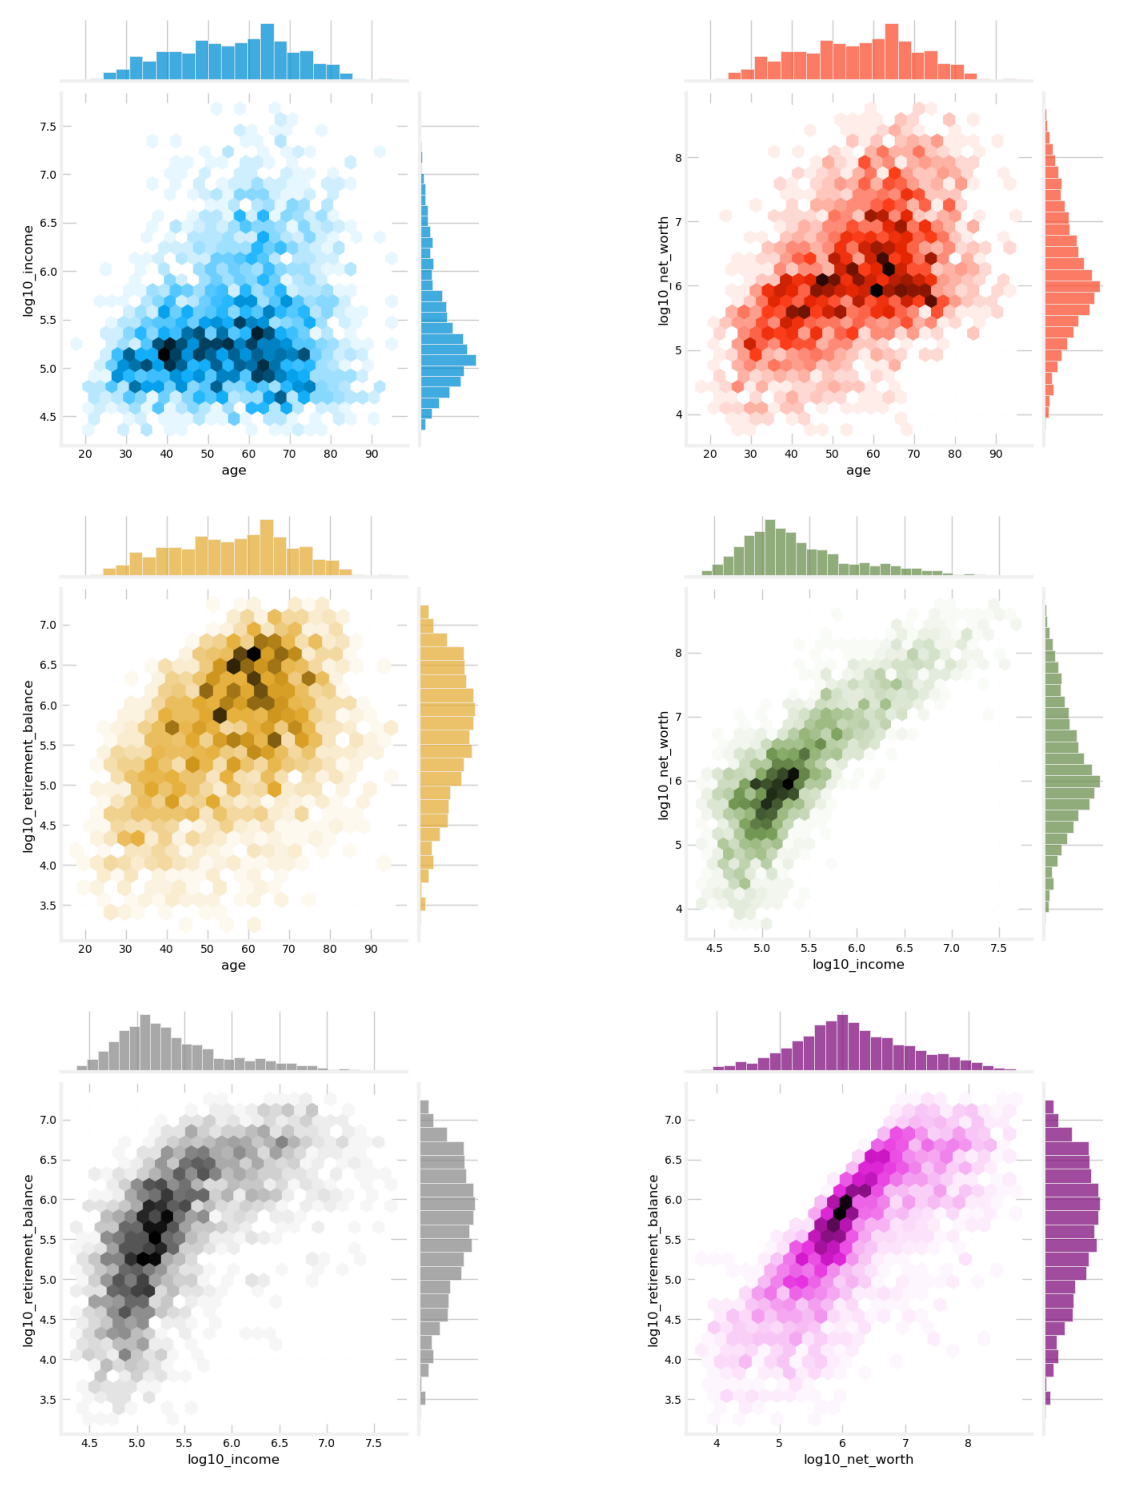

In [30]:
cols = log_result.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=log_result, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del cols, combinations, n, rows, fig, axs, k, img, jp, i, x, y

#### Generating Synthetic Data

From these distributions, how do we generate our mock investor pupulation? We can use Gaussian Multivariate copulas, which will capture the correlations and non-linear nature of the data, or more sophisticated CTGANs (Conditional Tabular Generative Adversarial Networks).

##### Gaussian Multivariate Copulas

Importing:

In [31]:
# from sklearn.preprocessing import PowerTransformer

# from copulas.multivariate import GaussianMultivariate, VineCopula

# # univariate classes I might use:
# from copulas.univariate.gaussian_kde import GaussianKDE
# from copulas.univariate.student_t import StudentTUnivariate
# from copulas.univariate.truncated_gaussian import TruncatedGaussian
# from copulas.univariate.gamma import GammaUnivariate

# # from copulas.visualization import scatter_3d, compare_3d

Transforming the data:

In [32]:
# transformer = PowerTransformer(method='yeo-johnson')

# Xtrans = log_result.copy()
# cols = Xtrans.columns.to_list()
# Xtrans[cols] = transformer.fit_transform(Xtrans[cols])

Checking distribution:

In [33]:
# combinations = list(itertools.combinations(cols, 2))
# n = len(combinations)

# # Compute grid size (square-ish)
# rows = int(np.ceil(n/2))
# # fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# # Flatten axes for easy indexing
# # axes = axes.flatten()

# imgs = []
# for i, (x, y) in enumerate(combinations):
#     # Create jointplot for each pair
#     jp = sns.jointplot(data=Xtrans, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
#     # Move jointplot figure into our axes grid
#     # g.fig.set_size_inches(6, 5);

#     buf = BytesIO()
#     jp.fig.savefig(buf, format="png")
#     plt.close(jp.fig)
#     buf.seek(0)
#     img = Image.open(buf)
#     imgs.append(img)

# fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

# for k, img in enumerate(imgs):
    
#     i = k // 2 # row
#     j = k % 2 # column

#     axs[i,j].imshow(img)
#     axs[i,j].axis('off')

# plt.tight_layout()
# plt.show()

# del combinations, n, rows, fig, axs, k, img, jp, i, x, y

Fitting the model:

In [34]:
# # 1) Choose per-column univariate models
# distribution = {"age":GaussianKDE,
#                 "log10_income":GaussianKDE,
#                 "log10_net_worth":GaussianKDE,
#                 "log10_retirement_balance":GaussianKDE}

# # 2) Build GaussianMultivariate with explicit distribution map
# copula_model = GaussianMultivariate(distribution=distribution,
#                                     random_state=1)

# # 3) Fit to data
# copula_model.fit(Xtrans)

We can then generate our synthetic data...

In [35]:
# copula_model.set_random_state(0) # fix global RNG
# synth_data = copula_model.sample(num_rows=175_000)

... transform back...

In [36]:
# synth_data[cols] = transformer.inverse_transform(synth_data[cols])
# synth_data.to_csv(input_data_dir+"full_synth_copula_investors.csv")

# del transformer, Xtrans

... clip extremes again...

In [37]:
# synth_data = remove_extremes(synth_data)

... limit to ages at or above 18 and below 100...

In [38]:
# synth_data = synth_data[(synth_data['age'] >= 18) & (synth_data['age'] < 100)]

... limit to 100,000...

In [39]:
# synth_data2 = synth_data.sample(n=100_000)

... reindex...

In [40]:
# synth_data2.reset_index(drop=True, inplace=True)

... describe...

In [41]:
# display(synth_data2)
# synth_data2.describe()

... and save:

In [42]:
# synth_data2.to_csv(input_data_dir+"synth_copula_investors.csv")
# del synth_data2

If the cells above are commented out, that means that we have already generated it, and we can just import it:

In [43]:
synth_data = pd.read_csv(input_data_dir+"synth_copula_investors.csv", index_col=0)

display(synth_data)

age  log10_income  log10_net_worth  log10_retirement_balance
0      39.810884      5.484336         6.378042                  5.571149
1      32.272183      4.634762         4.588827                  3.826077
2      73.205175      5.435693         5.719485                  5.833002
3      19.723169      4.676419         4.554483                  4.057175
4      43.773998      5.291114         6.318623                  4.178681
...          ...           ...              ...                       ...
99995  54.167157      4.881781         6.259100                  6.507023
99996  62.087154      5.074892         5.784267                  5.980479
99997  46.574877      5.620824         7.439998                  6.674789
99998  58.181908      5.227239         6.575585                  6.167831
99999  59.588628      5.125956         6.481483                  5.404444

[100000 rows x 4 columns]

Let us look at the plots:

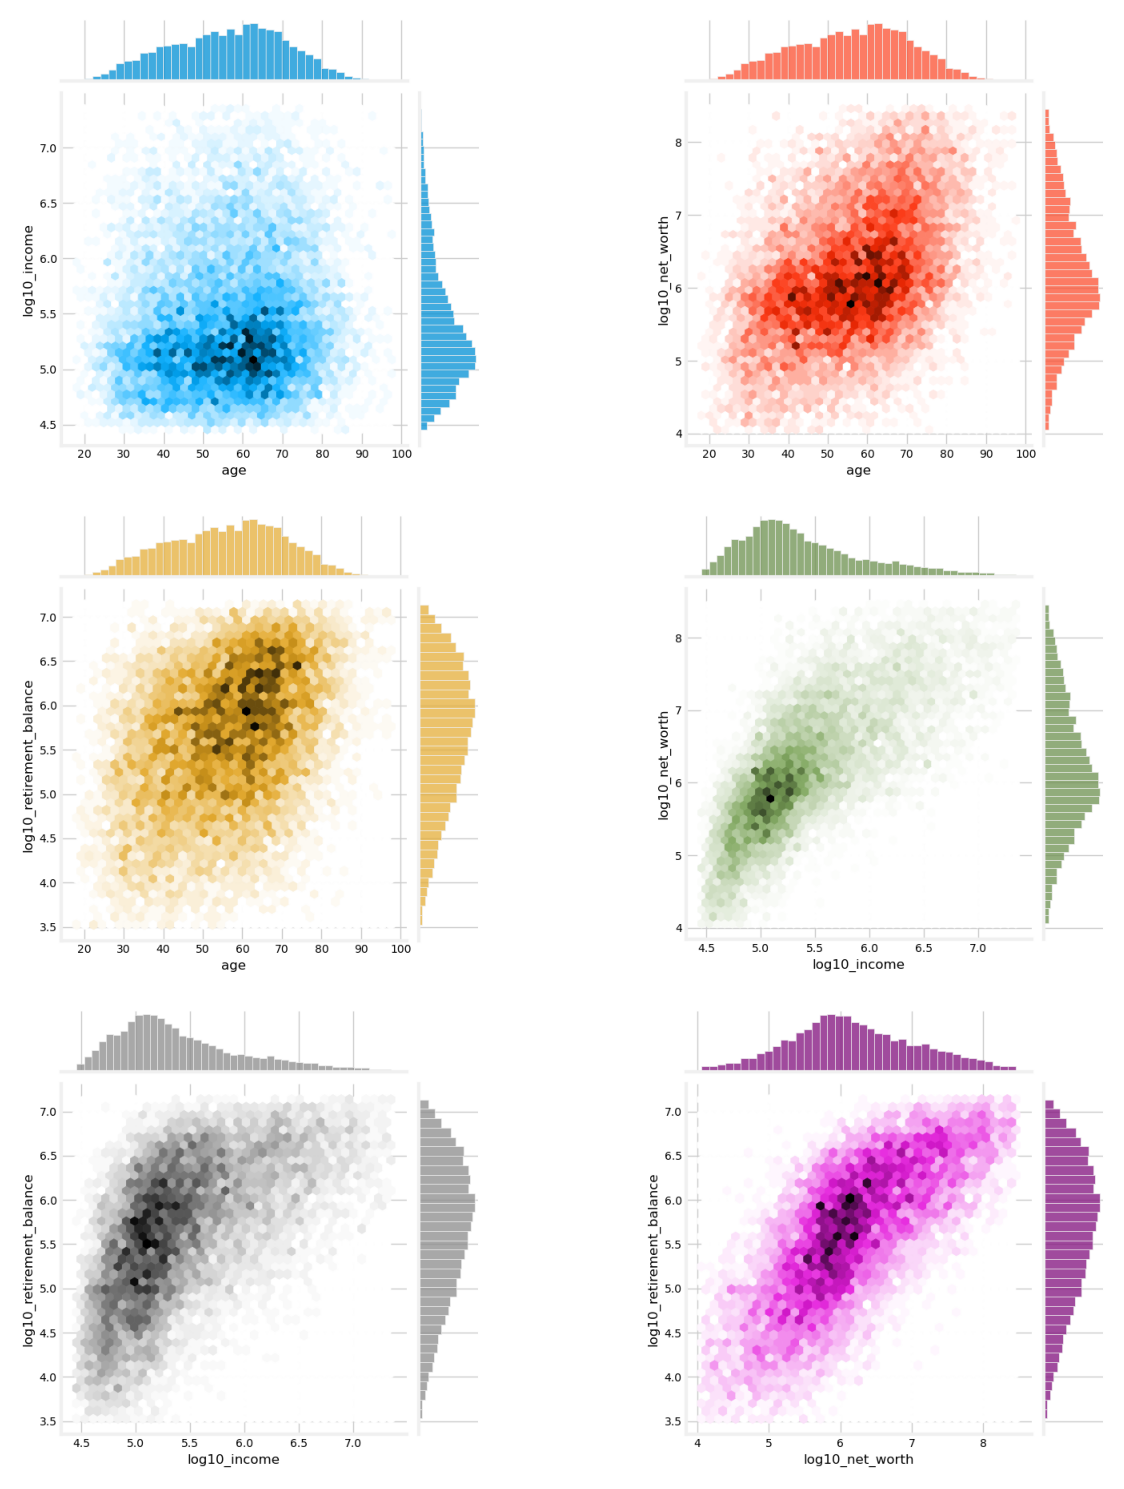

In [44]:
sample_data = synth_data.sample(frac=0.1)

cols = sample_data.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=sample_data, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del sample_data, combinations, n, rows, fig, axs, k, img, jp, i, x, y

In [45]:
del cols

##### CTGANs

Let us now try CTGANs.

In [46]:
# ?CTGANSynth

Detecting the metadata from our data:

In [47]:
# from sdv.metadata import Metadata

# metadata = Metadata.detect_from_dataframe(
#     data=log_result,
#     table_name='log_investors')

Training the CTGAN:

In [48]:
# from sdv.single_table import CTGANSynthesizer as CTGANSynth

# ctgan_model = CTGANSynth(metadata)
# ctgan_model.fit(log_result)

Generating and saving the synthetic data:

In [49]:
# synth_data = ctgan_model.sample(num_rows=100_000)
# synth_data.to_csv(input_data_dir+"synth_ctgan_investors.csv")

If the above cells are commented out, it means we have already synthetized the data, and therefore all we have to do is import it now:

In [50]:
synth_data = pd.read_csv(input_data_dir+"synth_ctgan_investors.csv", index_col=0)

display(synth_data)

age  log10_income  log10_net_worth  log10_retirement_balance
0      40.0      5.487021         6.281669                  6.319853
1      60.0      4.796932         4.534968                  6.112072
2      69.0      5.708108         6.640638                  7.195894
3      51.0      4.857052         7.431366                  6.581899
4      84.0      4.968282         4.438058                  4.603325
...     ...           ...              ...                       ...
49995  82.0      5.245562         7.853558                  6.109578
49996  70.0      4.855796         8.657961                  5.215414
49997  68.0      5.805733         2.490211                  5.180893
49998  52.0      4.817345         6.634175                  5.060597
49999  67.0      4.801772         5.609567                  6.347079

[50000 rows x 4 columns]

Joint plots:

In [51]:
sample_data = synth_data.sample(frac=0.1)

cols = sample_data.columns.to_list()
combinations = list(itertools.combinations(cols, 2))
n = len(combinations)

# Compute grid size (square-ish)
rows = int(np.ceil(n/2))
# fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))

# Flatten axes for easy indexing
# axes = axes.flatten()

imgs = []
for i, (x, y) in enumerate(combinations):
    # Create jointplot for each pair
    jp = sns.jointplot(data=sample_data, x=x, y=y, kind='hex', color=sns.color_palette(palette_538)[i]);
    # Move jointplot figure into our axes grid
    # g.fig.set_size_inches(6, 5);

    buf = BytesIO()
    jp.fig.savefig(buf, format="png")
    plt.close(jp.fig)
    buf.seek(0)
    img = Image.open(buf)
    imgs.append(img)

fig, axs = plt.subplots(rows, 2, figsize=(15, 15))

for k, img in enumerate(imgs):
    
    i = k // 2 # row
    j = k % 2 # column

    axs[i,j].imshow(img)
    axs[i,j].axis('off')

plt.tight_layout()
plt.show()

del sample_data, cols, combinations, n, rows, fig, axs, k, img, jp, i, x, y

Yikes, that is not as good. Since this is just a toy project, I will not try to improve upon the CTGAN, and simply use the copulas instead.

#### Clean

In [52]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name, result

### Investors: Contributions

Let us now consider how the investors contribute to their account, as a percentage of their income.

We simulate the contributions $r$ as a random sample from a beta distribution:

$r \sim 0.2 \times \mathrm{Beta}(\alpha, \beta) = 0.2 \times \frac{x^{\alpha-1}(1-x)^{\beta-1}}{\mathrm{B}(\alpha, \beta)}$,

where we have multiplied by $0.2$ to reflect that people, at most, will contribute $20\%$ of their income.

We shall pick some arbitrary numbers, $\alpha = 3$ and $\beta = 4.7$, which result in a right-skewed distribution, with mostly small percentages, but with a mode around $7\%$ (once we rescale by $0.2$), which is where most US 401(k) contributions are.

In [53]:
# rng = np.random.default_rng(seed=42)  # create a reproducible generator
# pcts = np.round(rng.beta(a=3, b=4.7, size=100_000)*0.2 * 100 * 4)/4 # rounds to the nearest 0.025

# pcts = pd.DataFrame(pcts, columns=['current_pct'])

Let us now compute the employee contributions. We will use a simple $100\%$ match up to $x\%$, where x is going to be a random draw from the same distribution.

In [54]:
# rng = np.random.default_rng(seed=10)
# cap = np.round(rng.beta(a=3, b=4.7, size=100_000)*0.2 * 100 * 4)/4

Computing matches:

In [55]:
# pcts['employer_cap'] = cap

# pcts.to_csv(input_data_dir+"synth_contributions.csv")

# del cap

If the above cells are commented out, it means we have already generated this data, so we just import it.

In [56]:
pcts = pd.read_csv(input_data_dir+"synth_contributions.csv", index_col=0)
display(pcts)

current_pct  employer_cap
0             6.75          6.00
1             8.00          5.25
2             9.75         10.75
3             8.00          9.00
4            10.50          9.00
...            ...           ...
99995        13.00          8.00
99996         7.25          1.75
99997        14.50          4.75
99998         9.75          5.50
99999         8.75          5.50

[100000 rows x 2 columns]

In [57]:
sns.histplot(pcts.sample(frac=0.01, random_state=10))
plt.xlabel("Contributions [%]");

In [58]:
del pcts

### Investors: Engagement & Activity

We now focus on how do the investors engage with ABC's Investments' ecosystem. We will focus on covariates such as last_login, login_frequency, email_check_frequency, and such.

#### Last login

We begin by modeling the last time the users logged in to ABC's Investments platform. We assume that they log in roughly once a month (30 days) or so, and that this is roughly uniform across all kinds of users.

In [59]:
# rng = np.random.default_rng(seed=1)
# logindays = np.round(rng.exponential(scale=30, size=100_000), 1)

# logindays = pd.DataFrame(logindays, columns=['last_login'])
# logindays.to_csv(input_data_dir+"synth_last_login.csv")

In [60]:
logindays = pd.read_csv(input_data_dir+"synth_last_login.csv", index_col=0)
display(logindays)

last_login
0            32.2
1             9.3
2           161.3
3            11.0
4             3.5
...           ...
99995         5.4
99996        30.0
99997         0.1
99998        21.1
99999        20.1

[100000 rows x 1 columns]

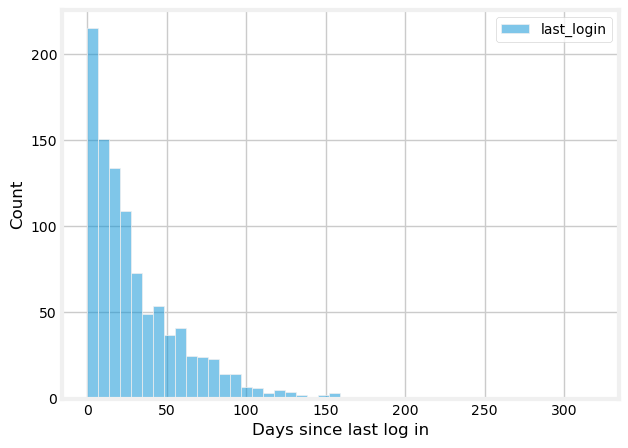

In [61]:
sns.histplot(logindays.sample(frac=0.01))
plt.xlabel("Days since last log in");

#### Account Tenure

Let us now model the account tenure. We will do this by capping, at the lower end, from last_login, and at the upper end, by min(age_of_ABC_investments, age_of_user - 18). We will simulate the distribution as an exponential.

In [62]:
from scipy.stats import truncexpon

In [63]:
abc_age = 50 # 50 years!

def tenure_fn(age, lastlogin, scale=5, random_state=1):
    """
    Simulate retirement account tenure using a truncated exponential distribution.

    The lower bound is derived from the last login date (converted to years), while the upper bound is capped by the minimum of the user's age minus 18 and the maximum allowed age of ABC investments.

    Args:
        age (array-like or float): User age(s) in years.
        lastlogin (array-like, float, or pandas object): Days since last login, converted internally to years.
        scale (float, optional): Scale parameter for the exponential distribution.
            Defaults to 5.
        random_state (int, optional): Random seed for reproducibility.
            Defaults to 1.

    Returns:
        float or ndarray: Simulated tenure(s) in years.
    """

    try:
        n = len(age)
    except TypeError:
        n = 1

    lower_end = (lastlogin/365) # convert days into years
    upper_end = np.minimum(np.max(age-18., 0), abc_age)

    if isinstance(lower_end, pd.DataFrame):
        lower_end = lower_end.squeeze().to_numpy()
    elif isinstance(lower_end, pd.Series):
        lower_end = lower_end.to_numpy()
    
    if isinstance(upper_end, pd.DataFrame):
        upper_end = upper_end.squeeze().to_numpy()
    elif isinstance(upper_end, pd.Series):
        upper_end = upper_end.to_numpy()

    tenure_arr = truncexpon.rvs(b=upper_end, loc=lower_end, scale=scale, random_state=random_state)

    if np.isscalar(tenure_arr):
        return float(tenure_arr)
    else:
        return tenure_arr

In [64]:
print(tenure_fn(60, 1))
print(tenure_fn(synth_data['age'], logindays))

2.7007689123233245
[2.78624836 6.39610572 0.44248972 ... 8.52027631 4.25276213 4.80246341]


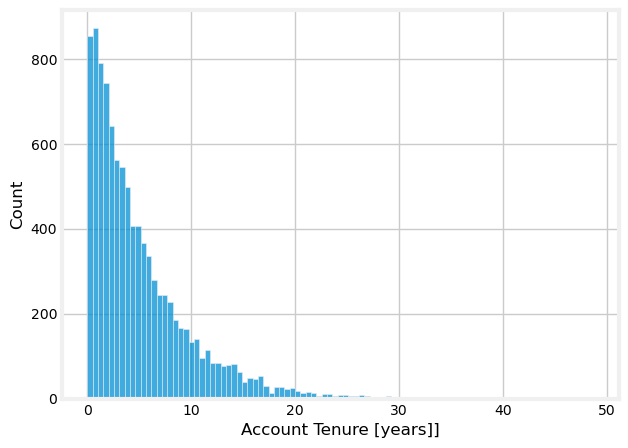

In [65]:
sns.histplot(pd.Series(tenure_fn(synth_data['age'], logindays)).sample(frac=0.1))
plt.xlabel("Account Tenure [years]]");

#### Time online (_e.g._ in email inbox)

Let us now model how much time each user spends in their email inbox.

I don't have data, but I have some anecdotal experience. Younger generations spend more time online than the older ones, and according to some cursory Google searches (from an Adobe survey cited [here](https://www.cnbc.com/2018/08/22/millennials-spend-more-time-on-their-email-than-any-other-generation.html), but that I have been unable to find), we are talking about 6.5 hrs for millenials (25 -- 24 y.o.), while 5 hrs for older people (> 35 y.o.).

Let us further assume, for simplicity, that this same time is time both on a PC and on their phones.

So let us take the mean of the ages in question (assuming the upper end of the larger age group is 65 y.o.), the fraction of hours in the day spent in the email inbox/on their phones, and draw a line through it.

In particular, if we have the data `[[x_1, y_1], [x_2, y_2]]`, then the formula for the line is simply:

$y(x) = m x + b$,

where $m = \frac{y_2 - y_1}{x_2 - x_1}$ and $b = \frac{x_2 y_1 - x_1 y_2}{x_2 - x_1}$.

In [66]:
# the data
age_time_data = np.array([[(25+34)/2, 6.5/24], [(65+35)/2, 5./24]])

# the function
def inbox_time_fn(age, data=age_time_data, noise=False, noise_sigma=(0.5/24), random_state=1):
    """
    Estimate time spent in the email inbox based on age using a linear interpolation.

    Optionally, add Gaussian noise to the estimate.

    Args:
        age (array-like or float): User age(s) in years.
        data (ndarray, optional): 2D array with age in column 0 and average email time in column 1. Defaults to `age_time_data`.
        noise (bool, optional): Whether to add Gaussian noise. Defaults to False.
        noise_sigma (float, optional): Standard deviation of noise in days.
            Defaults to 0.5/24 (half an hour). 
        random_state (int, optional): Seed for random number generation. Defaults to 1.

    Returns:
        ndarray or float: Estimated email time(s), rounded to 3 decimal places.
    """

    age_data = data[:,0]
    time_data = data[:,1]

    slope = float((time_data[-1] - time_data[0])/(age_data[-1] - age_data[0]))

    intercept = float((age_data[-1]*time_data[0] - age_data[0]*time_data[-1])/(age_data[-1] - age_data[0]))

    email_time = slope*age + intercept

    if noise:
        rng = np.random.default_rng(seed=random_state)
        noise_arr = rng.normal(loc=0., scale=noise_sigma, size=len(email_time))
        email_time += noise_arr

    return np.round(email_time, 3)

Let us now plot the results:

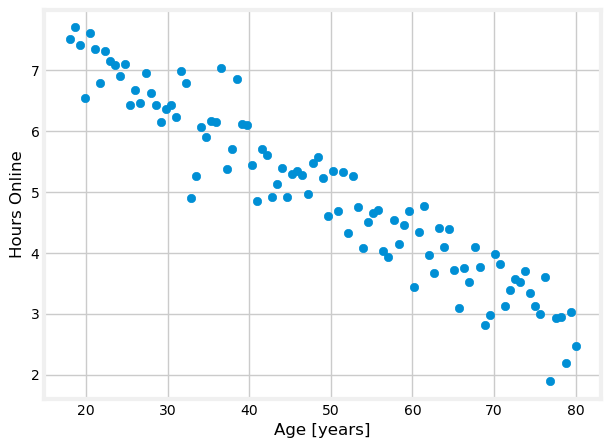

In [67]:
age_arr = np.linspace(18, 80, 101)
time_arr = inbox_time_fn(age_arr, noise=True)

plt.scatter(age_arr, time_arr*24)
plt.xlabel("Age [years]");
plt.ylabel("Hours Online");

del age_arr, time_arr

### Investors: Final Data

#### Concatenating Data

We have almost all that we need to construct our synthetic data.

We begin by importing all the data we have:

In [68]:
inv_data = pd.read_csv(input_data_dir+"synth_copula_investors.csv", index_col=0) # investor data

pct_data = pd.read_csv(input_data_dir+"synth_contributions.csv", index_col=0) # contributions

login_data = pd.read_csv(input_data_dir+"synth_last_login.csv", index_col=0)

Let us generate a random user ID:

In [69]:
unique_ids = np.random.choice(
    np.arange(100_000, 1_000_000),  # all possible 6-digit numbers
    size=len(inv_data),             # how many you want
    replace=False                   # no duplicates
)

final_data = inv_data.copy()
final_data.insert(0, 'user_id', pd.Series(unique_ids))

display(final_data)

user_id        age  log10_income  log10_net_worth  \
0       382474  39.810884      5.484336         6.378042   
1       440664  32.272183      4.634762         4.588827   
2       331390  73.205175      5.435693         5.719485   
3       275888  19.723169      4.676419         4.554483   
4       595153  43.773998      5.291114         6.318623   
...        ...        ...           ...              ...   
99995   989881  54.167157      4.881781         6.259100   
99996   710450  62.087154      5.074892         5.784267   
99997   364091  46.574877      5.620824         7.439998   
99998   357002  58.181908      5.227239         6.575585   
99999   493736  59.588628      5.125956         6.481483   

       log10_retirement_balance  
0                      5.571149  
1                      3.826077  
2                      5.833002  
3                      4.057175  
4                      4.178681  
...                         ...  
99995                  6.507023  
99996                  5.980479  
99997                  6.674789  
99998                  6.167831  
99999                  5.404444  

[100000 rows x 5 columns]

Concatenate to it the contributions data and the login data:

In [70]:
final_data = pd.concat([final_data, pct_data, login_data], axis=1)

display(final_data)

user_id        age  log10_income  log10_net_worth  \
0       382474  39.810884      5.484336         6.378042   
1       440664  32.272183      4.634762         4.588827   
2       331390  73.205175      5.435693         5.719485   
3       275888  19.723169      4.676419         4.554483   
4       595153  43.773998      5.291114         6.318623   
...        ...        ...           ...              ...   
99995   989881  54.167157      4.881781         6.259100   
99996   710450  62.087154      5.074892         5.784267   
99997   364091  46.574877      5.620824         7.439998   
99998   357002  58.181908      5.227239         6.575585   
99999   493736  59.588628      5.125956         6.481483   

       log10_retirement_balance  current_pct  employer_cap  last_login  
0                      5.571149         6.75          6.00        32.2  
1                      3.826077         8.00          5.25         9.3  
2                      5.833002         9.75         10.75       161.3  
3                      4.057175         8.00          9.00        11.0  
4                      4.178681        10.50          9.00         3.5  
...                         ...          ...           ...         ...  
99995                  6.507023        13.00          8.00         5.4  
99996                  5.980479         7.25          1.75        30.0  
99997                  6.674789        14.50          4.75         0.1  
99998                  6.167831         9.75          5.50        21.1  
99999                  5.404444         8.75          5.50        20.1  

[100000 rows x 8 columns]

Now, we generate the account tenure...

In [71]:
final_data['acct_tenure'] = pd.Series(tenure_fn(final_data['age'],
                                                final_data['last_login'],
                                                scale=5,
                                                random_state=1))

... and the expected time each user spends in their email inbox:

In [72]:
final_data['time_online_frac'] = inbox_time_fn(final_data['age'],
                                              noise=True,
                                              random_state=1)

We now rescale the `income`, `net_worth`, and `retirement_balance` (remember we took the log10(x), and rename them:

In [73]:
# rescaling
final_data[['log10_income', 'log10_net_worth', 'log10_retirement_balance']] = final_data[['log10_income', 'log10_net_worth', 'log10_retirement_balance']].apply(lambda col: 10**col)

# renaming
final_data.rename(columns={"log10_income":"income",
                           "log10_net_worth":"net_worth",
                           "log10_retirement_balance":"retirement_balance"}, inplace=True)

#### Buckets

First, we define the following buckets, of age, income, and balance:

In [74]:
def age_bucket(age):
    """
    Categorize age into predefined buckets.

    Buckets:
        <18      : None
        18-40    : "18-40"
        41-65    : "41-65"
        >65      : ">65"

    Args:
        age (int or float): Age in years.

    Returns:
        str or None: Age bucket label.
    """

    if age < 18:
        return None
    if age < 41:
        return "18-40"
    elif age < 66:
        return "41-65"
    else:
        return ">65"


income_quartiles = dict(zip(['income_25%', 'income_50%', 'income_75%'],
                            final_data['income'].quantile(q=[0.25, 0.5, 0.75]).to_numpy()))

def income_bucket(income):
    """
    Assign income to quartile-based buckets.

    Quartiles are precomputed from `final_data['income']`.

    Args:
        income (float): Annual income.

    Returns:
        str: Income bucket label ("0-25%", "25-50%", "50-75%", ">75%").
    """

    if income <= income_quartiles["income_25%"]:
        return "0-25%"
    elif income <= income_quartiles["income_50%"]:
        return "25-50%"
    elif income <= income_quartiles["income_75%"]:
        return "50-75%"
    else:
        return ">75%"
        

networth_quartiles = dict(zip(['networth_25%', 'networth_50%', 'networth_75%'],
                            final_data['net_worth'].quantile(q=[0.25, 0.5, 0.75]).to_numpy()))

def networth_bucket(net_worth):
    """
    Assign net worth to quartile-based buckets.

    Quartiles are precomputed from `final_data['net_worth']`.

    Args:
        net_worth (float): Net worth value.

    Returns:
        str: Net worth bucket label ("0-25%", "25-50%", "50-75%", ">75%").
    """

    if net_worth <= networth_quartiles["networth_25%"]:
        return "0-25%"
    elif net_worth <= networth_quartiles["networth_50%"]:
        return "25-50%"
    elif net_worth <= networth_quartiles["networth_75%"]:
        return "50-75%"
    else:
        return ">75%"

balance_quartiles = dict(zip(['balance_25%', 'balance_50%', 'balance_75%'],
                            final_data['retirement_balance'].quantile(q=[0.25, 0.5, 0.75]).to_numpy()))

def balance_bucket(balance):
    """
    Assign retirement balance to quartile-based buckets.

    Quartiles are precomputed from `final_data['retirement_balance']`.

    Args:
        balance (float): Retirement account balance.

    Returns:
        str: Balance bucket label ("0-25%", "25-50%", "50-75%", ">75%").
    """

    if balance <= balance_quartiles["balance_25%"]:
        return "0-25%"
    elif balance <= balance_quartiles["balance_50%"]:
        return "25-50%"
    elif balance <= balance_quartiles["balance_75%"]:
        return "50-75%"
    else:
        return ">75%"

Assign buckets/cohorts

In [75]:
# age
final_data['age_cohort'] = final_data['age'].map(lambda age: age_bucket(age))

# income
final_data['income_cohort'] = final_data['income'].map(lambda income: income_bucket(income))

# net_worth
final_data['networth_cohort'] = final_data['net_worth'].map(lambda ntw: networth_bucket(ntw))

# balance
final_data['balance_cohort'] = final_data['retirement_balance'].map(lambda bal: balance_bucket(bal))

#### Saving Data

In [76]:
display(final_data)

user_id        age         income     net_worth  retirement_balance  \
0       382474  39.810884  305025.665609  2.388042e+06        3.725191e+05   
1       440664  32.272183   43128.261247  3.879957e+04        6.700035e+03   
2       331390  73.205175  272704.999245  5.241858e+05        6.807720e+05   
3       275888  19.723169   47470.011310  3.584946e+04        1.140709e+04   
4       595153  43.773998  195485.030041  2.082680e+06        1.508973e+04   
...        ...        ...            ...           ...                 ...   
99995   989881  54.167157   76169.542721  1.815932e+06        3.213832e+06   
99996   710450  62.087154  118820.684585  6.085095e+05        9.560458e+05   
99997   364091  46.574877  417661.119214  2.754219e+07        4.729217e+06   
99998   357002  58.181908  168747.978240  3.763444e+06        1.471741e+06   
99999   493736  59.588628  133645.886076  3.030281e+06        2.537724e+05   

       current_pct  employer_cap  last_login  acct_tenure  time_online_frac  \
0             6.75          6.00        32.2     2.786248             0.247   
1             8.00          5.25         9.3     6.396106             0.279   
2             9.75         10.75       161.3     0.442490             0.144   
3             8.00          9.00        11.0     1.830201             0.273   
4            10.50          9.00         3.5     0.803137             0.246   
...            ...           ...         ...          ...               ...   
99995        13.00          8.00         5.4     7.292631             0.196   
99996         7.25          1.75        30.0     6.564807             0.173   
99997        14.50          4.75         0.1     8.520276             0.189   
99998         9.75          5.50        21.1     4.252762             0.182   
99999         8.75          5.50        20.1     4.802463             0.199   

      age_cohort income_cohort networth_cohort balance_cohort  
0          18-40        50-75%          50-75%         25-50%  
1          18-40         0-25%           0-25%          0-25%  
2            >65        50-75%          25-50%         50-75%  
3          18-40         0-25%           0-25%          0-25%  
4          41-65        50-75%          50-75%          0-25%  
...          ...           ...             ...            ...  
99995      41-65         0-25%          50-75%           >75%  
99996      41-65        25-50%          25-50%         50-75%  
99997      41-65        50-75%            >75%           >75%  
99998      41-65        25-50%          50-75%         50-75%  
99999      41-65        25-50%          50-75%         25-50%  

[100000 rows x 14 columns]

Let us save the data!

In [77]:
final_data.to_csv(input_data_dir+"synth_final_inv.csv")

In [78]:
del synth_data, logindays, inv_data, pct_data, login_data, unique_ids, final_data

### Cleanup

In [79]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name

## 3. A/B Test

Now that we have our investor data, it is time to prepare the A/B test. In order to do that, we need to:

1. Simulate the baseline/control conversion rate (need to use logistic regression)
2. Simulate the treatment conversion rate
3. Fix the randomization procedure
4. Compute the details of the A/B experiment ($\alpha$, $\beta$, MDE, $n_{A/B}$, etc.)
5. Simulate the experiment, as well as the monitoring procedure

### Loading investor data

Let us just load our entire data.

In [80]:
full_data = pd.read_csv(input_data_dir+"synth_final_inv.csv", index_col=0)

In [81]:
full_data.describe()

user_id            age        income     net_worth  \
count  100000.000000  100000.000000  1.000000e+05  1.000000e+05   
mean   550304.935070      56.139697  8.288308e+05  1.106708e+07   
std    259649.775708      14.825513  2.082434e+06  3.001615e+07   
min    100009.000000      18.016617  2.862767e+04  1.131365e+04   
25%    325543.500000      44.939707  9.458092e+04  3.566059e+05   
50%    550502.500000      57.051305  1.835100e+05  1.235719e+06   
75%    775061.000000      67.122556  5.142359e+05  5.838900e+06   
max    999987.000000      99.931666  2.251621e+07  2.888959e+08   

       retirement_balance    current_pct   employer_cap     last_login  \
count        1.000000e+05  100000.000000  100000.000000  100000.000000   
mean         1.436394e+06       7.811748       7.786893      29.879831   
std          2.187080e+06       3.310969       3.312753      29.749018   
min          3.369682e+03       0.000000       0.250000       0.000000   
25%          1.169531e+05       5.250000       5.250000       8.600000   
50%          4.950320e+05       7.500000       7.500000      20.700000   
75%          1.747408e+06      10.000000      10.000000      41.600000   
max          1.377162e+07      19.000000      19.250000     363.100000   

         acct_tenure  time_online_frac  
count  100000.000000     100000.000000  
mean        5.075178          0.189518  
std         4.993345          0.049825  
min         0.001531          0.015000  
25%         1.502575          0.153000  
50%         3.551274          0.188000  
75%         7.012268          0.225000  
max        57.877685          0.376000

### Modeling Conversion Rate

We are interested in the conversion rate $p$ over a given amount of time $T$. Thus, we are interested in the chances of a given investor or client increasing his retirement contributions in, say, $T=30 \text{ days}$.

We will model $p$ with a logistic regression.

The logit is:

$\eta_i = \boldsymbol{\beta} \cdot \mathbf{X}_i + \beta_0$, and the logistic regression models the probability as a sigmoid of the logit:

$p_i = \sigma(\eta_i) \equiv \frac{1}{1 + e^{-\eta_i}}$.

Note that this means

$\frac{p_i}{1-p_i} = e^{\eta_i}$

i.e.

$\eta_i = \ln\left( \frac{p_i}{1-p_i} \right)$.

**N.B.: do NOT confuse the conversion rate $p$ with the contribution percentage!**

In [82]:
from scipy.special import expit as logistic
from scipy.optimize import fsolve

First, a note about the baseline conversion rate $p_{\rm base} \equiv p_0$.

The conversion rate $p_A$ of the control arm A will be equal to it: $p_A = p_0$, while that for the arm B, $p_B$, will include the effect of the treatment.

**N.B.:** This baseline conversion rate is different from the reference rate $p_{\rm ref} = p_*$ defined below, although they are all similar.

In order to model the conversion, we need to fix the coefficients $(\boldsymbol{\beta}, \, \beta_0)$ of the logit. We can do that by:

1. $\boldsymbol{\beta}$: There are two cases:

_Continuous covariates:_ performing a Taylor expansion around a reference probability $p_*$ that is similar to all other probabilities of interest (such as $p_0 = p_A$, and $p_B$):

$\frac{d p}{d X_j} = \frac{d p}{d \eta} \frac{d \eta}{d X_j} = \left( \frac{d \eta}{d p} \right)^{-1} \frac{d \eta}{d X_j} = \beta_j \, p(1 - p)$,

where $X_j$ is the $j$-th covariate. Thus, for a reference $p_*$, a small change $\Delta X_j$ that corresponds to a small change $\Delta p$ means that:

$\Rightarrow \quad \beta_j \approx \frac{\Delta p}{p_*(1-p_*) \Delta X_j} = \frac{1}{(1-p_*)}\frac{\Delta p / p_*}{\Delta X_j}$.

Once again, since we have a specific conversion rate of interest in mind, we take $p_*$ close to $p_A$.

_Discrete covariates:_ we write

$\beta_j = \ln(\mathrm{OR})$,

where $\mathrm{OR}$ is the ``odds ratio'', i.e., what the presence of the covariate does for the probability compared to the absence:

$\mathrm{OR} = \frac{p_{X=1}/(1 - p_{X=1})}{p_{X=0}/(1 - p_{X=0})}$
   
2. $\beta_0$: it can be found by first computing the population average $\overline{p} = \frac{1}{N}\sum\limits_{i=1}^{N} \, \sigma(\eta(x_i))$, making it equal to the baseline conversion $p_0 = p_A$, and solving for $\beta_0$ numerically.

**N.B.** on $\boldsymbol{\beta}$:
In this section we fix them once and for all, for some given reference conversion rate $p_*$ in the vicinity of the baseline rate $p_{\rm base}$ and $p_B$ values of interest.

Once we perform the A/B test, we will be free to change the underlying baseline conversion rate $p_0 = p_A$ to test different scenarios. Whenever we make these changes, **we will maintain the same coefficients**. This is because these coefficients play the role of _"law of physics"_: they describe the laws that rule the underlying phenomenon (namely, the conversion rate as a function of the user's features).

The only thing that we _will_ change is the intercept: picking a new $p_{A/B}$ will leave the $\boldsymbol{\beta}$ coefficients the same (the same ``laws''), but change the intercept $\beta_0$.

But what to choose for $p_{\rm ref} = p_*$? Well, perhaps it's better if we look at the conversion probability over a long span of time.

Let us begin by assuming there is no heterogeneity (or rather, we are ignoring any difference between users), and the process of converting or not is memoryless.

Then, for example, assuming that there is a 15% chance of increasing one's contributions in a given year, then

$p_{*,\mathrm{yr}} = 0.15$.

To see that this seems reasonable, note that the chances of NOT converting in 4 years is

$(1 - p_{*,\mathrm{yr}})^4 \approx 0.52$,

a bit over a half. So one has a 50% chance of increasing one's contributions in 4 years, it seems reasonable.

Therefore, the probability of not converting in a year is:

$(1 - p_{*,\mathrm{yr}}) = 0.85 = (1 - p_{*,\mathrm{mo}})^{12} = (1 - p_{*,\mathrm{14d}})^{26}$

$\Rightarrow p_{*, \mathrm{mo.}} \approx 1.35\%$

and

$p_{*, \mathrm{14d}} \approx 0.62\%$

In [83]:
pstar = 0.0135 # this will be the reference conversion, pA and pB will be similar to it.

Begin by writing the logistic function $\sigma(\eta((\boldsymbol{\beta}, \beta_0), \mathbf{X}))$:

In [84]:
# rough scale of eta (from logit formula)
eta_scale = np.abs(np.log(pstar / (1 - pstar)))

def eta_fn(betaj_beta0, Xmatrix, noise=False, noise_sigma=(0.1*eta_scale), random_state=1):
    """
    Compute the linear predictor (eta) for a logistic model.

    eta = X * beta + beta0, optionally with additive Gaussian noise.

    Args:
        betaj_beta0 (tuple): Tuple containing array-like betas and scalar beta0.
        Xmatrix (DataFrame): Feature matrix with columns corresponding to betas.
        noise (bool, optional): Whether to add Gaussian noise. Defaults to False.
        noise_sigma (float or array-like, optional): Standard deviation of noise.
            Defaults to 0.1 * eta_scale.
        random_state (int, optional): Seed for random number generation. Defaults to 1.

    Returns:
        float or ndarray: Linear predictor(s) eta.
    """
    
    betas, beta0 = betaj_beta0 # splitting the betas

    # beta_j*X_j
    betaX = Xmatrix.mul(betas, axis=1).to_numpy()
    
    # sum(beta_j*X_j)
    covars = np.sum(betaX, axis=1)

    # eta = beta*X + beta0 = logit(p) = ln(p/(1-p))
    eta = covars + beta0

    # trying different lengths
    try:
        n = len(eta)
    except TypeError:
        n = 1

    # add noise
    if noise:
        rng = np.random.default_rng(seed=random_state)
        noise_arr = rng.normal(loc=0., scale=noise_sigma, size=n)
        eta += noise_arr

    if len(eta) == 1:
        return float(eta[0])
    else:
        return eta

    

def sigma_fn(betaj_beta0, Xmatrix, **eta_kwargs):
    """
    Compute the logistic function (sigma) for a given linear predictor.

    sigma = 1 / (1 + exp(-eta)), where eta = X * beta + beta0.

    Args:
        betaj_beta0 (tuple): Tuple containing array-like betas and scalar beta0.
        Xmatrix (DataFrame): Feature matrix with columns corresponding to betas.
        **eta_kwargs: Additional arguments passed to `eta_fn` (e.g., noise, noise_sigma, random_state).

    Returns:
        float or ndarray: Logistic function values corresponding to eta.
    """

    # eta = beta*X + beta0 = logit(p) = ln(p/(1-p))
    eta = eta_fn(betaj_beta0, Xmatrix, **eta_kwargs)

    return logistic(eta)

Now the individual $\beta$'s:

$\beta_j \approx \frac{1}{(1-p_*)}\frac{\Delta p / p_*}{\Delta X_j}$

In [85]:
def beta_j(p_ref, dp_rel, dX):
    """
    Approximate a single logistic regression coefficient beta_j.

    Uses the relationship beta_j ≈ (Δp / ΔX) / (1 - p_ref).

    Args:
        p_ref (float): Reference probability.
        dp_rel (float): Change in probability relative to reference.
        dX (float): Change in predictor variable.

    Returns:
        float: Approximated beta_j coefficient.
    """

    # numerator:
    num = dp_rel/dX

    # denominator:
    den = (1-p_ref)

    # approximation for beta_j
    bj = num/den
    
    return bj



def beta0_fn(conv_rate, betas, Xmatrix):
    """
    Compute the intercept (beta0) for a logistic regression to match a target conversion rate given beta coefficients and feature matrix.

    Solves for beta0 such that the population mean of the logistic function equals the desired conversion rate.

    Args:
        conv_rate (float): Target population conversion probability.
        betas (array-like): Coefficients for predictor variables.
        Xmatrix (DataFrame): Feature matrix corresponding to betas.

    Returns:
        float: Intercept (beta0) for the logistic regression model.
    """

    # population average of the probability
    def avg_prob(intercept):
        """
        Compute the average predicted probability across the population.

        Args:
            intercept (float): Intercept (beta0) for the logistic regression model.

        Returns:
            float: Mean predicted probability over all rows in Xmatrix.
        """

        # conversion probability for the entire population
        prop_pop = sigma_fn((betas, intercept), Xmatrix)

        return np.mean(prop_pop)

    # the function whose root we need to find
    def fn_to_solve(intercept):
        """
        Define the function whose root corresponds to the intercept that matches the target conversion rate.

        Args:
            intercept (float): Intercept (beta0) for the logistic regression model.

        Returns:
            float: log10 of the ratio between population mean probability and target conversion rate.
    """

        return np.log10(avg_prob(intercept)/conv_rate)

    
    # guess for the intercept
    b0_guess = np.log(conv_rate / (1 - conv_rate))

    # solving
    b0 = float(fsolve(fn_to_solve, b0_guess, xtol=1.e-10, maxfev=10_000)[0])

    return b0

Finally, a few words about $p_i = \sigma(eta_i)$. We have computed

$\mathbb{E}[p] \approx \hat{p} \approx \frac{1}{N}\sum\limits_{i=1}^N p_i$,

which for large $N$ we enforce to be equal to $p_0 = p_A$ for arm A; while equal to $p_B = p_0 + \Delta$ for arm B.

What about the variance of $p$?

$\mathrm{Var}(p) \approx \hat{\mathrm{Var}}(p) = \frac{1}{N-1} \sum\limits_{i=1}^{N} (p_i - \hat p)^2 = \mathbb{E}[p^2] - \hat{p}^2$

indeed, that's how we computed $\beta_0$.

But this is **not** the variance of the Yes/No (1/0 's) Bernoulli events that each user does based on its probability $p_i$. That is:

$\mathrm{Var}(Y) = \mathrm{Var}(p) + \mathbb{E}[\mathrm{Var}(p)]$,

i.e., the first term is the _heterogeneity_ variance, while the second term is the _within user_ (Bernoulli) variance. But that is

$\mathbb{E}[\mathrm{Var}(p)] = \mathbb{E}[p(1-p)] = \hat{p} - \mathbb{E}[\hat{p}^2]$,

so we have

$\mathrm{Var}(Y) = \hat{p}(1 - \hat{p})$,

as expected!

#### A: Baseline/Control

We now determine the coefficients $\boldsymbol\beta$ for the baseline model:

$\beta_j \approx \frac{1}{(1-p_*)}\frac{\Delta p / p_*}{\Delta X_j}$.

We will take the $\log_{10}$ of the monetary variables; all others will be as is.

In [86]:
beta_coeffs_base = {}

# age [increase = 10 years]:
# adding 10 years of age decreases reference conversion rate by a relative 50%
# EXPLANATION: 45 yo is right between 25 (entering work force) and 65 (roughly retirement). So once one is 65 yo, i.e. 20 years from 45 yo, we should almost erase the entire conversion rate. If that is 0.06%, erasing 4% sounds good
beta_coeffs_base['age'] = beta_j(pstar, -0.5, 10)

# income [increase = one order of magnitude]:
# one order of magnitude more a year in income increases conversion rate by a relative 100%
# EXPLANATION: earning $500,000 increasing the chances of choosing to raise one's contributions by a relative 50% (e.g., from 0.6% to 0.9%)
beta_coeffs_base['log10_income'] = beta_j(pstar, +1, 1)

# balance [increase = one order of magnitude]
# one order of magnitude larger balance decreases conversion rate by a relative 50%
# EXPLANATION: the median balance is roughly $500,000, so 5 increases of $100,000 takes us up to $1'000,000 in savings. That's 1M; assuming 10 years of retirement that's a good $100,000 per year. Such a healthy retirement should make us really want to decrease our contributions to almost nothing (so from 0.6% to 0%)
beta_coeffs_base['log10_retirement_balance'] = beta_j(pstar, -0.5, 1)

# acct_tenure [increase = 1 years]
# adding 1 year to the account decreases the conversion rate by 2.5%
# EXPLANATION: the older the account, the more likely one has reached a steady-state or equilibrium in one's contributions. Career length is, on average, 40 years (25 y.o. to 65 y.o.), and in that time one my go from an initial propensity to increase one's contributions ~ 0.6% all the way down to 0%
beta_coeffs_base['acct_tenure'] = beta_j(pstar, -0.025, 1)

# last_login [increase = 1 day]
# every additional 1 day since last login decreases the conversion rate by a relative 0.2%
# EXPLANATION: if it's been a whole year since the last login this corresponds to a relative decrease of 73%. Makes sense: such unattended accounts probably indicate a hands-off investor
beta_coeffs_base['last_login'] = beta_j(pstar, -0.002, 1)

# current_pct threshold
# if current_pct > 7% (the mode of employee contributions), odds decrease by half
# EXPLANATION: it starts to feel like a lot
beta_coeffs_base['current_pct_above_7pp'] = np.log(0.5)

# employer matching
# if current_pct > employer_cap, odds decrease by half
# EXPLANATION: if the employer is not going to match it, why increase conversion?
beta_coeffs_base['current_pct_above_employer_cap'] = np.log(0.5)

beta_coeffs_base = pd.Series(beta_coeffs_base)

In [87]:
beta_coeffs_base

age                              -0.050684
log10_income                      1.013685
log10_retirement_balance         -0.506842
acct_tenure                      -0.025342
last_login                       -0.002027
current_pct_above_7pp            -0.693147
current_pct_above_employer_cap   -0.693147
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix`:

In [88]:
def X_features_beta_base(data):
    """
    Construct a feature matrix for base logistic regression modeling.

    Features include age, log-transformed income and retirement balance, account tenure, last login, and binary indicators for contribution thresholds.

    Args:
        data (DataFrame): Input dataset containing columns:
            'age', 'income', 'retirement_balance', 'acct_tenure',
            'last_login', 'current_pct', 'employer_cap'.

    Returns:
        DataFrame: Feature matrix suitable for logistic regression.
    """

    Xmatrix = pd.DataFrame()

    Xmatrix['age'] = data['age']
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    Xmatrix['acct_tenure'] = data['acct_tenure']
    Xmatrix['last_login'] = data['last_login']
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    return Xmatrix

Example computation:

In [89]:
Xm = X_features_beta_base(full_data)

display(Xm)

age  log10_income  log10_retirement_balance  acct_tenure  \
0      39.810884      5.484336                  5.571149     2.786248   
1      32.272183      4.634762                  3.826077     6.396106   
2      73.205175      5.435693                  5.833002     0.442490   
3      19.723169      4.676419                  4.057175     1.830201   
4      43.773998      5.291114                  4.178681     0.803137   
...          ...           ...                       ...          ...   
99995  54.167157      4.881781                  6.507023     7.292631   
99996  62.087154      5.074892                  5.980479     6.564807   
99997  46.574877      5.620824                  6.674789     8.520276   
99998  58.181908      5.227239                  6.167831     4.252762   
99999  59.588628      5.125956                  5.404444     4.802463   

       last_login  current_pct_above_7pp  current_pct_above_employer_cap  
0            32.2                      1                               1  
1             9.3                      1                               1  
2           161.3                      1                               0  
3            11.0                      1                               0  
4             3.5                      1                               1  
...           ...                    ...                             ...  
99995         5.4                      1                               1  
99996        30.0                      1                               1  
99997         0.1                      1                               1  
99998        21.1                      1                               1  
99999        20.1                      1                               1  

[100000 rows x 7 columns]

We can then compute $\beta_0$:

In [90]:
inter = beta0_fn(pstar, beta_coeffs_base, Xm)
print(inter)

-3.344828900686084


From that we can compute $\eta$:

In [91]:
eta_fn((beta_coeffs_base, inter), Xm)

array([-4.14910431, -3.78879016, -5.5328861 , ..., -4.99318238,
       -5.65792665, -5.45688055], shape=(100000,))

And from that we can find $\overline{p} = \langle \sigma(\eta) \rangle$:

In [92]:
sigeta = sigma_fn((beta_coeffs_base, inter), Xm)
print("sigma(eta) =", sigeta)
print("pbar = <sigma(eta)> =", float(np.mean(sigeta)))

sigma(eta) = [0.01553345 0.02212248 0.00393898 ... 0.00673833 0.00347761 0.00424872]
pbar = <sigma(eta)> = 0.0135


Proportion of values above 0.5:

In [93]:
np.std(sigeta, ddof=1)**2 / (pstar*(1-pstar))

np.float64(0.02056018499529427)

Histogram:

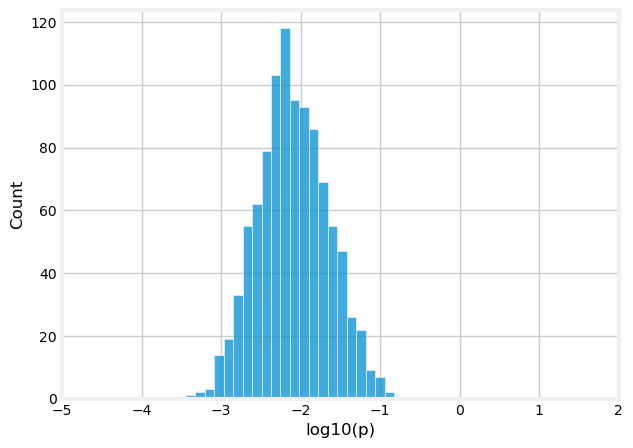

In [94]:
tmp1 = np.log10(pd.Series(sigeta).sample(frac=0.01))
sns.histplot(tmp1)

plt.xlim(-5, 2);
plt.xlabel("log10(p)");

In [95]:
del Xm, inter, sigeta

#### B: Treatment

Let us now model the treatment. We follow the same formulas as before, but this we need to update the coefficients (and even the intercept, since the population itself has changed: we are conditioning on having received the treatment).

In [96]:
beta_coeffs_treat = beta_coeffs_base.copy() # we make a shallow copy of the baseline

# age [increase = 10 years]:
# treatment increases conversion rate for younger people: 10 years younger are a relative 10% more responsive
beta_coeffs_treat['age'] += beta_j(pstar, -0.1, 10)

# income [increase = one order of magnitude]:
# treatment increases conversion rate by an additional relative 10% every order of magnitude more of income a year
beta_coeffs_treat['log10_income'] += beta_j(pstar, +0.1, 1)

# balance [increase = one order of magnitude]:
# treatment increases conversion rate by an additional relative 10% by adding $100,000 to balance
beta_coeffs_treat['log10_retirement_balance'] += beta_j(pstar, +0.1, 1)

# acct_tenure [increase = 1 year]
# treatment increases conversion rate by an additional relative 1% when adding 1 year to the account tenure
beta_coeffs_treat['acct_tenure'] += beta_j(pstar, +0.01, 1)

# last_login [increase = 1 day]
# treatment increases the conversion rate of those with most recent logins by a relative 5%
beta_coeffs_treat['last_login'] += beta_j(pstar, -0.05, 1)

# time_online_frac [increase = 1 hr]
# treatment increases the conversion rate of those more terminally online by a relative 10% for every hour more spent
# EXPLANATION
beta_coeffs_treat['time_online_frac'] = beta_j(pstar, +0.1, (1./24))

So the new coefficients are:

In [97]:
beta_coeffs_treat

age                              -0.060821
log10_income                      1.115053
log10_retirement_balance         -0.405474
acct_tenure                      -0.015205
last_login                       -0.052712
current_pct_above_7pp            -0.693147
current_pct_above_employer_cap   -0.693147
time_online_frac                  2.432843
dtype: float64

Compare to baseline:

In [98]:
beta_coeffs_base

age                              -0.050684
log10_income                      1.013685
log10_retirement_balance         -0.506842
acct_tenure                      -0.025342
last_login                       -0.002027
current_pct_above_7pp            -0.693147
current_pct_above_employer_cap   -0.693147
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix` for the treatment:

In [99]:
def X_features_beta_treat(data):
    """
    Construct a feature matrix for treatment logistic regression modeling.

    Includes base features plus `time_online_frac`, and binary indicators for contribution thresholds.

    Args:
        data (DataFrame): Input dataset containing columns:
            'age', 'income', 'retirement_balance', 'acct_tenure',
            'last_login', 'time_online_frac', 'current_pct', 'employer_cap'.

    Returns:
        DataFrame: Feature matrix suitable for logistic regression with treatment features.
    """


    Xmatrix = pd.DataFrame()

    Xmatrix['age'] = data['age']
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    Xmatrix['acct_tenure'] = data['acct_tenure']
    Xmatrix['last_login'] = data['last_login']
    Xmatrix['time_online_frac'] = data['time_online_frac']
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    return Xmatrix

Example computation:

In [100]:
Xm = X_features_beta_treat(full_data)

display(Xm)

age  log10_income  log10_retirement_balance  acct_tenure  \
0      39.810884      5.484336                  5.571149     2.786248   
1      32.272183      4.634762                  3.826077     6.396106   
2      73.205175      5.435693                  5.833002     0.442490   
3      19.723169      4.676419                  4.057175     1.830201   
4      43.773998      5.291114                  4.178681     0.803137   
...          ...           ...                       ...          ...   
99995  54.167157      4.881781                  6.507023     7.292631   
99996  62.087154      5.074892                  5.980479     6.564807   
99997  46.574877      5.620824                  6.674789     8.520276   
99998  58.181908      5.227239                  6.167831     4.252762   
99999  59.588628      5.125956                  5.404444     4.802463   

       last_login  time_online_frac  current_pct_above_7pp  \
0            32.2             0.247                      1   
1             9.3             0.279                      1   
2           161.3             0.144                      1   
3            11.0             0.273                      1   
4             3.5             0.246                      1   
...           ...               ...                    ...   
99995         5.4             0.196                      1   
99996        30.0             0.173                      1   
99997         0.1             0.189                      1   
99998        21.1             0.182                      1   
99999        20.1             0.199                      1   

       current_pct_above_employer_cap  
0                                   1  
1                                   1  
2                                   0  
3                                   0  
4                                   1  
...                               ...  
99995                               1  
99996                               1  
99997                               1  
99998                               1  
99999                               1  

[100000 rows x 8 columns]

We can then compute $\beta_0$, demanding a lift of 2% over baseline

In [101]:
lift = 0.02
inter = beta0_fn((pstar+lift), beta_coeffs_treat, Xm)
print(inter)

-2.7002951649329257


From that we can compute $\eta$:

In [102]:
eta_fn((beta_coeffs_treat, inter), Xm)

array([ -3.79032613,  -2.34149603, -12.30868422, ...,  -3.03327579,
        -5.0316235 ,  -4.83487257], shape=(100000,))

And from that we can find $\overline{p} = \langle \sigma(\eta) \rangle$:

In [103]:
sigeta = sigma_fn((beta_coeffs_treat, inter), Xm)
print("sigma(eta) =", sigeta)
print("pbar = <sigma(eta)> =", float(np.mean(sigeta)))

sigma(eta) = [2.20892762e-02 8.77440912e-02 4.51236691e-06 ... 4.59450221e-02
 6.48586241e-03 7.88503313e-03]
pbar = <sigma(eta)> = 0.03350000000000001


Proportion of values above 0.5:

Histogram:

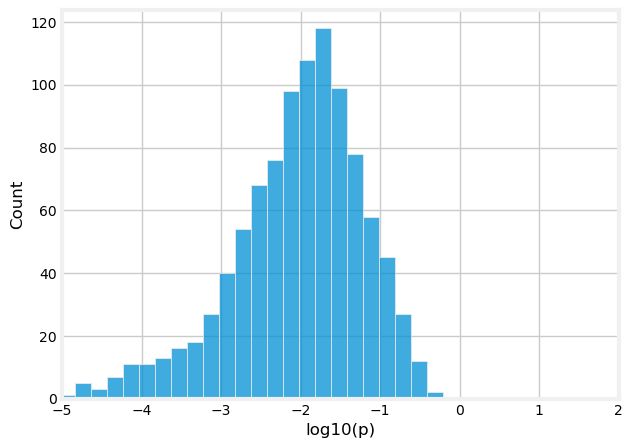

In [104]:
tmp2 = np.log10(pd.Series(sigeta).sample(frac=0.01))
sns.histplot(tmp2)

plt.xlim(-5, 2);
plt.xlabel("log10(p)");

In [105]:
del Xm, lift, inter, sigeta

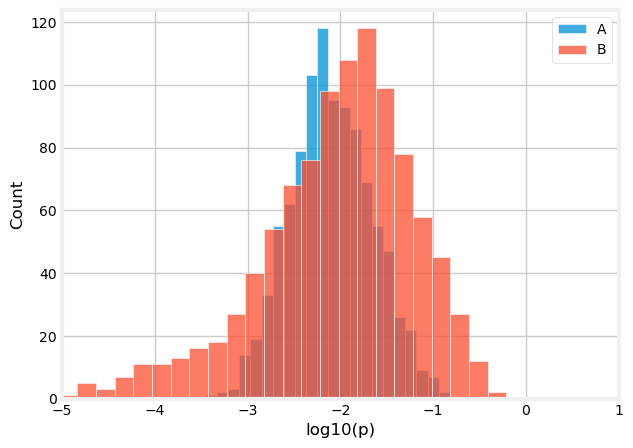

In [106]:
sns.histplot(tmp1, label="A")
sns.histplot(tmp2, label="B")

plt.xlim(-5, 1)
plt.xlabel("log10(p)");
plt.legend();

del tmp1, tmp2

### Modeling Contribution Change

We now proceed to model the change $\Delta$ in contributions, as a percentage of the income. We will model them as draws from a log normal:

$\ln\Delta \sim \mathcal{N}(\mu_{\ln}, \sigma_{\ln})$.

This has the following properties:

$\mathrm{mean}[\ln \Delta] = \mathbb{E}[\ln\Delta] = \mu_{\ln}$,

$\mathrm{median}[\Delta] = e^{\mu_{\ln}} \Rightarrow \ln(\mathrm{median}[\Delta]) = \mu_{\ln}$,

$\mathrm{mean}[\Delta] = \mathbb{E}[\Delta] = e^{\mu_{\ln} + \frac{1}{2} \sigma_{\ln}^2} \Rightarrow \ln(\mathbb{E}[\Delta]) = \mu_{\ln} + \frac{1}{2} \sigma_{\ln}^2$,

$\mathrm{Var}(\ln \Delta) = \sigma_{\ln}^2$

(_i.e._, $\sigma_{\ln}^2$ is the variance unaccounted for by the covariates).

In all likelihood the covariates $\mathbf{X}$ should influence $\mu_{\ln}$, so that we should have instead:

$\ln\Delta_i \sim \mathcal{N}(\mu_{\ln,i}, \sigma_{\ln})$,

where we can model the mean $\mu_{\ln,i}$ for _each_ user as:

$\mu_{\ln,i} = \alpha_0 + \boldsymbol\alpha \mathbf{X}_i + \varepsilon_i$,

where $\varepsilon_i \sim \mathcal{N}(0, \sigma_{\ln})$ the noise. Thus:

$\mathrm{Var}(\ln \Delta) = \mathrm{Var}(\boldsymbol\alpha \mathbf{X}) + \sigma_{\ln}^2$.

Like in the case of modeling the conversion, let us begin by ignoring the noise and focusing instead in the deterministic model.

We can easily see that:

$\alpha_j = \frac{d \ln \Delta}{d X_j} \approx \frac{\delta (\Delta) / \Delta}{\delta X_j}$

(we temporarily use $\delta y$ as "small increment in $y$"; apologies about the notation)

In [107]:
def alpha_j(dlnd, dXj):
    """
    Compute a simple linear coefficient alpha_j.

    Args:
        dlnd (float): Change in log-odds (or dependent variable).
        dXj (float): Change in predictor variable X_j.

    Returns:
        float: Linear coefficient alpha_j.
    """

    return dlnd/dXj

For $\alpha_0$ things are a bit more complicated. Having computed $\boldsymbol\alpha$, we can find $\alpha_0$ by solving:

$\mu_{\ln} \approx \hat{\mu}_{\ln} = \langle \ln\Delta \rangle = \frac{1}{N} \sum\limits_{i=0}^{N} \ln\Delta_i = \alpha_0 + \frac{1}{N} \sum\limits_{i=1}^{N} \boldsymbol\alpha X_i$,

$\Rightarrow \alpha_0 = \mu_{\ln} - \frac{1}{N} \sum\limits_{i=1}^{N} \boldsymbol\alpha X_i$

We first define the function that computes $\ln\Delta(X)$:

In [108]:
# rough scale of ln of the contributions growth (assumed ~2%)
lnd_scale = np.abs(np.log(0.02))

# computing ln delta = alpha_0 + alpha_j*X_j
def lndelta_fn(alphaj_alpha0, Xmatrix, noise=False, noise_sigma=0.1*lnd_scale, random_state=1):
    """
    Compute the log-change (ln delta) of contributions using a linear model.

    ln delta = alpha0 + sum(alpha_j * X_j), optionally with Gaussian noise.

    Args:
        alphaj_alpha0 (tuple): Tuple containing array-like alphas and scalar alpha0.
        Xmatrix (DataFrame): Feature matrix with columns corresponding to alphas.
        noise (bool, optional): Whether to add Gaussian noise. Defaults to False.
        noise_sigma (float, optional): Standard deviation of noise. Defaults to 0.1 * lnd_scale.
        random_state (int, optional): Seed for random number generation. Defaults to 1.

    Returns:
        float or ndarray: Log-change(s) of contributions.
    """
    
    alphas, alpha0 = alphaj_alpha0 # splitting the alphas

    # alpha_j*X_j
    alphaX = Xmatrix.mul(alphas, axis=1).to_numpy()
    
    # sum(alpha_j*X_j)
    covars = np.sum(alphaX, axis=1)

    # ln delta = alpha*X + alpha0
    lnd = covars + alpha0

    # trying different lengths
    try:
        n = len(lnd)
    except TypeError:
        n = 1

    # add noise (default is 10% of a ~1% scale of increments)
    if noise:
        rng = np.random.default_rng(seed=random_state)
        lnd_arr = rng.normal(loc=0., scale=noise_sigma, size=n)
        lnd += lnd_arr

    if len(lnd) == 1:
        return float(lnd[0])
    else:
        return lnd

Now we define the $\alpha_0$:

In [109]:
def alpha0_fn(target_muln, alphas, Xmatrix, **mu_kwargs):
    """
    Compute the intercept (alpha0) for a contributions growth model.

    Solves for alpha0 such that the population mean of ln delta matches the target multiplier.

    Args:
        target_muln (float): Desired average log-change (ln delta) across the population.
        alphas (array-like): Coefficients for predictor variables.
        Xmatrix (DataFrame): Feature matrix corresponding to alphas.
        **mu_kwargs: Additional arguments passed to `lndelta_fn` (e.g., noise, noise_sigma, random_state).

    Returns:
        float: Intercept alpha0 for the contributions growth model.
    """

    # alpha_j* X_ij
    alphaX_i = lndelta_fn((alphas, 0), Xmatrix, **mu_kwargs)

    # result
    a0 = target_muln - np.mean(alphaX_i)

    return a0

#### A: Baseline/Control

We now define the coefficients $\boldsymbol\alpha$ for the baseline model; remember: conditioned upon they having converted! (so no need to consider their age or how recently they have checked in their account, etc.).

Recall

$\alpha_j = \frac{d \ln \Delta}{d X_j} \approx \frac{\delta (\Delta) / \Delta}{\delta X_j}$.

In [110]:
alpha_coeffs_base = {}

# income [increase = one order of magnitude]:
# one order of magnitude a year in income more increases the relative contribution growth by 50%
# EXPLANATION: earning $1M more will want to make us growth the contribution by a factor of e
alpha_coeffs_base['log10_income'] = alpha_j(0.5, 1)

# balance [increase = one order of magnitude]
# one more order of magnitude in the balance decreases the relative contribution growth by 20%
alpha_coeffs_base['log10_retirement_balance'] = alpha_j(-0.2, 1)

# current_pct threshold
# if current_pct > 7% (the mode of employee contributions), the relative contribution growth decreases by 50%
# EXPLANATION: it starts to feel like a lot
alpha_coeffs_base['current_pct_above_7pp'] = -0.5

# employer matching
# if current_pct > employer_cap, the relative contribution growth decreases by 50%
alpha_coeffs_base['current_pct_above_employer_cap'] = -0.5

alpha_coeffs_base = pd.Series(alpha_coeffs_base)

In [111]:
alpha_coeffs_base

log10_income                      0.5
log10_retirement_balance         -0.2
current_pct_above_7pp            -0.5
current_pct_above_employer_cap   -0.5
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix`:

In [112]:
def X_features_alpha_base(data):
    """
    Construct a feature matrix for base contributions growth modeling.

    Features include log-transformed income and retirement balance, and binary indicators for contribution thresholds.

    Args:
        data (DataFrame): Input dataset containing columns:
            'income', 'retirement_balance', 'current_pct', 'employer_cap'.

    Returns:
        DataFrame: Feature matrix suitable for contributions growth modeling.
    """

    Xmatrix = pd.DataFrame()
    
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    return Xmatrix

Example computation:

In [113]:
Xm = X_features_alpha_base(full_data)

display(Xm)

log10_income  log10_retirement_balance  current_pct_above_7pp  \
0          5.484336                  5.571149                      1   
1          4.634762                  3.826077                      1   
2          5.435693                  5.833002                      1   
3          4.676419                  4.057175                      1   
4          5.291114                  4.178681                      1   
...             ...                       ...                    ...   
99995      4.881781                  6.507023                      1   
99996      5.074892                  5.980479                      1   
99997      5.620824                  6.674789                      1   
99998      5.227239                  6.167831                      1   
99999      5.125956                  5.404444                      1   

       current_pct_above_employer_cap  
0                                   1  
1                                   1  
2                                   0  
3                                   0  
4                                   1  
...                               ...  
99995                               1  
99996                               1  
99997                               1  
99998                               1  
99999                               1  

[100000 rows x 4 columns]

We can then compute $\alpha_0$, assuming a mean of $\ln\Delta$ of 1%:

In [114]:
inter = alpha0_fn(np.log(1), alpha_coeffs_base, Xm) # expected value of ln(1%)
print(inter)

-0.8193746370053621


From that we can compute $\ln\Delta = \boldsymbol\alpha \mathbf{X} + \alpha_0$:

In [115]:
lnds = lndelta_fn((alpha_coeffs_base, inter), Xm)

print(lnds)
print(np.mean(lnds))
print(np.std(lnds, ddof=1))

[-0.19143616 -0.26720908  0.23187157 ... -0.34392046 -0.43932161
 -0.3372857 ]
3.694822225952521e-17
0.3459197552772767


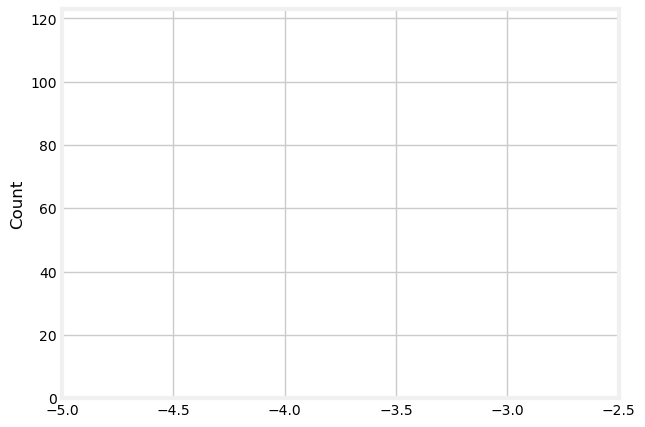

In [116]:
sns.histplot(pd.Series(lnds).sample(frac=0.01))

plt.xlim(-5, -2.5);

Looking at the $\Delta$s instead:

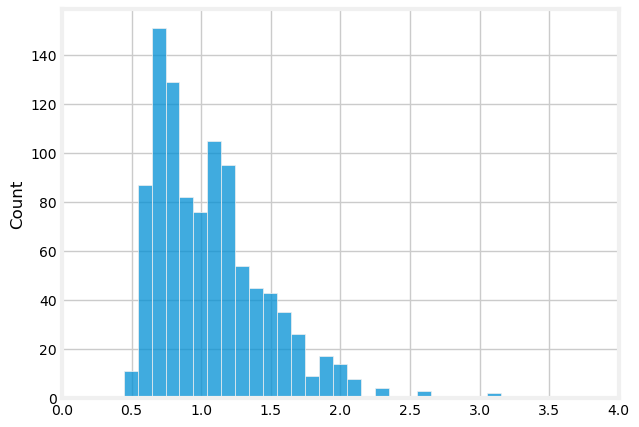

In [117]:
ds = np.exp(lnds)

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 4);

But typically we round up the contributions to the neares 0.25%:

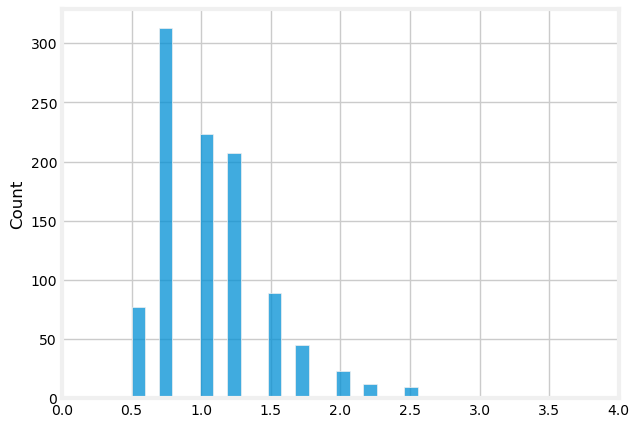

In [118]:
ds = np.round(ds*4)/4

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 4);

In [119]:
del lnds, ds

#### B: Treatment

Let us now model the changes to the coefficients $\boldsymbol\alpha$ for the treatment:

In [120]:
alpha_coeffs_treat = alpha_coeffs_base.copy()

# age [increase = 10 years]:
# treatment boosts relative contribution growth by 20% for every 10 years *younger*
alpha_coeffs_treat['age'] = alpha_j(-0.2, 10)

# income [increase = one order of magnitude]:
# treatment boosts relative contribution growth by 20% for every order of magnitude more in income
alpha_coeffs_treat['log10_income'] += alpha_j(0.2, 1)

# balance [increase = one order of magnitude]
# treatment boosts relative contribution growth by 10% for every order of magnitude more in balance
alpha_coeffs_treat['log10_retirement_balance'] += alpha_j(0.1, 1)

Compare the treatment coefficients:

In [121]:
alpha_coeffs_treat

log10_income                      0.70
log10_retirement_balance         -0.10
current_pct_above_7pp            -0.50
current_pct_above_employer_cap   -0.50
age                              -0.02
dtype: float64

With the baseline/control:

In [122]:
alpha_coeffs_base

log10_income                      0.5
log10_retirement_balance         -0.2
current_pct_above_7pp            -0.5
current_pct_above_employer_cap   -0.5
dtype: float64

Let us now define a function that takes the population data and applies to it the necessary transformations to turn it into the feature matrix `Xmatrix`:

In [123]:
def X_features_alpha_treat(data):
    """
    Construct a feature matrix for treatment contributions growth modeling.

    Includes base features (log-transformed income and retirement balance, and binary contribution indicators) plus age.

    Args:
        data (DataFrame): Input dataset containing columns:
            'income', 'retirement_balance', 'current_pct', 'employer_cap', 'age'.

    Returns:
        DataFrame: Feature matrix suitable for contributions growth modeling with treatment features.
    """

    Xmatrix = pd.DataFrame()
    
    Xmatrix['log10_income'] = np.log10(data['income'])
    Xmatrix['log10_retirement_balance'] = np.log10(data['retirement_balance'])
    
    Xmatrix['current_pct_above_7pp'] =\
        (data['current_pct'] > 0.07).astype(int)
    
    Xmatrix['current_pct_above_employer_cap'] =\
        (data['current_pct'] >= data['employer_cap']).astype(int)

    Xmatrix['age'] = data['age']

    return Xmatrix

Example computation:

In [124]:
Xm = X_features_alpha_treat(full_data)

display(Xm)

log10_income  log10_retirement_balance  current_pct_above_7pp  \
0          5.484336                  5.571149                      1   
1          4.634762                  3.826077                      1   
2          5.435693                  5.833002                      1   
3          4.676419                  4.057175                      1   
4          5.291114                  4.178681                      1   
...             ...                       ...                    ...   
99995      4.881781                  6.507023                      1   
99996      5.074892                  5.980479                      1   
99997      5.620824                  6.674789                      1   
99998      5.227239                  6.167831                      1   
99999      5.125956                  5.404444                      1   

       current_pct_above_employer_cap        age  
0                                   1  39.810884  
1                                   1  32.272183  
2                                   0  73.205175  
3                                   0  19.723169  
4                                   1  43.773998  
...                               ...        ...  
99995                               1  54.167157  
99996                               1  62.087154  
99997                               1  46.574877  
99998                               1  58.181908  
99999                               1  59.588628  

[100000 rows x 5 columns]

We can then compute $\alpha_0$, assuming a boost from 1% to 3% contribution increments:

In [125]:
inter = alpha0_fn(np.log(3), alpha_coeffs_treat, Xm)
print(inter)

-0.24084668300060552


From that we can compute $\ln\Delta = \boldsymbol\alpha \mathbf{X} + \alpha_0$:

In [126]:
lnds = lndelta_fn((alpha_coeffs_treat, inter), Xm)

print(lnds)
print(np.mean(lnds))
print(np.std(lnds, ddof=1))

[1.24485625 0.97543531 1.01673482 ... 1.09475369 0.63779903 0.61510523]
1.0986122886681098
0.5262104190610737


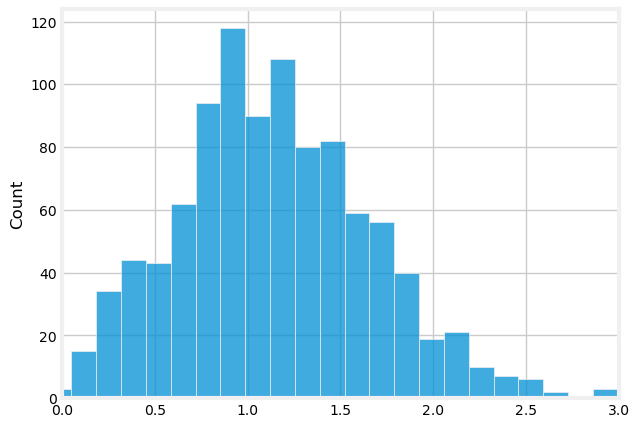

In [127]:
sns.histplot(pd.Series(lnds).sample(frac=0.01))

plt.xlim(0, 3);

Looking at the $\Delta$s instead:

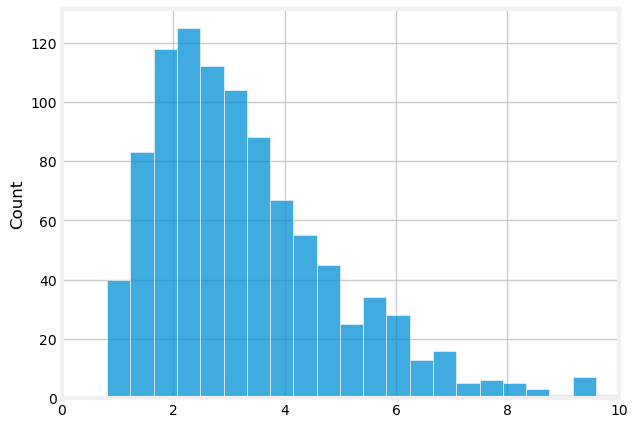

In [128]:
ds = np.exp(lnds)

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 10);

Rounding up to the neares 0.25%:

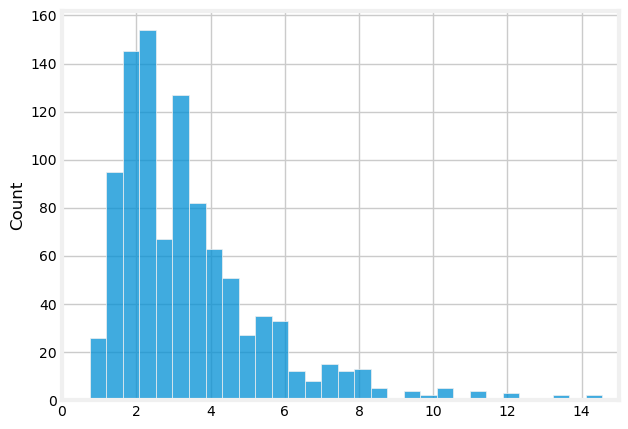

In [129]:
ds = np.round(ds*4)/4

sns.histplot(pd.Series(ds).sample(frac=0.01))

plt.xlim(0, 15);

In [130]:
del lnds, ds

### Experiment

We now devise the experiment. The recipe:

1. We compute the size $n = n_A = n_B$ of each of the arms based on our previous knowledge of $p_0$ ($= p_A$), what we want for the Type I and II errors ($\alpha$ and $\beta$), and the MDE $\Delta = p_B - p_A$ we want. Compute power curve ($n$ vs. $p_A$, taken to vary accross $2\sigma$ (_i.e._ $\pm p_A(1-p_A)$)).

2. We highlight the secondary metric (the increase $\Delta$ in contributions), and any guardrail metrics to monitor.

3. We simulate the experiment: take the population and randomly assign either A or B to $2 n$ members of it, by hashing the user id. We can do the experiment once and for all, or simulate a 10%-25%-50%-100% roll-out. At any rate, we simply create two new tables, one for each group. The table for A has extra information about when and how it was nudged. Regardless, the point is that each element has a probability $p_i$, taken from our conversion model, of converting, and thus there is a Bernoulli process associated to each element. Note that we add a little bit of noise to create $p_i$ (it's not deterministic). There is also $\Delta_i$ for each, also with some noise in $\mu$ (but not in $\sigma$).

4. We perform the analysis, compute the SE and CI

#### Experiment Design

We are interested in designing an experiment that tests whether we can observe any uplift in the conversion rate ("user decides to increase retirement contributions").

Here are some important terms:

- **RCT (Randomized Controlled Trial):** this A/B experiment.
- **ATE (Average Treatment Effect):** effect of actual treatment.
- **ITT (Intention-To-Test):** effect of assignment (policy lever). ITT = ATE if there is perfect compliance (assignment = receipt)
- **CACE (Complier Average Causal Effect):** effect among those who receive treatment if there is noncompliance
- **CATE (Aonditional ATE)** the ATE conditional on covariates.
- **HTE (Heterogeneous Treatment Effects):** how the treatment effect varies across individuals or subgroups. Basically, the CATE when conditioning on groups.

Here are some important quantities:

- **Primary metric ITT:** $\mathbb{E}[Y | Z = 1] - \mathbb{E}[Y | Z = 0] = p_B - p_A$, where $Y$ is "yes, user converted" (got a 1 in its Bernoulli trial to increase contribution), and $Z = 0/1$ is "received treatment/did not receive treatment".
- **Primary metric ATE:** estimates the ITT, and is the difference in sample conversion rates: $\hat{d} \equiv \hat{p}_B - \hat{p}_A$.
- **Secondary metric:** $\mathbb{E}[\Delta | Z = 1] - \mathbb{E}[\Delta | Z = 0] = \mu_{\ln,A} - \mu_{\ln,B}$. Possible additional ITT if we can power enough. We estimate it (secondary ATE) as $\hat{m} \equiv \hat{\mu}_{\ln,A} - \hat{\mu}_{\ln,B} = \langle \ln \Delta_B \rangle - \langle \ln \Delta_A \rangle$.
- **Type I and II errors:** $\alpha = 0.05$, $\beta = 0.2$.
- **MDE (Minimum Detectable Effect):** ($\delta$) the smallest primary ATE which we define as actionable. If it is positive, it is also called the _(up)lift_. We will take it to be $\delta \approx 2 \%$ (a lift of 2%), but we will vary it.

##### Arm Size

Based on $\alpha$, $\beta$, and required $\delta$, we can find $n_A = n_B = n$:

$n = \frac{\left( z_{1-\alpha/2} \sqrt{2\overline{p}(1 - \overline{p})} + z_{1 - \beta} \sqrt{p_B (1 - p_B) + p_A (1 - p_A)} \right)^2}{\delta^2}$,

where

$\overline{p} = (p_A + p_B)/2 = p_A + \delta/2$ is the pooled conversion probability.

If we are interested in powering the difference in means of the continuous variables as well, $m = \mu_B - \mu_A$, we need

$n \approx \frac{2 \, (z_{1 - \alpha/2} + z_{1 - \beta})^2 \, \sigma_{\Delta}^2}{m^2}$,

where $\sigma_{\Delta}$ is the variance of the $\Delta$'s, assumed to be the same in both arms. Conservatively, we can take $\sigma_{\Delta} = \max(\sigma_{\Delta,A}, \sigma_{\Delta,B})$.
**N.B.:** Here $\mu_X$ and $\sigma_\Delta$ are the mean and std, respectively, of the $\Delta$ _of the true underlying PDF_ (for large $N$, the same as those _of the entire population_, including conversions AND non-conversions). In other words they are _different_ from the mean and std of the **log**-normal distribution, which was conditioned upon conversion: $\mu_X \neq \mu_{\ln,X}$, and $\sigma_\Delta \neq \sigma_{\ln}$.

In [131]:
from scipy.stats import norm, t as student_t

In [132]:
def n_per_arm_diff_props(pA, pB, alpha=0.05, power=0.80):
    """
    Compute per-arm sample size for detecting a difference in proportions.

    Uses a two-sided z-test with specified significance level and power.

    Args:
        pA (float): Conversion rate in control group.
        pB (float): Conversion rate in treatment group.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired power. Defaults to 0.80.

    Returns:
        float: Required sample size per arm.
    """
    
    beta = 1 - power # Type II error rate

    z_a = norm.ppf(1 - alpha/2) # z_{1 - alpha/2}

    z_b = norm.ppf(1 - beta) # z_{1-beta}
    
    pbar = 0.5*(pA + pB) # pooled conversion rate

    # numerator
    num = (z_a*np.sqrt(2*pbar*(1-pbar)) + z_b*np.sqrt(pA*(1-pA)+pB*(1-pB)))**2

    # denominator
    den = (pB - pA)**2

    # number of samples per arm
    n = num/den
    
    return n



def n_per_arm_diff_means(delta, sigma2, alpha=0.05, power=0.8):
    """
    Compute per-arm sample size for detecting a difference in means.

    Assumes equal variance per group and equal allocation between groups.

    Args:
        delta (float): Difference in means to detect (muB - muA).
        sigma2 (float): Assumed variance per group.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired power. Defaults to 0.80.

    Returns:
        float: Required sample size per arm.
    """

    beta = 1 - power # Type II error rate

    z_a = norm.ppf(1 - alpha/2) # z_{1 - alpha/2}

    z_b = norm.ppf(1 - beta) # z_{1-beta}
    
    num = 2 * (z_a + z_b)**2 * sigma2
    
    den = delta**2
    
    return num / den

Given a baseline $p_0$ with variance $p_0 (1-p_0)$, we can make a power curve by varying the estimated $\hat{p}_0$ of a population of size $N$ over its standard error $\hat{\mathrm{SE}}$ for a given $\delta$ and power specification.

**NOTE:** the variance above is the variance in a single Bernoulli trial, NOT the standard error of the estimated proportion. The standard error is

$\hat{\mathrm{SE}} = \sqrt{\hat{p}_0 (1-\hat{p}_0) / N}$

by the CLT.

In [133]:
std = np.sqrt(pstar*(1-pstar))/1_000 # assuming 1,000 points of historical data
lift = 0.02

parr = np.linspace(np.min(pstar-1*std,0), pstar+2*std, 101)
narr = n_per_arm_diff_props(parr, parr + lift, alpha=0.05, power=0.90)

plt.plot(parr, narr)

del std, lift, parr, narr

##### Confidence Intervals

We can build the confidence intervals:

$\hat{d} \pm z_{1 - \alpha/2} \hat{\mathrm{SE}}$,

where

$\hat{SE} = \sqrt{\frac{\hat{s}_A^2}{n_A} + \frac{\hat{s}_B^2}{n_B}}$

and $\hat{s}_X^2$ the sample variance of the proportions:

$\hat{s}_X^2 = \frac{1}{N-1}\sum\limits_{i=1}^N (\text{(Y or N)} - \hat{p}_X)^2 \approx \hat{p}_X (1 - \hat{p}_X)$.

Similarly for the continuous secondary metric.

In [134]:
def props_diff_CI(xA, xB, alpha=0.05):
    """
    Compute the difference in proportions and its confidence interval.

    Args:
        xA (array-like): Binary outcomes for group A.
        xB (array-like): Binary outcomes for group B.
        alpha (float, optional): Significance level. Defaults to 0.05.

    Returns:
        tuple: (Difference in proportions, lower and upper bounds of CI)
    """

    nA, nB = len(xA), len(xB)
    
    hat_pA, hat_pB = np.sum(xA)/nA, np.sum(xB)/nB
    
    hat_d = hat_pB - hat_pA
    
    hat_se = np.sqrt(hat_pA*(1-hat_pA)/nA + hat_pB*(1-hat_pB)/nB)
    
    z_crit = norm.ppf(1 - alpha/2.0)
    
    return hat_d, (hat_d - z_crit*hat_se, hat_d + z_crit*hat_se)



def welch_df(s1_sq, s2_sq, n1, n2):
    """
    Compute the Welch-Satterthwaite degrees of freedom for unequal variances.

    Args:
        s1_sq (float): Variance of group 1.
        s2_sq (float): Variance of group 2.
        n1 (int): Sample size of group 1.
        n2 (int): Sample size of group 2.

    Returns:
        float: Approximate degrees of freedom for Welch's t-test.
    """
    
    num = (s1_sq/n1 + s2_sq/n2)**2
    
    den = (s1_sq**2)/((n1**2)*(n1-1)) + (s2_sq**2)/((n2**2)*(n2-1))
    
    return num/den



def means_diff_CI(YA, YB, alpha=0.05, use_tdist=False):
    """
    Compute the difference in means and its confidence interval.

    Can use either normal approximation or Welch's t-distribution for CI.

    Args:
        YA (array-like): Observations for group A.
        YB (array-like): Observations for group B.
        alpha (float, optional): Significance level. Defaults to 0.05.
        use_tdist (bool, optional): Use Welch's t-distribution for CI. Defaults to False.

    Returns:
        tuple: (Difference in means, lower and upper bounds of CI, degrees of freedom if t-dist used)
    """

    
    nA, nB = len(YA), len(YB)
    
    hat_mA, hat_mB = YA.mean(), YB.mean()
    
    hat_vA, hat_vB = YA.var(ddof=1), YB.var(ddof=1)
    
    hat_se = np.sqrt(hat_vA/nA + hat_vB/nB)

    if use_tdist:
        df = welch_df(vA, vB, nA, nB)
        crit = student_t.ppf(1 - alpha/2.0, df)

    else:
        df = None
        crit = norm.ppf(1 - alpha/2.)
    
    hat_nu = hat_mB - hat_mA
    
    return hat_nu, (hat_nu - crit*hat_se, hat_nu + crit*hat_se), df

##### Randomization

We now define the randomization function:

In [135]:
def ab_randomize(n_arm, all_ids, random_state=1):
    """
    Randomly assign IDs to two experimental arms.

    Selects 2*n_arm IDs from all_ids and splits them into two groups of size n_arm.

    Args:
        n_arm (int): Number of samples per experimental arm.
        all_ids (array-like): Pool of available IDs.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.

    Returns:
        tuple: Two arrays containing IDs assigned to arm A and arm B.
    """

    rng = np.random.default_rng(seed=random_state)
    test_ids = rng.choice(all_ids, size=2*n_arm, replace=False)

    rng = np.random.default_rng(seed=random_state)
    ids_A = rng.choice(test_ids, size=n_arm, replace=False)
    ids_B = np.array(list(set(test_ids) - set(ids_A)))

    return ids_A, ids_B

#### Experiment Simulation

We now proceed to simulate the experiment.

In [136]:
from scipy.stats import bernoulli

##### User Response

Let us begin by defining a function that computes the user response (_i.e._ performs the bare bones of the experiment) for a given dataset.

In [137]:
def experiment_fn(binary_true, cont_true, data, b0_a0=(None, None), random_state=1, intercepts=False):
    """
    Simulate an A/B-style experiment with binary conversion and continuous contribution outcomes.

    The binary outcome models conversion (Y/N) using logistic regression, while the continuous outcome models contribution growth for converters.

    Args:
        binary_true (float): Target population conversion rate.
        cont_true (float): Target average contribution growth for converters.
        data (DataFrame): Input dataset containing necessary feature columns.
        b0_a0 (tuple, optional): Pre-specified intercepts (b0, a0) for binary and continuous models.
            Defaults to (None, None) to compute intercepts automatically.
        random_state (int, optional): Seed for random number generation. Defaults to 1.
        intercepts (bool, optional): Whether to return the computed intercepts. Defaults to False.

    Returns:
        DataFrame: Simulated dataset with columns 'conv_rate', 'converted', 'delta_pct', 'new_pct'.
        dict (optional): Dictionary of intercepts if `intercepts=True`.
    """

    # splitting intercepts:
    b0, a0 = b0_a0

    # begin with the binary part
    X_props = X_features_beta_base(data) # feature matrix
    if b0 == None:
        b0 = beta0_fn(binary_true, beta_coeffs_base, X_props) # intercept
    prob_i = sigma_fn((beta_coeffs_base, b0), X_props) # Bernoulli prob
    conv = bernoulli.rvs(p=prob_i, random_state=(random_state)) # convert Y/N?

    # find the indices where there was a conversion
    idx_conv = np.where(conv == 1)[0]

    # addt'l contributions
    X_means = X_features_alpha_base(data) # feature matrix
    # for contributions, we are interested only on those converted
    X_means = X_means.iloc[idx_conv]
    
    if a0 == None:
        a0 = alpha0_fn(cont_true, alpha_coeffs_base, X_means) # intercept
    DiA = np.exp(lndelta_fn((alpha_coeffs_base, a0), X_means)) # contribution growth
    DiA = np.round(DiA*4)/4 # rounding to nearest 0.25%

    # defining the result dataframe
    df = data.copy()

    # conversion rate
    df['conv_rate'] = prob_i

    # converted?
    df['converted'] = conv
    
    # additional contributions
    df['delta_pct'] = 0. # default is 0
    addtl_idx = df.columns.get_loc('delta_pct')
    df.iloc[idx_conv,addtl_idx] = DiA # locating those that converted

    # new contributions
    df['new_pct'] = df['current_pct'] + df['delta_pct']

    if intercepts:
        return df, {'binary_intercept':b0, 'cont_intercept':a0}
    else:
        return df

In [138]:
# test = experiment_fn(pstar, np.log(2.), full_data, b0_a0=(None, None), random_state=1, intercepts=False)

# del test

##### Metrics

We now define a dictionary of important metrics:

_conversion rates_

`exper_binary_metric = {'baseline_true':[ true baseline conversion rate ],
                 'treatment_true':[ true treatment conversion rate ],
                 'MDE':[ minimum detectable effect in conversion rate]}`

_contributions growth_

`exper_continuous_metric = {'baseline_true':[ true baseline mean of logs ],
                     'treatment_true':[ true treatment mean of logs ],
                     'MDE':[ minimum detectable effect in mean of logs ]}`

For example, this:

In [139]:
# conversion rates
exper_binary_metric = {'baseline_true':(1.35/100), # 1.35% (not necessarily reference pstar!)
                       'treatment_true':(1.35 + 2.5)/100, # 3.85%
                       'MDE':2/100} # 2%

# contributions growth
exper_continuous_metric = {'baseline_true':np.log(1.5), # 1.5%
                           'treatment_true':np.log(3), # 3%
                           'MDE':1} # +1% over baseline --> 1.5% --> 2.5% [NOT LOGS]

##### Costs and Fees

We define some commonly used parameters:

In [140]:
# typical flat cost (overhead) per day
# team of 3 people $100k/year, working 0.25 FTE on this project (i.e. 1/4 the work day)
typical_flat_cost_per_day = (0.25*3*100_000/12/30)

# typical fees for AUM
# weighted average of 0.07% for indices, and 0.11% for active funds. Assume $8.3T in indices, and $1.8T in active funds
# typical_management_fees=((0.07*8.3)+(0.11*1.8))/(8.3+1.8)/100
typical_management_fees=0.07/100

##### Arm Size of Continuous Secondary Metric is Important

We now define another useful function: computing the size of each arm if we are interested in _also_ detecting the MDE in the (continuous) mean of the log of the additional contributions:

In [141]:
def n_arm_cont_historical(primary_metric, secondary_metric, data, alpha=0.05, power=0.8, cushion=0.1, random_state=1):
    """
    Estimate per-arm sample size for a continuous metric using historical data.

    Accounts for conversion conditioning and the population-level variance of additional contributions. Applies a cushion to ensure robustness.

    Args:
        primary_metric (dict): Contains 'baseline_true' conversion rate.
        secondary_metric (dict): Contains 'baseline_true' mean contribution
            (conditioned on conversion) and 'MDE' (minimum detectable effect).
        data (DataFrame): Input dataset for simulation.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired power. Defaults to 0.8.
        cushion (float, optional): Extra padding on sample size. Defaults to 0.1.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.

    Returns:
        int: Estimated number of samples per arm to detect the target effect.
    """

    # extracting the true proportions
    true_pA = primary_metric['baseline_true']

    # extracting the true means (of log-normal, i.e. conditioned on conversion)
    true_mulnA = secondary_metric['baseline_true']

    # extracting the MDE (conditioned on conversion)
    mde_ITT_cond = secondary_metric['MDE'] # MDE on the means of Delta, conditioned on conversion

    # but to power the size of the arms to detect an effect on the *population* means of Delta, we need to multiply our ITT MDE by the prevalence of conversions. Conservatively, and based only on historical parameters we know, we must then use true_pA:
    mde_ITT = mde_ITT_cond*true_pA

    # we can now compute the historical data (just do the entire population)
    hist_data = experiment_fn(true_pA,
                              true_mulnA,
                              data,
                              b0_a0=(None, None),
                              random_state=(3*random_state),
                              intercepts=False)

    # conditioning on conversion
    hist_conv_data = hist_data[hist_data['converted'] == 1]

    # CHECKS:
    # (1) the conversion proportion estimator should be close to true rate
    assert np.isclose((np.mean(hist_data['converted'])/true_pA),
                      1,
                      rtol=0.1)

    # (2) the estimator of the mean of the logs of the addt'l contributions should be close to true value
    assert np.isclose(np.mean(np.log(hist_conv_data['delta_pct']))/true_mulnA,
                      1,
                      rtol=0.1)

    # sample mean of the deltas, conditioned on conversion
    mean_conv = np.mean(hist_conv_data['delta_pct'])
    
    # sample variance of the deltas, conditioned on conversion
    sigma_conv2 = np.var(hist_conv_data['delta_pct'], ddof=1)

    # full (i.e. universal) variance of Deltas
    # Var(Delta) = p*s^2 + p(1-p)*m^2
    # = (within-converter variance contribution (averaged over the fraction p who convert)) + (between-converter vs non-converter variance (the variance due to mixing converters of mean m with non-converters at 0))
    p = np.mean(hist_data['converted'])
    sigma_ITT2 = p*sigma_conv2 + p*(1-p)*mean_conv**2
    # sigma_ITT2 = true_pA*sigma_conv2 + true_pA*(1-true_pA)*mean_conv**2

    # full (i.e. universal) variance of Deltas
    sigma_delta2 = np.var(hist_data['delta_pct'], ddof=1)

    # print(sigma_ITT2)
    # print(sigma_delta2)
    # print(sigma_ITT2/sigma_delta2)

    # size of arm required to detect MDE in mean of log of addt'l contributions
    cont_n_arm = n_per_arm_diff_means(mde_ITT,
                                      sigma_ITT2,
                                      alpha=alpha,
                                      power=power)
    
    # padding with cushion, and converting to integer
    cont_n_arm = int(cont_n_arm*(1+cushion))

    return cont_n_arm

In [142]:
n_arm_cont_historical(exper_binary_metric, exper_continuous_metric, full_data, power=0.9)

5062

**N.B.:** a larger number! (due to the smallness of the conversion rate!)

##### Rollout Schedule

A few simple functions that assign rollout dates to the experiment subjects.

In [143]:
from datetime import datetime, timedelta

In [144]:
def rollout_schedule(indices,
                     rollouts=[0.10, 0.15, 0.25],
                     start_date=datetime(2025, 9, 3),
                     delta_days=2):
    """
    Generate a staged rollout schedule for a set of indices.

    Divides the indices into sequential groups based on specified proportions, assigning each group a rollout date starting from `start_date` and incremented by `delta_days`.

    Args:
        indices (array-like): IDs or indices to be rolled out.
        rollouts (list of float, optional): Proportions for each rollout stage.
            Defaults to [0.10, 0.15, 0.25].
        start_date (datetime, optional): Date of first rollout. Defaults to 2025-09-03.
        delta_days (int, optional): Days between successive rollouts. Defaults to 2.

    Returns:
        dict: Mapping from group number to a tuple (rollout_date, indices in group).
    """
    
    N = len(indices) # length of data
    sizes = [int(np.floor(p*N)) for p in rollouts] # size of each rollout
    sizes.append(N - sum(sizes)) # remainder

    rollout_groups = {}
    rollout_date = pd.to_datetime(start_date)
    
    start = 0
    for gp, s in enumerate(sizes):
        
        rollout_groups[gp+1] =\
                (rollout_date, indices[start:start+s])
        
        start += s
        rollout_date += timedelta(days=delta_days)
    
    return rollout_groups

##### Group-wise Experiments

We define a helper function that performs the experiment per group.

In [145]:
def groupwise_experiment(true_binary,
                         true_continuous,
                         arm_data,
                         b0_a0,
                         duration_experiment=30,
                         prep_time=30,
                         nudge_cost_per_user=0.001, # 0.1 cents
                         flat_cost_per_day=typical_flat_cost_per_day,
                         management_fees=typical_management_fees,
                         random_state=1):
    """
    Simulate a groupwise A/B experiment with conversion timing and ROI calculation.

    Generates conversion events over a specified duration, computes user and employer contribution growth, and calculates per-user ROI accounting for nudge and flat costs.

    Args:
        true_binary (float): Target conversion rate.
        true_continuous (float): Target contribution growth for converters.
        arm_data (DataFrame): Experimental arm data with necessary feature columns.
        b0_a0 (tuple): Intercepts for binary and continuous models.
        duration_experiment (int, optional): Number of days the experiment runs. Defaults to 30 days.
        prep_time (int, optional): Preparation time in days before experiment. Defaults to 30 days.
        nudge_cost_per_user (float, optional): Direct cost per user for nudges. Defaults to $0.001.
        flat_cost_per_day (float, optional): Daily fixed cost of running the experiment. Defaults to $12,500/30.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.

    Returns:
        DataFrame: Experimental results including conversion dates, delta AUM, and per-user ROI.
    """
    
    res_df = experiment_fn(true_binary,
                          true_continuous,
                          arm_data,
                          b0_a0=b0_a0,
                          random_state=random_state,
                          intercepts=False)

    # conversion date
    res_df['conversion_date'] = pd.NaT # default

    # indices of users with conversions
    conv_idx = res_df[res_df['converted'] == 1].index.to_list()

    # conversion dates

    rng = np.random.default_rng(random_state)   # reproducible global RNG
    # offsets in days: integers from 0..duration_experiment inclusive
    offsets = rng.integers(0, duration_experiment+1, size=len(res_df))
    offsets = pd.Series(offsets, index=res_df.index)
    
    # mask for converted users (assumes 'converted' column exists 0/1)
    mask = (res_df['converted'] == 1)
    # compute conversion dates only for converters
    res_df.loc[mask, 'conversion_date'] = (
        pd.to_datetime(res_df.loc[mask, 'assign_date'])
        + pd.to_timedelta(offsets[mask], unit='D'))

    # business value
    # increase in AUM from user (recall delta_pct is in %; need to divide by 100)
    res_df['user_delta_aum'] = (res_df['delta_pct']/100)*res_df['income']

    # increase in AUM from employer
    maximum_delta_employer = (res_df['employer_cap'] - res_df['current_pct']).clip(lower=0) # the largest the employer can grow

    employer_delta_pct = res_df['delta_pct'].combine(maximum_delta_employer, min) # employer's growth in contributions: the same as user or the most it can grow, whichever is smallest

    # once again, employer_delta_pct is in %;need to divide by 100
    res_df['employer_delta_aum'] = (employer_delta_pct/100)*res_df['income'] # increase in AUM due to employer

    # total increase in AUM
    res_df['total_delta_aum'] = res_df['user_delta_aum'] + res_df['employer_delta_aum']

    # total flat cost

    # earliest day in the experiment
    earliest_day = res_df['assign_date'].min() - timedelta(days=prep_time) # subtract a month of preparation

    # latest_day in the experiment
    latest_day = res_df['assign_date'].max() + timedelta(days=duration_experiment)

    # computing the flat cost per user
    num_users = 2*len(res_df) # anticipating the other arm
    flat_cost_per_user = (flat_cost_per_day*(latest_day - earliest_day).days)/num_users

    # returns
    res_df['revenue'] = res_df['total_delta_aum']*management_fees
    
    # ROI
    # costs only from nudging
    res_df['roi'] = res_df['revenue'] - nudge_cost_per_user
    # costs from experiment as well
    res_df['roi_exper'] = res_df['roi'] - flat_cost_per_user

    return res_df

##### Experiment Routine

We are ready to create the experimental routine

In [146]:
column_new_order = ['user_id',
 'rollout_group',
 'assign_date',
 'group',
 'age',
 'age_cohort',
 'income',
 'income_cohort',
 'net_worth',
 'networth_cohort',
 'retirement_balance',
 'balance_cohort',
 'current_pct',
 'employer_cap',
 'last_login',
 'acct_tenure',
 'time_online_frac',
 'conv_rate',
 'converted',
 'conversion_date',
 'delta_pct',
 'new_pct',
 'user_delta_aum',
 'employer_delta_aum',
 'total_delta_aum',
 'revenue',
 'roi_exper',
 'roi']

On to the experimental routine

In [147]:
def ab_experiment(primary_metric, secondary_metric, data,
                  largest_narm=False,
                  alpha=0.05, power=0.8,
                  cushion=0.1,
                  rollouts=[0.10, 0.15, 0.25],
                  start_date=datetime(2025, 9, 3),
                  delta_days=2,
                  duration_experiment=30,
                  prep_time=30,
                  nudge_cost_per_user=0.001, # 0.1 cents
                  flat_cost_per_day=typical_flat_cost_per_day,
                  management_fees=typical_management_fees,
                  random_state=1,
                  save_to_file=True):
    """
    Conduct a full A/B experiment simulation with binary and continuous outcomes.

    Randomizes users into arms, assigns rollout schedules, simulates conversions and contribution growth, and computes confidence intervals for primary and secondary metrics. Optionally saves results and experiment summary to files.

    Args:
        primary_metric (dict): Dictionary with keys 'baseline_true', 'treatment_true', 'MDE'.
        secondary_metric (dict): Dictionary with keys 'baseline_true', 'treatment_true', 'MDE'.
        data (DataFrame): Dataset containing user features and IDs.
        largest_narm (bool or int, optional): If True, ensure arm size accommodates secondary metric; if int, minimum arm size. Defaults to False.
        alpha (float, optional): Significance level. Defaults to 0.05.
        power (float, optional): Desired statistical power. Defaults to 0.8.
        cushion (float, optional): Extra padding on sample sizes. Defaults to 0.1.
        rollouts (list of float, optional): Proportions for staged rollout. Defaults to [0.10, 0.15, 0.25].
        start_date (datetime, optional): Start date for rollouts. Defaults to 2025-09-03.
        delta_days (int, optional): Days between rollout stages. Defaults to 2.
        duration_experiment (int, optional): Number of days each experiment runs. Defaults to 30 days.
        prep_time (int, optional): Days of preparation before experiment. Defaults to 30 days.
        nudge_cost_per_user (float, optional): Cost per user for nudges. Defaults to $0.001.
        flat_cost_per_day (float, optional): Daily fixed experiment cost. Defaults to $12,500/30.
        random_state (int, optional): Seed for reproducibility. Defaults to 1.
        save_to_file (bool, optional): Whether to save results and summary to file. Defaults to True.

    Returns:
        tuple: 
            - (hat_d, CI_d) Confidence interval for difference in conversion rates.
            - (hat_m, CI_m) Confidence interval for difference in additional contributions.
            - DataFrame: Full experiment results with conversion, contributions, and ROI.
    """


    #----------------------
    # Extracting parameters
    #......................

    # extracting the true proportions and MDE
    true_pA = primary_metric['baseline_true']
    true_pB = primary_metric['treatment_true']
    prop_mde = primary_metric['MDE']

    # extracting the true means and MDE
    true_mulnA = secondary_metric['baseline_true']
    true_mulnB = secondary_metric['treatment_true']
    cont_mde = secondary_metric['MDE']

    #----------------------
    # Computing arm sizes
    #......................

    # computing the size of each arm, with a cushion
    n_arm = n_per_arm_diff_props(true_pA,
                                 true_pA + prop_mde,
                                 alpha=alpha,
                                 power=power)

    n_arm = int(n_arm*(1+cushion))

    if largest_narm == True: # need to compute arm size from addt'l contributions

        # size of arm required to detect MDE in mean of log of addt'l contributions
        cont_n_arm = n_arm_cont_historical(primary_metric,
                                           secondary_metric,
                                           data,
                                           alpha=alpha,
                                           power=power,
                                           cushion=cushion,
                                           random_state=random_state)
        

        n_arm = max(n_arm, cont_n_arm)

    elif type(largest_narm) == int:
        n_arm = max(n_arm, largest_narm)

    else:
        pass

    
    #----------------------
    # Computing intercepts from the underlying (i.e. true) model(s)
    #......................
    
    # Group A
    # extract beta_0 and alpha_0 from underlying control-model truth (i.e., using the "universal" data)
    _, intercept_dicts = experiment_fn(true_pA,
                                       true_mulnA,
                                       data,
                                       b0_a0=(None, None),
                                       random_state=random_state,
                                       intercepts=True)

    b0_base, a0_base = intercept_dicts['binary_intercept'], intercept_dicts['cont_intercept']

    # Group B
    # extract beta_0 and alpha_0 from underlying treatment-model truth (i.e., using the "universal" data)
    _, intercept_dicts = experiment_fn(true_pB,
                                       true_mulnB,
                                       data,
                                       b0_a0=(None, None),
                                       random_state=random_state,
                                       intercepts=True)

    b0_treat, a0_treat = intercept_dicts['binary_intercept'], intercept_dicts['cont_intercept']

    
    #----------------------
    # Randomization Process
    #......................

    # starting randomization process
    all_ids = data['user_id'].to_numpy()
    ids_A, ids_B = ab_randomize(n_arm, all_ids, random_state=random_state)

    # extracting both groups
    arm_A = data.loc[data['user_id'].isin(ids_A)].copy()
    arm_B = data.loc[data['user_id'].isin(ids_B)].copy()

    # resetting indices
    arm_A.reset_index(drop=True, inplace=True)
    arm_B.reset_index(drop=True, inplace=True)

    # writing groups
    arm_A['group'] = "A"
    arm_B['group'] = "B"

    # writing rollout dates
    # group A
    rollouts_A = rollout_schedule(arm_A.index.to_list(),
                                  rollouts=rollouts,
                                  start_date=start_date,
                                  delta_days=delta_days)

    # group B
    rollouts_B = rollout_schedule(arm_B.index.to_list(),
                                  rollouts=rollouts,
                                  start_date=start_date,
                                  delta_days=delta_days)

    # default
    arm_A['rollout_group'] = 0
    arm_B['rollout_group'] = 0
    
    arm_A['assign_date'] = pd.NaT
    arm_B['assign_date'] = pd.NaT

    # assigning rollout groups and dates
    for group_number, value in rollouts_A.items():
        
        assign_date, indices = value
        
        arm_A.loc[indices, ['rollout_group']] = group_number
        arm_A.loc[indices, ['assign_date']] = assign_date

    for group_number, value in rollouts_B.items():
        
        assign_date, indices = value
        
        arm_B.loc[indices,['rollout_group']] = group_number
        arm_B.loc[indices,['assign_date']] = assign_date


    #----------------------
    # Experiments
    #......................

    #...............
    # group A
    res_A = groupwise_experiment(true_pA,
                                 true_mulnA,
                                 arm_A,
                                 (b0_base, a0_base),
                                 duration_experiment=duration_experiment,
                                 prep_time=prep_time,
                                 nudge_cost_per_user=nudge_cost_per_user,
                                 flat_cost_per_day=flat_cost_per_day,
                                 management_fees=management_fees,
                                 random_state=random_state)

    #...............
    # group B
    res_B = groupwise_experiment(true_pB,
                                 true_mulnB,
                                 arm_B,
                                 (b0_treat, a0_treat),
                                 duration_experiment=duration_experiment,
                                 prep_time=prep_time,
                                 nudge_cost_per_user=nudge_cost_per_user,
                                 flat_cost_per_day=flat_cost_per_day,
                                 management_fees=management_fees,
                                 random_state=random_state)


    #----------------------
    # Results
    #......................

    results = pd.concat([res_A, res_B], axis=0) # final result
    results.reset_index(drop=True, inplace=True) # resetting index
    results.sort_values(by=['assign_date', 'group'], ascending=True, inplace=True) # sorted

    # otherwise I'm missing some columns in my new ordering
    assert (len(results.columns) == len(column_new_order))
    
    results = results[column_new_order].copy() # new column

    # means and CIs of conversion rates
    A_conversions = res_A['converted']
    B_conversions = res_B['converted']
    
    hat_d, CI_d = props_diff_CI(A_conversions,
                                B_conversions,
                                alpha=alpha)
    hat_d = float(hat_d)
    CI_d = (float(CI_d[0]), float(CI_d[1]))

    # means and CIs of addt'l contributions
    A_contributions = res_A['delta_pct']
    B_contributions = res_B['delta_pct']
    hat_m, CI_m, _ = means_diff_CI(A_contributions,
                                   B_contributions,
                                   alpha=alpha)
    hat_m = float(hat_m)
    CI_m = (float(CI_m[0]), float(CI_m[1]))

    if save_to_file:

        # defining experiment number
        num = 1 # experiment number
        for file_name in os.listdir(exper_data_dir):
            if "experiment_no-" in file_name:
                num += 1

        num = str(num).zfill(2) # padding with 0's

        # defining experiment name
        file_name = "experiment_no-"+num+".csv"

        # saving final dataframe
        results.to_csv(exper_data_dir+file_name)

        # saving experiment summary data
        summary = {'primary_metric':{k:float(v) for k, v in primary_metric.items()},
                   'secondary_metric':{k:float(v) for k, v in secondary_metric.items()},
                   'alpha':float(alpha),
                   'power':float(power),
                   'n_arm':int(n_arm),
                   'prop_mean_CI':(hat_d, CI_d),
                   'cont_mean_CI':(hat_m, CI_m),
                   'rollouts':rollouts,
                   'start_date':start_date.strftime("%Y-%m-%d"),
                   'duration_experiment':duration_experiment,
                   'prep_time':prep_time,
                   'nudge_cost_per_user':nudge_cost_per_user,
                   'flat_cost_per_day':flat_cost_per_day,
                   'management_fees':management_fees}

        with open(exper_data_dir+"experiments.txt", "a") as f:
            f.write(f"experiment_no-{num}: "+str(summary)+"\n")
    
    return summary['prop_mean_CI'], summary['cont_mean_CI'], results

#### Examples

Powering on the primary metric:

In [162]:
d, m, df = ab_experiment(exper_binary_metric,
                         exper_continuous_metric,
                         full_data,
                         largest_narm=False,
                         alpha=0.05, power=0.9)

In [163]:
display(df)

user_id  rollout_group assign_date group        age age_cohort  \
0      494629              1  2025-09-03     A  45.144247      41-65   
1      159664              1  2025-09-03     A  43.661411      41-65   
2      830142              1  2025-09-03     A  50.191183      41-65   
3      343071              1  2025-09-03     A  53.779238      41-65   
4      543173              1  2025-09-03     A  42.285922      41-65   
...       ...            ...         ...   ...        ...        ...   
2641   845976              4  2025-09-09     B  42.981526      41-65   
2642   986163              4  2025-09-09     B  62.830436      41-65   
2643   756981              4  2025-09-09     B  46.441310      41-65   
2644   989803              4  2025-09-09     B  35.497943      18-40   
2645   935095              4  2025-09-09     B  57.743519      41-65   

            income income_cohort     net_worth networth_cohort  \
0     4.542742e+04         0-25%  1.854317e+05           0-25%   
1     7.129142e+04         0-25%  4.287795e+04           0-25%   
2     1.014322e+05        25-50%  2.337839e+06          50-75%   
3     2.727076e+06          >75%  1.761913e+07            >75%   
4     7.917941e+05          >75%  2.940309e+06          50-75%   
...            ...           ...           ...             ...   
2641  1.867378e+05        50-75%  5.988500e+05          25-50%   
2642  7.415429e+04         0-25%  7.248489e+05          25-50%   
2643  2.589415e+05        50-75%  1.532433e+06          50-75%   
2644  4.822855e+04         0-25%  1.849994e+04           0-25%   
2645  7.469524e+06          >75%  8.655344e+07            >75%   

      retirement_balance balance_cohort  current_pct  employer_cap  \
0           2.289014e+04          0-25%         8.25         13.75   
1           1.797146e+04          0-25%         9.50          4.50   
2           5.204076e+05         50-75%         5.25          8.50   
3           2.348531e+06           >75%         8.00         11.00   
4           3.025471e+05         25-50%         5.75          9.75   
...                  ...            ...          ...           ...   
2641        1.000822e+06         50-75%         6.00          3.75   
2642        6.388415e+04          0-25%        10.75          1.50   
2643        5.076220e+05         50-75%         6.75          7.75   
2644        1.263412e+04          0-25%         2.75          5.75   
2645        5.547511e+06           >75%        13.00          3.75   

      last_login  acct_tenure  time_online_frac  conv_rate  converted  \
0           15.8     8.165112             0.198   0.017063          0   
1           39.9     5.564062             0.210   0.012094          0   
2           32.3     3.145453             0.223   0.010460          0   
3            3.5     2.130527             0.149   0.028469          0   
4           16.2     0.290296             0.233   0.046532          0   
...          ...          ...               ...        ...        ...   
2641        16.0    12.773116             0.209   0.020779          0   
2642        41.5     8.903905             0.185   0.009821          0   
2643        29.1    12.485109             0.248   0.044748          0   
2644        22.5     1.098876             0.295   0.106096          1   
2645         2.7     3.989433             0.160   0.042926          0   

     conversion_date  delta_pct  new_pct  user_delta_aum  employer_delta_aum  \
0                NaT       0.00     8.25        0.000000            0.000000   
1                NaT       0.00     9.50        0.000000            0.000000   
2                NaT       0.00     5.25        0.000000            0.000000   
3                NaT       0.00     8.00        0.000000            0.000000   
4                NaT       0.00     5.75        0.000000            0.000000   
...              ...        ...      ...             ...                 ...   
2641             NaT       0.00     6.00        0.000000            0.

In [164]:
temp1 = df.loc[:,['user_id',
                  'group',
                  'age',
                  'income',
                  'retirement_balance',
                  'current_pct',
                  'employer_cap',
                  'last_login',
                  'acct_tenure',
                  'time_online_frac',
                  'conv_rate',
                  'converted',
                  'delta_pct']].sample(frac=0.1).head()

temp2 = df[df['converted']==1].loc[:,['user_id',
                                      'group',
                                      'age',
                                      'income',
                                      'retirement_balance',
                                      'current_pct',
                                      'employer_cap',
                                      'last_login',
                                      'acct_tenure',
                                      'time_online_frac',
                                      'conv_rate',
                                      'converted',
                                      'delta_pct']].sample(frac=0.1).head()

temp3 = pd.concat([temp1, temp2], axis=0).sample(n=5)

temp3['age'] = temp3['age'].map(lambda x: int(np.round(x)))
temp3['acct_tenure'] = temp3['acct_tenure'].map(lambda x: int(np.round(x)))
temp3['last_login'] = temp3['last_login'].map(lambda x: int(np.round(x)))

temp3 = temp3.rename(columns={'retirement_balance':'balance'})

display(temp3)

del temp1, temp2, temp3

user_id group  age        income        balance  current_pct  \
23     664973     A   43  3.621863e+06  745236.305371         6.75   
470    444846     A   21  9.192644e+04   13894.835004         6.00   
1587   516713     B   71  3.055891e+05  746136.947526         5.75   
2084   607230     B   45  1.051689e+05   12124.361517         5.50   
2229   201966     B   64  1.584909e+05  369684.930781         4.25   

      employer_cap  last_login  acct_tenure  time_online_frac  conv_rate  \
23            3.75          95            3             0.246   0.029529   
470           9.25           2            6             0.328   0.091683   
1587          7.75          19            1             0.144   0.017671   
2084          7.25          17           27             0.256   0.051109   
2229          6.25           3            0             0.196   0.023193   

      converted  delta_pct  
23            0       0.00  
470           1       1.75  
1587          0       0.00  
2084          1       3.50  
2229          1       2.75

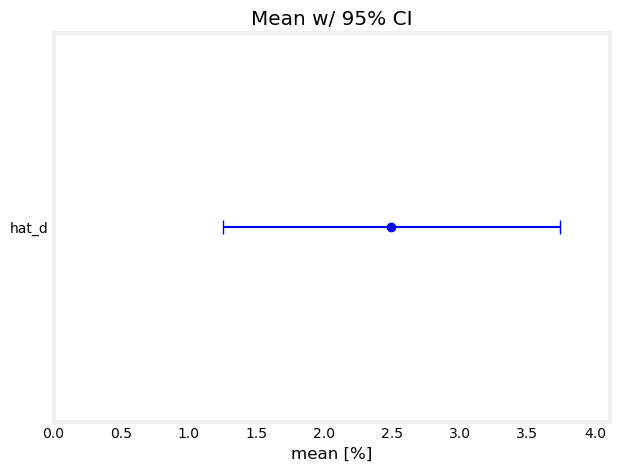

In [165]:
mean = d[0]*100
upper = d[1][1]*100
lower = d[1][0]*100
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='blue')
plt.yticks([y_pos], ["hat_d"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

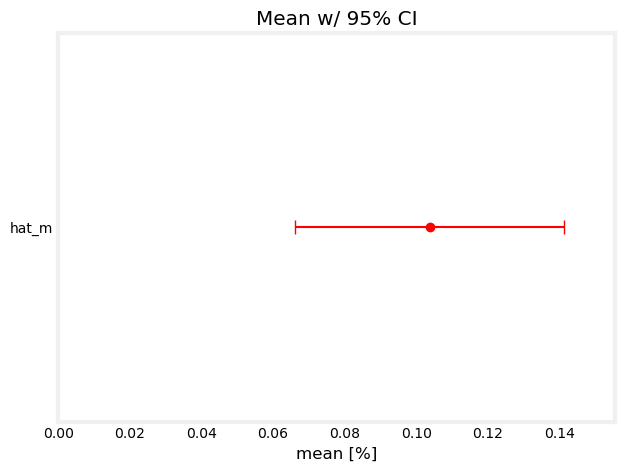

In [166]:
mean = m[0]
upper = m[1][1]
lower = m[1][0]
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='red')
plt.yticks([y_pos], ["hat_m"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

In [167]:
d, m, df = ab_experiment(exper_binary_metric,
              exper_continuous_metric,
              full_data,
              largest_narm=True,
              alpha=0.05, power=0.9)

In [168]:
display(df)

user_id  rollout_group assign_date group        age age_cohort  \
0       325764              1  2025-09-03     A  24.158510      18-40   
1       879649              1  2025-09-03     A  80.303128        >65   
2       744430              1  2025-09-03     A  62.492839      41-65   
3       493775              1  2025-09-03     A  77.846068        >65   
4       233150              1  2025-09-03     A  75.345831        >65   
...        ...            ...         ...   ...        ...        ...   
10119   989803              4  2025-09-09     B  35.497943      18-40   
10120   974289              4  2025-09-09     B  60.649075      41-65   
10121   276887              4  2025-09-09     B  65.656267      41-65   
10122   741436              4  2025-09-09     B  36.351265      18-40   
10123   935095              4  2025-09-09     B  57.743519      41-65   

             income income_cohort     net_worth networth_cohort  \
0      1.292613e+05        25-50%  5.648426e+05          25-50%   
1      1.718059e+06          >75%  2.394214e+07            >75%   
2      2.854845e+05        50-75%  5.080804e+06          50-75%   
3      3.290715e+06          >75%  1.058581e+08            >75%   
4      5.268043e+05          >75%  1.211747e+07            >75%   
...             ...           ...           ...             ...   
10119  4.822855e+04         0-25%  1.849994e+04           0-25%   
10120  1.552760e+05        25-50%  3.801257e+06          50-75%   
10121  4.855702e+04         0-25%  1.844628e+05           0-25%   
10122  9.218878e+05          >75%  1.050384e+07            >75%   
10123  7.469524e+06          >75%  8.655344e+07            >75%   

       retirement_balance balance_cohort  current_pct  employer_cap  \
0            4.538236e+05         25-50%         9.75          7.50   
1            5.993593e+06           >75%         7.25          3.50   
2            4.746565e+06           >75%         3.25          1.25   
3            8.444353e+05         50-75%        12.00          9.75   
4            5.539133e+06           >75%         8.75         12.00   
...                   ...            ...          ...           ...   
10119        1.263412e+04          0-25%         2.75          5.75   
10120        6.758791e+05         50-75%         5.75          9.00   
10121        2.651532e+05         25-50%        12.25         14.75   
10122        2.064712e+06           >75%         9.50         13.00   
10123        5.547511e+06           >75%        13.00          3.75   

       last_login  acct_tenure  time_online_frac  conv_rate  converted  \
0            35.0    10.548975             0.231   0.018350          0   
1           252.7     1.622955             0.120   0.001548          0   
2             0.2     6.016386             0.164   0.002718          0   
3            60.8     2.701381             0.129   0.005139          0   
4            71.1     2.340242             0.106   0.003408          0   
...           ...          ...               ...        ...        ...   
10119        22.5     1.098876             0.295   0.106096          0   
10120        89.8    21.975474             0.169   0.011742          0   
10121         1.6    22.079970             0.159   0.008033          0   
10122        46.9     6.322336             0.223   0.101630          0   
10123         2.7     3.989433             0.160   0.042926          0   

      conversion_date  delta_pct  new_pct  user_delta_aum  employer_delta_aum  \
0                 NaT        0.0     9.75             0.0                 0.0   
1                 NaT        0.0     7.25             0.0                 0.0   
2                 NaT        0.0     3.25             0.0                 0.0   
3                 NaT        0.0    12.00             0.0                 0.0   
4                 NaT        0.0     8.75             0.0                 0.0   
...               ...        ...      ...             ...                 ...   
10119           

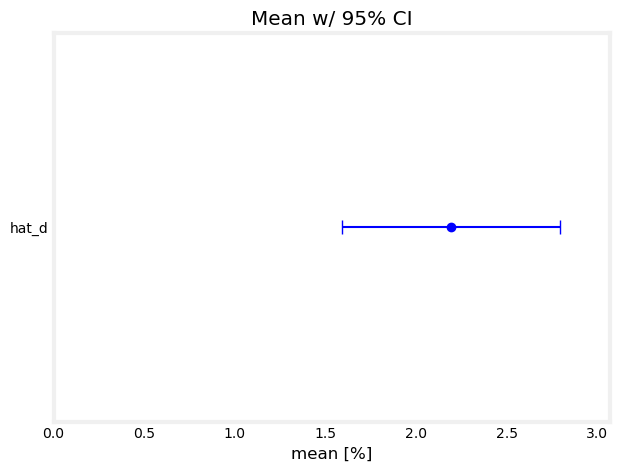

In [169]:
mean = d[0]*100
upper = d[1][1]*100
lower = d[1][0]*100
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='blue')
plt.yticks([y_pos], ["hat_d"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

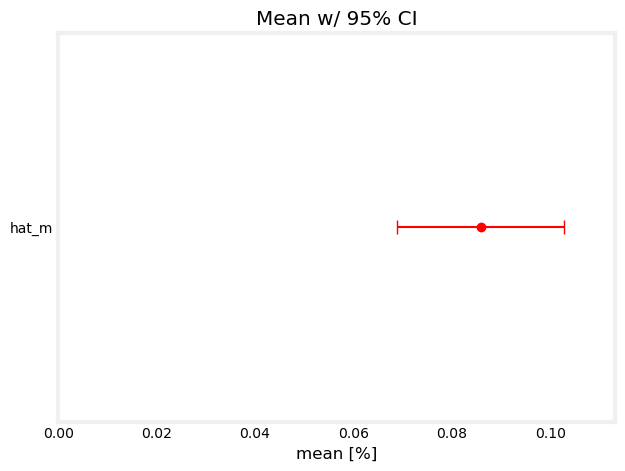

In [170]:
mean = m[0]
upper = m[1][1]
lower = m[1][0]
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='red')
plt.yticks([y_pos], ["hat_m"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

del mean, upper, lower

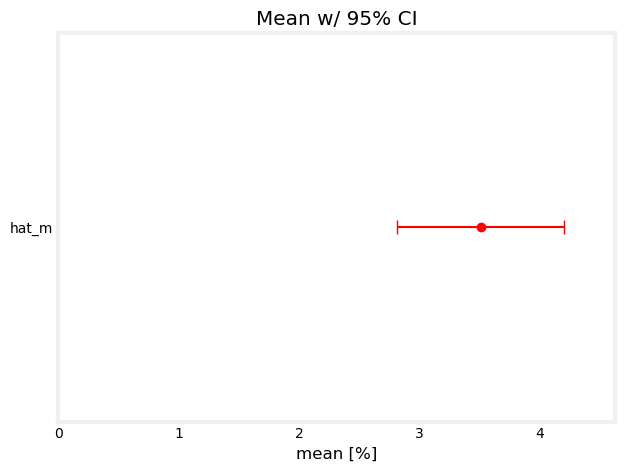

3.5086444277558395 2.8127026017738608 4.204586253737818


In [171]:
pooled_conv_rate = (d[0] + 2*exper_binary_metric['baseline_true'])/2

mean = m[0]/pooled_conv_rate
upper = m[1][1]/pooled_conv_rate
lower = m[1][0]/pooled_conv_rate
y_pos = 1    # vertical position
# compute asymmetric x errors
xerr = np.array([[mean - lower], [upper - mean]])  # shape [[left], [right]]
plt.errorbar(mean, y_pos, xerr=xerr, fmt='o', capsize=5, color='red')
plt.yticks([y_pos], ["hat_m"])

plt.xlabel("mean [%]")
plt.title("Mean w/ 95% CI")
plt.xlim(min(lower - abs(lower)*0.1, 0), upper+abs(upper)*0.1)
plt.grid(False)
plt.show()

print(mean, lower, upper)

del mean, lower, upper

Powering on the secondary metric:

In [172]:
d, m, df = ab_experiment(exper_binary_metric,
              exper_continuous_metric,
              full_data,
              largest_narm=True,
              alpha=0.05, power=0.9,
              random_state=5)

10,000 samples an arm:

In [173]:
d, m, df = ab_experiment(exper_binary_metric,
              exper_continuous_metric,
              full_data,
              largest_narm=10_000,
              alpha=0.05, power=0.9)

In [174]:
del d, m, df

### Cleanup

In [175]:
Out.clear()

for name in dir():
    if name.startswith('_') and name[1:].isdigit():
        del globals()[name]

del name

## 4. Analysis

In this section we devote ourselves to the analysis of our experiments.

### Reading Data

Here is a couple of helper functions that help us import the experiments

#### Summaries

In [176]:
import ast

In [177]:
# reading the summaries

with open(exper_data_dir+"experiments.txt", "r") as f:
    lines = f.read()
    lines = lines.split("\n")
    lines.pop()

summaries = {}
for num, line in enumerate(lines):
    num += 1
    num = str(num).zfill(2)
    summary = line.removeprefix(f"experiment_no-{num}: ")
    summary = ast.literal_eval(summary)
    summaries[num] = summary

del lines, num, line, summary

#### Experiment

In [178]:
def read_experiment(num_string):
    """
    Read an experiment CSV file into a DataFrame.

    Parameters
    ----------
    num_string : str
        Identifier suffix used to locate the experiment file.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the experiment data.
    """

    df = pd.read_csv(exper_data_dir+f"experiment_no-{num_string}.csv", index_col=0)

    return df

### Case Study

In [179]:
exp_num = "02"
summary = summaries[exp_num]
df = read_experiment(exp_num)

In [180]:
summary

{'primary_metric': {'baseline_true': 0.013500000000000002,
  'treatment_true': 0.0385,
  'MDE': 0.02},
 'secondary_metric': {'baseline_true': 0.4054651081081644,
  'treatment_true': 1.0986122886681098,
  'MDE': 1.0},
 'alpha': 0.05,
 'power': 0.9,
 'n_arm': 5062,
 'prop_mean_CI': (0.021928091663374165,
  (0.015932784605666262, 0.027923398721082068)),
 'cont_mean_CI': (0.08583563808771236,
  (0.06881008536070124, 0.10286119081472347)),
 'rollouts': [0.1, 0.15, 0.25],
 'start_date': '2025-09-03',
 'duration_experiment': 30,
 'prep_time': 30,
 'nudge_cost_per_user': 0.001,
 'flat_cost_per_day': 208.33333333333334,
 'management_fees': 0.0007000000000000001}

### Monitoring

Let us monitor experiment #2. Some simple plots of what monitoring could look like:

#### Age Buckets

In [181]:
# computing buckets as a function of time

age_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'age_cohort'])['user_id'].count()

age_evolution = age_evolution.unstack()
age_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group A: Age Cohort")
plt.grid(True)
plt.show()

del age_evolution

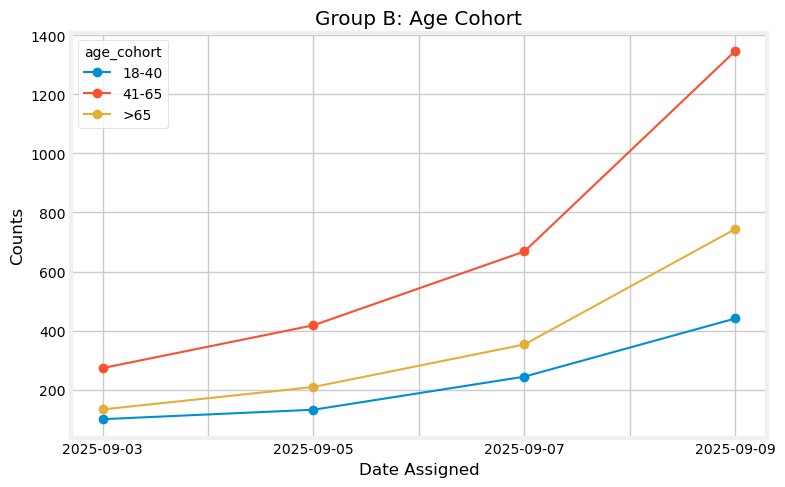

In [182]:
# computing buckets as a function of time

age_evolution = df[df['group'] == 'B'].groupby(['assign_date', 'age_cohort'])['user_id'].count()

age_evolution = age_evolution.unstack()
age_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group B: Age Cohort")
plt.grid(True)
plt.show()

del age_evolution

In [183]:
# computing buckets as a function of time

age_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'age_cohort'])['user_id'].count() / df[df['group'] == 'B'].groupby(['assign_date', 'age_cohort'])['user_id'].count()

age_evolution = age_evolution.unstack()

age_evolution.plot(figsize=(8,5), marker='o')

plt.plot(age_evolution.index, np.ones_like(age_evolution.index), color='k', ls='--', alpha=0.5)

plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Age Cohorts, A-to-B Ratio")
plt.grid(True)
plt.show()

del age_evolution

#### Income Buckets

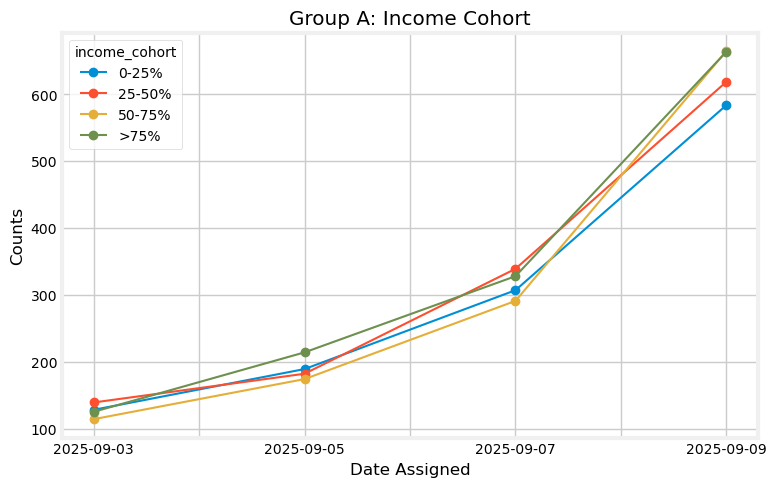

In [184]:
# computing buckets as a function of time

income_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'income_cohort'])['user_id'].count()

income_evolution = income_evolution.unstack()
income_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group A: Income Cohort")
plt.grid(True)
plt.show()

del income_evolution

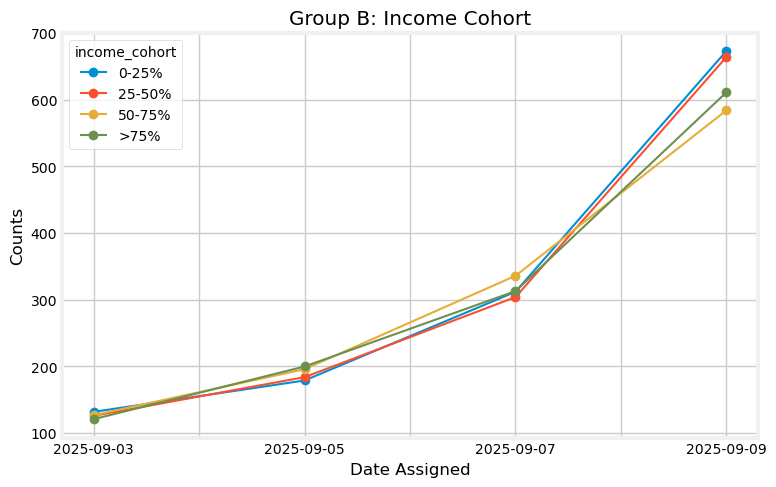

In [185]:
# computing buckets as a function of time

income_evolution = df[df['group'] == 'B'].groupby(['assign_date', 'income_cohort'])['user_id'].count()

income_evolution = income_evolution.unstack()
income_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group B: Income Cohort")
plt.grid(True)
plt.show()

del income_evolution

In [186]:
# computing buckets as a function of time

income_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'income_cohort'])['user_id'].count() / df[df['group'] == 'B'].groupby(['assign_date', 'income_cohort'])['user_id'].count()

income_evolution = income_evolution.unstack()

income_evolution.plot(figsize=(8,5), marker='o')

plt.plot(income_evolution.index, np.ones_like(income_evolution.index), color='k', ls='--', alpha=0.5)

plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Income Cohorts, A-to-B Ratio")
plt.grid(True)
plt.show()

del income_evolution

#### Balance Buckets

In [187]:
# computing buckets as a function of time

balance_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'balance_cohort'])['user_id'].count()

balance_evolution = balance_evolution.unstack()
balance_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group A: Balance Cohort")
plt.grid(True)
plt.show()

del balance_evolution

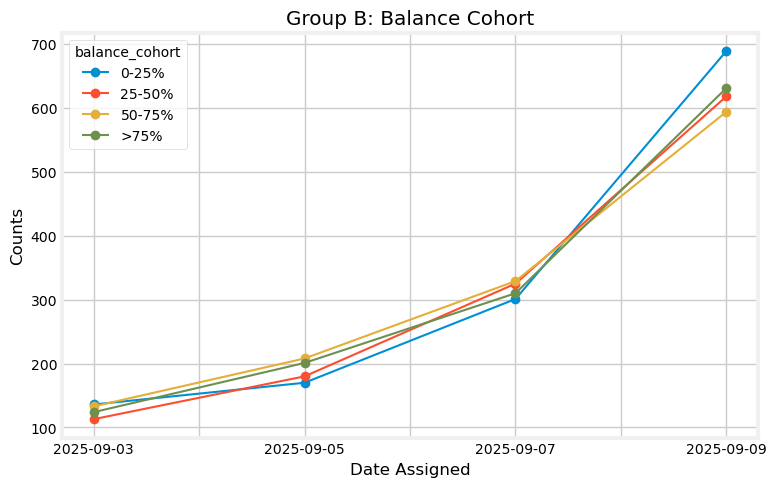

In [188]:
# computing buckets as a function of time

balance_evolution = df[df['group'] == 'B'].groupby(['assign_date', 'balance_cohort'])['user_id'].count()

balance_evolution = balance_evolution.unstack()
balance_evolution.plot(figsize=(8,5), marker='o')
plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Group B: Balance Cohort")
plt.grid(True)
plt.show()

del balance_evolution

In [189]:
# computing buckets as a function of time

balance_evolution = df[df['group'] == 'A'].groupby(['assign_date', 'balance_cohort'])['user_id'].count() / df[df['group'] == 'B'].groupby(['assign_date', 'balance_cohort'])['user_id'].count()

balance_evolution = balance_evolution.unstack()

balance_evolution.plot(figsize=(8,5), marker='o')

plt.plot(balance_evolution.index, np.ones_like(balance_evolution.index), color='k', ls='--', alpha=0.5)

plt.xlabel("Date Assigned")
plt.ylabel("Counts")
plt.title("Balance Cohorts, A-to-B Ratio")
plt.grid(True)
plt.show()

del balance_evolution

#### Proportions

In [190]:
def props_time_fn(group, data):

    df = data.copy()
    df = df[df['group'] == group]

    conversion_dates = sorted(list(df[df['conversion_date'].isna() == False]['conversion_date'].sort_values().unique()) + list(df['assign_date'].unique()))
    conversion_dates = np.unique(conversion_dates)
    conversion_dates = pd.date_range(pd.to_datetime(conversion_dates[0]),
                                     pd.to_datetime(conversion_dates[-1]),
                                     freq='d')
    conversion_dates = conversion_dates.astype(str)

    counts = df.groupby(['assign_date','rollout_group']).size().unstack(fill_value=0).sum(axis=1)
    counts = counts.reindex(conversion_dates, fill_value=0)
    counts = counts.cumsum()

    conversions = df.groupby('conversion_date')['converted'].sum()
    conversions = conversions.reindex(conversion_dates, fill_value=0)
    conversions = conversions.cumsum()

    props_time = conversions/counts

    return props_time

In [191]:
(props_time_fn('A', df)*100).plot(figsize=(8,5), marker='o', label='A')
(props_time_fn('B', df)*100).plot(figsize=(8,5), marker='o', label='B')

plt.xlabel("Date")
plt.ylabel("Proportions [%]")
plt.title("Proportions per Group")
plt.legend()
plt.grid(True)
plt.show()

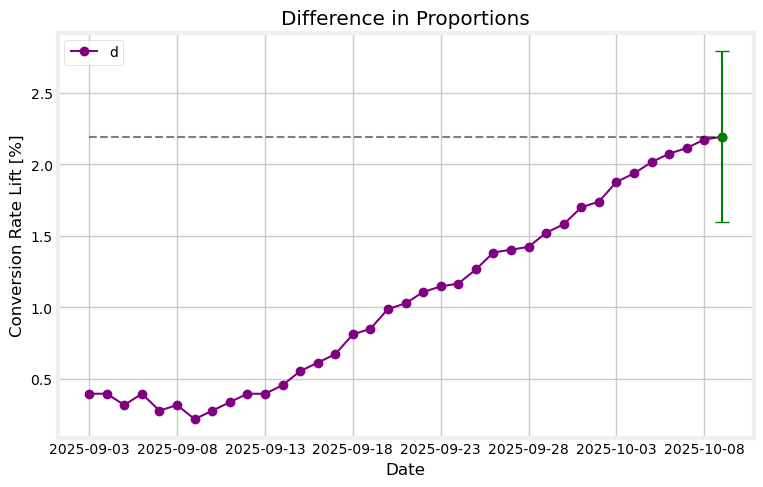

In [192]:
diffs = (props_time_fn('B', df)-props_time_fn('A', df))
diffs *= 100
diffs.plot(figsize=(8,5), marker='o', label=r'd', color='purple')

refs = pd.Series(diffs.iloc[-1], index=props_time_fn('B', df).index)
refs.plot(figsize=(8,5), color='k', ls='--', alpha=0.5)

mean, ci = summary['prop_mean_CI']
lower, upper = ci

mean *= 100
lower *= 100
upper *= 100

# xpos = diffs.index[-1]
xpos = len(diffs) - 1

yerr = np.array([[mean - lower], [upper - mean]])  # shape [[bottom], [top]]
plt.errorbar([xpos], [mean], yerr=yerr, fmt='o', capsize=5, color='green')

plt.xlabel("Date")
plt.ylabel("Conversion Rate Lift [%]")
plt.title("Difference in Proportions")
plt.legend()
plt.grid(True)
plt.show()

del diffs, refs, mean, ci, lower, upper, xpos, yerr

#### Contribution Growth

In [193]:
def means_time_fn(group, data):

    df = data.copy()
    df = df[df['group'] == group]

    conversion_dates = sorted(list(df[df['conversion_date'].isna() == False]['conversion_date'].sort_values().unique()) + list(df['assign_date'].unique()))
    conversion_dates = np.unique(conversion_dates)
    conversion_dates = pd.date_range(pd.to_datetime(conversion_dates[0]),
                                     pd.to_datetime(conversion_dates[-1]),
                                     freq='d')
    conversion_dates = conversion_dates.astype(str)

    counts = df.groupby(['assign_date','rollout_group']).size().unstack(fill_value=0).sum(axis=1)
    counts = counts.reindex(conversion_dates, fill_value=0)
    counts = counts.cumsum()

    deltas = df.groupby('conversion_date')['delta_pct'].sum()
    deltas = deltas.reindex(conversion_dates, fill_value=0)
    deltas = deltas.cumsum()

    means_time = deltas/counts

    return means_time

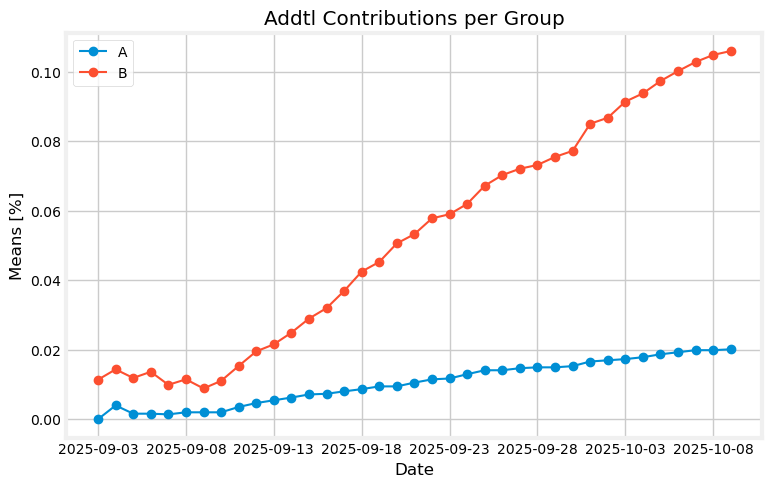

In [194]:
(means_time_fn('A', df)).plot(figsize=(8,5), marker='o', label='A')
(means_time_fn('B', df)).plot(figsize=(8,5), marker='o', label='B')

plt.xlabel("Date")
plt.ylabel("Means [%]")
plt.title("Addtl Contributions per Group")
plt.legend()
plt.grid(True)
plt.show()

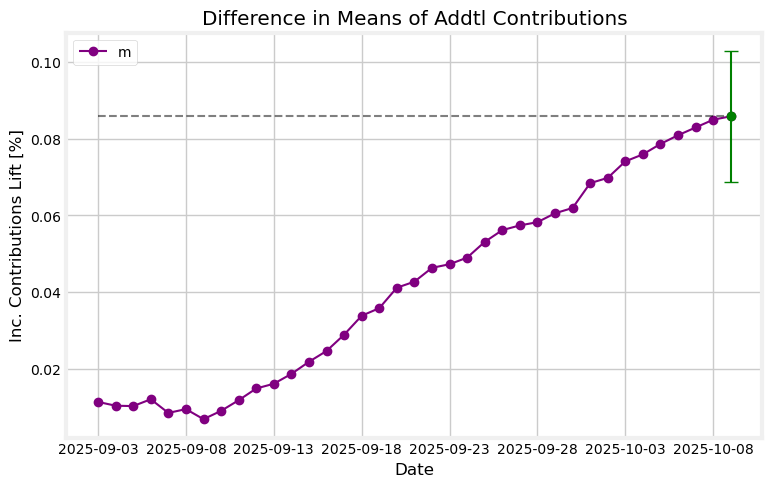

In [195]:
diffs = (means_time_fn('B', df)-means_time_fn('A', df))
diffs.plot(figsize=(8,5), marker='o', label=r'm', color='purple')

refs = pd.Series(diffs.iloc[-1], index=means_time_fn('B', df).index)
refs.plot(figsize=(8,5), color='k', ls='--', alpha=0.5)

mean, ci = summary['cont_mean_CI']
lower, upper = ci

# xpos = diffs.index[-1]
xpos = len(diffs) - 1

yerr = np.array([[mean - lower], [upper - mean]])  # shape [[bottom], [top]]
plt.errorbar([xpos], [mean], yerr=yerr, fmt='o', capsize=5, color='green')

plt.xlabel("Date")
plt.ylabel("Inc. Contributions Lift [%]")
plt.title("Difference in Means of Addtl Contributions")
plt.legend()
plt.grid(True)
plt.show()

del diffs, refs, mean, ci, lower, upper, xpos, yerr

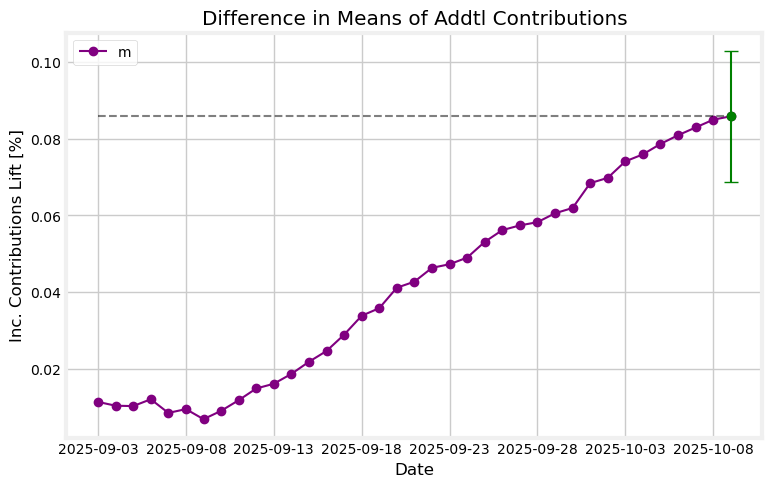

In [196]:
diffs = (means_time_fn('B', df)-means_time_fn('A', df))
diffs.plot(figsize=(8,5), marker='o', label=r'm', color='purple')

refs = pd.Series(diffs.iloc[-1], index=means_time_fn('B', df).index)
refs.plot(figsize=(8,5), color='k', ls='--', alpha=0.5)

mean, ci = summary['cont_mean_CI']
lower, upper = ci

# xpos = diffs.index[-1]
xpos = len(diffs) - 1

yerr = np.array([[mean - lower], [upper - mean]])  # shape [[bottom], [top]]
plt.errorbar([xpos], [mean], yerr=yerr, fmt='o', capsize=5, color='green')

plt.xlabel("Date")
plt.ylabel("Inc. Contributions Lift [%]")
plt.title("Difference in Means of Addtl Contributions")
plt.legend()
plt.grid(True)
plt.show()

del diffs, refs, mean, ci, lower, upper, xpos, yerr

### EDA & Business Value

Keep studying experiment #2:

In [197]:
exp_num = "02"
summary = summaries[exp_num]
df = read_experiment(exp_num)

In [198]:
summary

{'primary_metric': {'baseline_true': 0.013500000000000002,
  'treatment_true': 0.0385,
  'MDE': 0.02},
 'secondary_metric': {'baseline_true': 0.4054651081081644,
  'treatment_true': 1.0986122886681098,
  'MDE': 1.0},
 'alpha': 0.05,
 'power': 0.9,
 'n_arm': 5062,
 'prop_mean_CI': (0.021928091663374165,
  (0.015932784605666262, 0.027923398721082068)),
 'cont_mean_CI': (0.08583563808771236,
  (0.06881008536070124, 0.10286119081472347)),
 'rollouts': [0.1, 0.15, 0.25],
 'start_date': '2025-09-03',
 'duration_experiment': 30,
 'prep_time': 30,
 'nudge_cost_per_user': 0.001,
 'flat_cost_per_day': 208.33333333333334,
 'management_fees': 0.0007000000000000001}

#### Business Value

Some useful business definitions:

In [199]:
ONE_MILLION = 1.e6
ONE_BILLION = 1_000*ONE_MILLION
ONE_TRILLION = (ONE_MILLION)**2

Some important figures:

- Number of new converters attributable to treatment: $C_{\rm young,\,treat} = d\cdot N_{\rm young}$
- Increase in AUM attributable to treatment: $\Delta \mathrm{AUM}_{\rm treat} = \Delta \cdot I_{\rm young} \cdot C_{\rm young,\,treat}$
- Increase in revenue from fees on AUM, attributable to treatment: $\Delta \mathrm{Rev}_{\rm treat} = \mathrm{fee} \cdot \Delta\mathrm{AUM}$
- Future value of incr. in AUM due to returns: $\mathrm{FV}_{\rm treat} = \Delta \mathrm{AUM}_{\rm treat} \ \sum\limits_{i=0}^{T-1} (1+R)^i = \Delta \mathrm{AUM}_{\rm treat} \left( \frac{(1+R)^T - 1}{R} \right)$
- Total future of revenue from fees on AUM: $\mathrm{Tot\,Rev}_{\rm treat} = \mathrm{fee} \cdot \sum_{k=1}^{T}\, \mathrm{Balance}_k = \mathrm{fee} \cdot \Delta \mathrm{AUM}_{\rm treat} \left[ \frac{(1 + R)^{1 + T} -R(1+T) -1}{R^2} \right]$

In [200]:
def future_value_aum(aum, rate, lifetime):
    """Return the future value of assets under management (AUM).

    Parameters
    ----------
    aum : float
        Initial assets under management.
    rate : float
        Annualized return rate as a decimal.
    lifetime : int
        Investment horizon in years.

    Returns
    -------
    float
        Future value of the AUM after compounding.
    """

    factor = (np.power(1 + rate, lifetime) - 1)/rate

    fv = aum*factor

    return fv


def total_revenue(aum, rate, lifetime, fee):
    """
    Return the total revenue from fees on assets under management (AUM).

    Parameters
    ----------
    aum : float
        Initial assets under management.
    rate : float
        Annualized return rate as a decimal.
    lifetime : int
        Investment horizon in years.
    fee : float
        Annual management fee as a decimal.

    Returns
    -------
    float
        Total fee revenue over the investment horizon.
    """


    num = np.power(1+rate, 1+lifetime) - rate*(1+lifetime) - 1
    den = rate**2

    factor = num/den

    tot_rev = fee*aum*factor

    return tot_rev

So, for a quick example, assuming the benchmarks:

- 1 month of treatment only,
- Permanent conversion,
- No employer matching,
- $f_{\rm young} \approx 50\%$,
- $N_{\rm tot} = 50\mathrm{M}\,\text{people}$,
- $I_{\rm young} \approx \$100\mathrm{k}$,
- $d = 1.5\%$,
- $\Delta = 3\%$,
- $\mathrm{fee} = 0.07\%$,
- $T = 10\,\mathrm{yr}$,
- $R = 7\%/\mathrm{yr}$,

we get:

- $C_{\rm young,\,treat} = 375\text{ k}$,
- $\Delta \mathrm{AUM}_{\rm treat} = \$1.125\,\mathrm{B}/\mathrm{yr}$,
- $\Delta \mathrm{Rev}_{\rm treat} = 0.8\,\mathrm{M}/\mathrm{yr}$,
- $\mathrm{FV}_{\rm treat} = 15.5\,\mathrm{B}$,
- $\mathrm{Tot\,Rev}_{\rm treat} = 54\,\mathrm{M}$.

In [201]:
print("FV:", np.round(future_value_aum(1.125*ONE_BILLION, 0.07, 10) / ONE_BILLION, 1), "B")
print("Tot. Rev.:", np.round(total_revenue(1.125*ONE_BILLION, 0.07, 10, 0.07/100) / ONE_MILLION, 1), "M")

FV: 15.5 B
Tot. Rev.: 53.8 M


#### EDA

In [202]:
from scipy.stats import chi2_contingency

First, a quick description of the data:

In [203]:
df.head()

user_id  rollout_group assign_date group        age age_cohort  \
0   325764              1  2025-09-03     A  24.158510      18-40   
1   879649              1  2025-09-03     A  80.303128        >65   
2   744430              1  2025-09-03     A  62.492839      41-65   
3   493775              1  2025-09-03     A  77.846068        >65   
4   233150              1  2025-09-03     A  75.345831        >65   

         income income_cohort     net_worth networth_cohort  \
0  1.292613e+05        25-50%  5.648426e+05          25-50%   
1  1.718059e+06          >75%  2.394214e+07            >75%   
2  2.854845e+05        50-75%  5.080804e+06          50-75%   
3  3.290715e+06          >75%  1.058581e+08            >75%   
4  5.268043e+05          >75%  1.211747e+07            >75%   

   retirement_balance balance_cohort  current_pct  employer_cap  last_login  \
0        4.538236e+05         25-50%         9.75          7.50        35.0   
1        5.993593e+06           >75%         7.25          3.50       252.7   
2        4.746565e+06           >75%         3.25          1.25         0.2   
3        8.444353e+05         50-75%        12.00          9.75        60.8   
4        5.539133e+06           >75%         8.75         12.00        71.1   

   acct_tenure  time_online_frac  conv_rate  converted conversion_date  \
0    10.548975             0.231   0.018350          0             NaN   
1     1.622955             0.120   0.001548          0             NaN   
2     6.016386             0.164   0.002718          0             NaN   
3     2.701381             0.129   0.005139          0             NaN   
4     2.340242             0.106   0.003408          0             NaN   

   delta_pct  new_pct  user_delta_aum  employer_delta_aum  total_delta_aum  \
0        0.0     9.75             0.0                 0.0              0.0   
1        0.0     7.25             0.0                 0.0              0.0   
2        0.0     3.25             0.0                 0.0              0.0   
3        0.0    12.00             0.0                 0.0              0.0   
4        0.0     8.75             0.0                 0.0              0.0   

   revenue  roi_exper    roi  
0      0.0  -1.359159 -0.001  
1      0.0  -1.359159 -0.001  
2      0.0  -1.359159 -0.001  
3      0.0  -1.359159 -0.001  
4      0.0  -1.359159 -0.001

In [204]:
df.describe(include='all').iloc[:,1:]

rollout_group assign_date  group           age age_cohort  \
count    10124.000000       10124  10124  10124.000000      10124   
unique            NaN           4      2           NaN          3   
top               NaN  2025-09-09      A           NaN      41-65   
freq              NaN        5064   5062           NaN       5433   
mean         3.150336         NaN    NaN     56.243581        NaN   
std          1.013647         NaN    NaN     14.889166        NaN   
min          1.000000         NaN    NaN     18.016617        NaN   
25%          3.000000         NaN    NaN     44.955591        NaN   
50%          4.000000         NaN    NaN     57.023041        NaN   
75%          4.000000         NaN    NaN     67.422247        NaN   
max          4.000000         NaN    NaN     99.107285        NaN   

              income income_cohort     net_worth networth_cohort  \
count   1.012400e+04         10124  1.012400e+04           10124   
unique           NaN             4           NaN               4   
top              NaN          >75%           NaN            >75%   
freq             NaN          2576           NaN            2552   
mean    8.314243e+05           NaN  1.139687e+07             NaN   
std     2.083231e+06           NaN  3.088274e+07             NaN   
min     2.872741e+04           NaN  1.159267e+04             NaN   
25%     9.528234e+04           NaN  3.563231e+05             NaN   
50%     1.838191e+05           NaN  1.232546e+06             NaN   
75%     5.315202e+05           NaN  5.994211e+06             NaN   
max     2.217093e+07           NaN  2.872223e+08             NaN   

        retirement_balance balance_cohort   current_pct  employer_cap  \
count         1.012400e+04          10124  10124.000000  10124.000000   
unique                 NaN              4           NaN           NaN   
top                    NaN           >75%           NaN           NaN   
freq                   NaN           2573           NaN           NaN   
mean          1.461236e+06            NaN      7.861986      7.729825   
std           2.234933e+06            NaN      3.318314      3.299438   
min           3.384471e+03            NaN      0.250000      0.250000   
25%           1.180326e+05            NaN      5.250000      5.250000   
50%           5.060654e+05            NaN      7.750000      7.500000   
75%           1.780469e+06            NaN     10.250000     10.000000   
max           1.374985e+07            NaN     18.750000     18.750000   

          last_login   acct_tenure  time_online_frac     conv_rate  \
count   10124.000000  10124.000000      10124.000000  10124.000000   
unique           NaN           NaN               NaN           NaN   
top              NaN           NaN               NaN           NaN   
freq             NaN           NaN               NaN           NaN   
mean       29.837396      5.047202          0.189105      0.025557   
std        29.735272      4.956147          0.050059      0.033690   
min         0.000000      0.010183          0.016000      0.000366   
25%         8.600000      1.502395          0.152000      0.006315   
50%        20.800000      3.536105          0.188000      0.013700   
75%        41.300000      6.962570          0.225000      0.030916   
max       293.200000     57.877685          0.376000      0.395627   

           converted conversion_date     delta_pct       new_pct  \
count   10124.000000             247  10124.000000  10124.000000   
unique           NaN              37           NaN           NaN   
top              NaN      2025-09-11           NaN           NaN   
freq             NaN              13           NaN           NaN   
mean        0.024397             NaN      0.063019      7.925005   
std         0.154287             NaN      0.439099      3.335347   
min         0.000000             NaN      0.000000      0.250000   
25%         0.000000             NaN      0.000000      5.500000   
50%         0.000000            

In [205]:
df.rename(columns={'group':"Group",
                   'age':"Age [yrs]",
                   'age_cohort':"Age Cohort",
                   'income':"Income [$100k]",
                   'income_cohort':"Income Cohort",
                   'net_worth':"Net Worth [$100k]",
                   'networth_cohort':"Net Worth Cohort",
                   'retirement_balance':"Balance [$100k]",
                   'balance_cohort':"Balance Cohort",
                   'current_pct':"Current Contribution [%]",
                   'employer_cap':"Employer Contribution Cap [%]",
                   'last_login':"Last Login [Days]",
                   'acct_tenure':"Account Tenure [yrs]",
                   'time_online_frac':"Hrs. Online/Day",
                   'conv_rate':"Conversion Rate [%]",
                   'converted':"Converted?",
                   'delta_pct':"Addtl Contribution [%]",
                   'new_pct':"New Current Contribution [%]",
                   'employer_delta_aum':"Addtl AUM from Client [$100k]",
                   'total_delta_aum':"Total Addtl AUM [$100k]",
                   'revenue':"Revenue [$]",
                   'roi_exper':"ROI [$, nudge + experiment]",
                   'roi':"ROI [$, nudge only]"
                  }, inplace=True)

df["Conversion Rate [%]"] *= 100
df["Income [$100k]"] /= 1.E5
df["Net Worth [$100k]"] /= 1.E5
df["Balance [$100k]"] /= 1.E5
df["Addtl AUM from Client [$100k]"] /= 1.E5
df["Total Addtl AUM [$100k]"] /= 1.E5

Conversion Rate $p \, [\%]$

~Terminally~ Financially Online:

<Figure size 200x200 with 0 Axes>

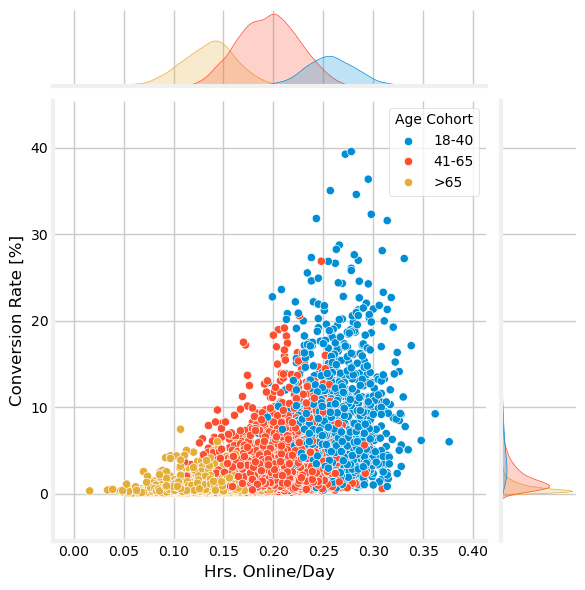

In [206]:
plt.figure(figsize=(2, 2))
sns.jointplot(data=df, x='Hrs. Online/Day', y='Conversion Rate [%]', hue='Age Cohort', hue_order=['18-40','41-65','>65'])
plt.show()

<Axes: xlabel='Group', ylabel='Conversion Rate [%]'>

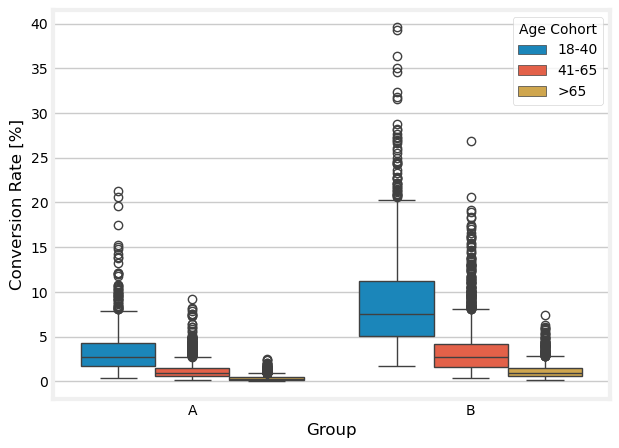

In [207]:
sns.boxplot(data=df, x='Group', y="Conversion Rate [%]", hue='Age Cohort', order=['A', 'B'], hue_order=['18-40','41-65','>65'])

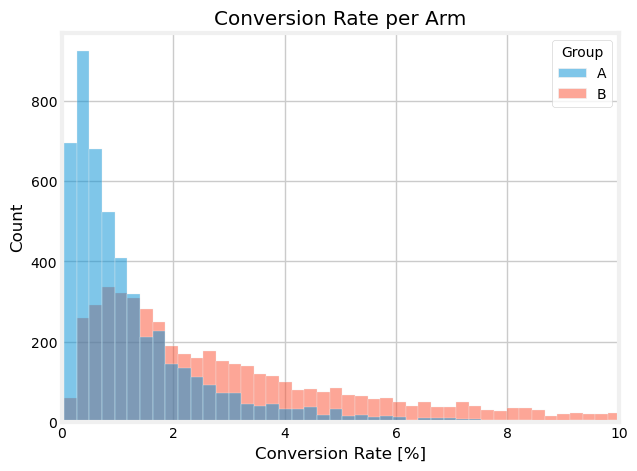

In [208]:
sns.histplot(data=df, x="Conversion Rate [%]", hue='Group')
plt.xlim(0, 10);
plt.title("Conversion Rate per Arm");

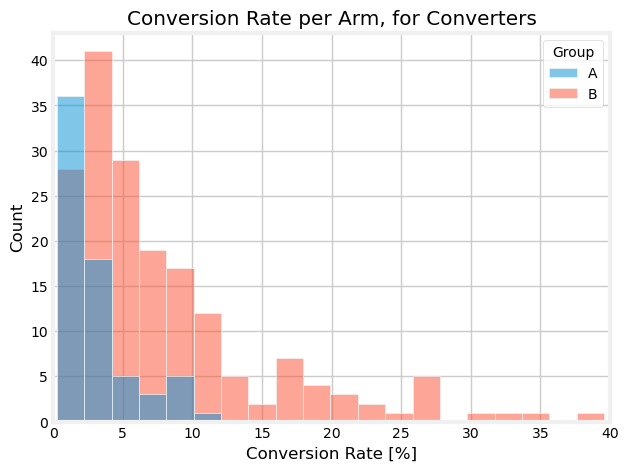

In [209]:
sns.histplot(data=df[df['Converted?']==1], x='Conversion Rate [%]', hue='Group')
plt.xlim(0, 40);
plt.title("Conversion Rate per Arm, for Converters");

$\Delta \, [\%]$

<Figure size 200x200 with 0 Axes>

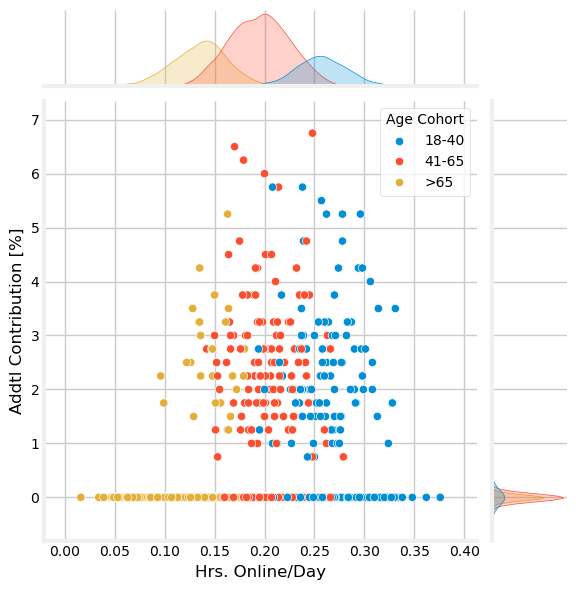

In [210]:
plt.figure(figsize=(2, 2))
sns.jointplot(data=df, x='Hrs. Online/Day', y="Addtl Contribution [%]", hue='Age Cohort', hue_order=['18-40','41-65','>65'])
plt.show()

In [211]:
df[df['Converted?']==1].groupby(['Group','Age Cohort'])["Addtl Contribution [%]"].mean()

Group  Age Cohort
A      18-40         1.469697
       41-65         1.419643
       >65           1.928571
B      18-40         3.018116
       41-65         2.988889
       >65           2.950000
Name: Addtl Contribution [%], dtype: float64

<Axes: xlabel='Group', ylabel='Addtl Contribution [%]'>

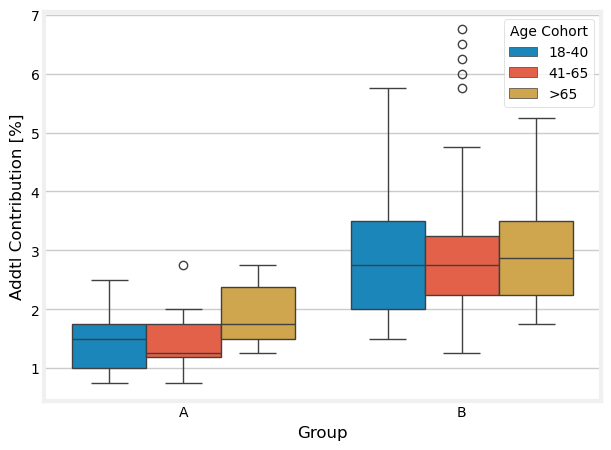

In [212]:
sns.boxplot(data=df[df['Converted?']==1], x='Group', y="Addtl Contribution [%]", hue='Age Cohort', order=['A', 'B'], hue_order=['18-40','41-65','>65'])

Means of the log:

In [213]:
df[df['Converted?']==1].groupby(['Group','Age Cohort'])["Addtl Contribution [%]"].agg(lambda x: np.mean(np.log(x)))

Group  Age Cohort
A      18-40         0.337296
       41-65         0.300445
       >65           0.618930
B      18-40         1.040568
       41-65         1.030816
       >65           1.040768
Name: Addtl Contribution [%], dtype: float64

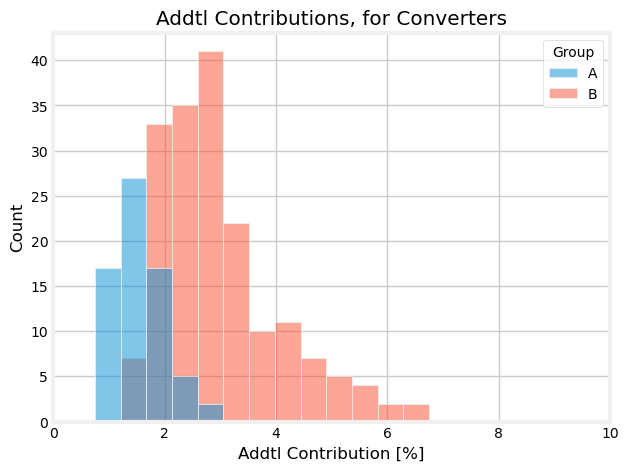

In [214]:
sns.histplot(data=df[df['Converted?']==1], x="Addtl Contribution [%]", hue='Group')
plt.xlim(0, 10);
plt.title("Addtl Contributions, for Converters");

Revenue:

In [215]:
print("Sum:")
display(df.groupby(['Group','Age Cohort'])['Revenue [$]'].sum())
print("\nMean:")
display(df.groupby(['Group','Age Cohort'])['Revenue [$]'].mean())

Sum:


Group  Age Cohort
A      18-40          463.162201
       41-65          770.932946
       >65            971.100899
B      18-40         2380.349227
       41-65         6104.391609
       >65            967.047366
Name: Revenue [$], dtype: float64


Mean:


Group  Age Cohort
A      18-40         0.511781
       41-65         0.282704
       >65           0.679092
B      18-40         2.595801
       41-65         2.255873
       >65           0.672027
Name: Revenue [$], dtype: float64

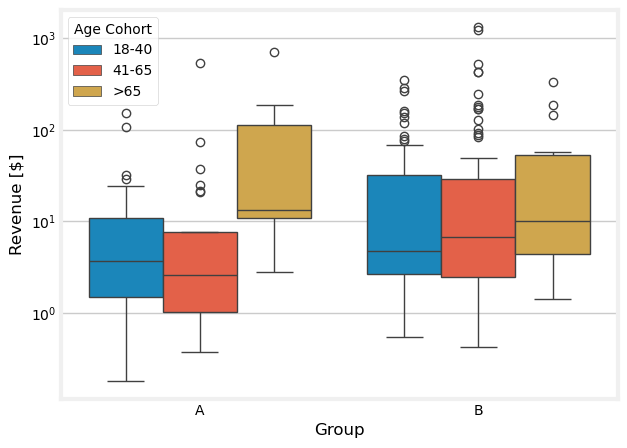

In [216]:
sns.boxplot(data=df[df['Converted?']==1], x='Group', y='Revenue [$]', hue='Age Cohort', order=['A', 'B'], hue_order=['18-40','41-65','>65'])
plt.yscale('log')

ROI (including nudge and experiment cost):

In [217]:
print("Sum:")
display(df.groupby(['Group','Age Cohort'])['ROI [$, nudge + experiment]'].sum())
print("\nMean:")
display(df.groupby(['Group','Age Cohort'])['ROI [$, nudge + experiment]'].mean())

display(df.groupby(['Group','Age Cohort'])['ROI [$, nudge + experiment]'].sum().sum())

Sum:


Group  Age Cohort
A      18-40         -766.876541
       41-65        -2935.493185
       >65           -972.496229
B      18-40         1134.000579
       41-65         2426.507814
       >65           -988.782191
Name: ROI [$, nudge + experiment], dtype: float64


Mean:


Group  Age Cohort
A      18-40        -0.847377
       41-65        -1.076455
       >65          -0.680067
B      18-40         1.236642
       41-65         0.896714
       >65          -0.687131
Name: ROI [$, nudge + experiment], dtype: float64

np.float64(-2103.1397516196685)

In [218]:
sns.boxplot(data=df[df['Converted?']==1], x='Group', y='ROI [$, nudge + experiment]', hue='Age Cohort', order=['A', 'B'], hue_order=['18-40','41-65','>65'])
plt.yscale('log')

ROI (including nudge cost only):

In [219]:
print("Sum:")
display(df.groupby(['Group','Age Cohort'])['ROI [$, nudge only]'].sum())
print("\nMean:")
display(df.groupby(['Group','Age Cohort'])['ROI [$, nudge only]'].mean())

Sum:


Group  Age Cohort
A      18-40          462.257201
       41-65          768.205946
       >65            969.670899
B      18-40         2379.432227
       41-65         6101.685609
       >65            965.608366
Name: ROI [$, nudge only], dtype: float64


Mean:


Group  Age Cohort
A      18-40         0.510781
       41-65         0.281704
       >65           0.678092
B      18-40         2.594801
       41-65         2.254873
       >65           0.671027
Name: ROI [$, nudge only], dtype: float64

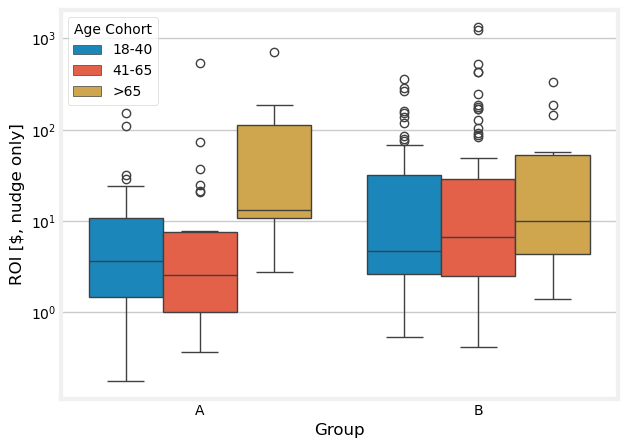

In [220]:
sns.boxplot(data=df[df['Converted?']==1], x='Group', y='ROI [$, nudge only]', hue='Age Cohort', order=['A', 'B'], hue_order=['18-40','41-65','>65'])
plt.yscale('log')

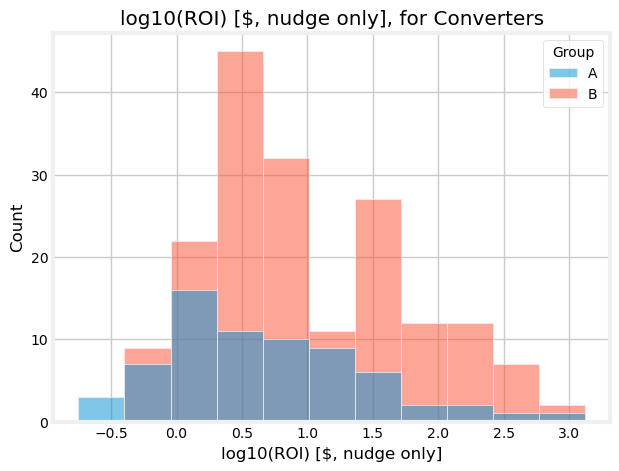

In [221]:
tmp = df[df['Converted?']==1].copy()
tmp["log10(ROI) [$, nudge only]"] = np.log10(tmp["ROI [$, nudge only]"])

sns.histplot(data=tmp, x="log10(ROI) [$, nudge only]", hue='Group')
# plt.xscale("log")
plt.title("log10(ROI) [$, nudge only], for Converters");
del tmp

We now compute the ROI (discounting the cost of a nudge only) that is attributable to the treatment, or ATE (i.e., B-A), per person, and decompose it according to age cohort.

**N.B.:** this is **not** the ATE ROI per age cohort person (i.e., these many dollars per 18-40 y.o.). Its sum is the *weighted* average of the ATE ROI in any given population, where the weight is given by the preponderance of each cohort (the fraction of the given population that is in that cohort). So each individual term is the ATE ROI times each age cohort weight. This can be used to compute the ATE ROI per age cohort for a population of *any* size.

In [222]:
ate_roi = pd.Series()
ate_roi = (df.groupby(['Group','Age Cohort'])['ROI [$, nudge only]'].sum()['B'] - df.groupby(['Group','Age Cohort'])['ROI [$, nudge only]'].sum()['A'])/(len(df)/2)

ate_roi.name = "ATE ROI Per Person [$, nudge only]"

ate_roi

Age Cohort
18-40    0.378739
41-65    1.053631
>65     -0.000803
Name: ATE ROI Per Person [$, nudge only], dtype: float64

If there are 50M investors in ABC Investments, then the ATE ROI per cohort is:

In [223]:
ate_roi*(50_000_000)/ONE_MILLION

Age Cohort
18-40    18.936932
41-65    52.681545
>65      -0.040128
Name: ATE ROI Per Person [$, nudge only], dtype: float64

It seems like middle aged investors contribute more... but the ROI of the younger ones compounds for longer!

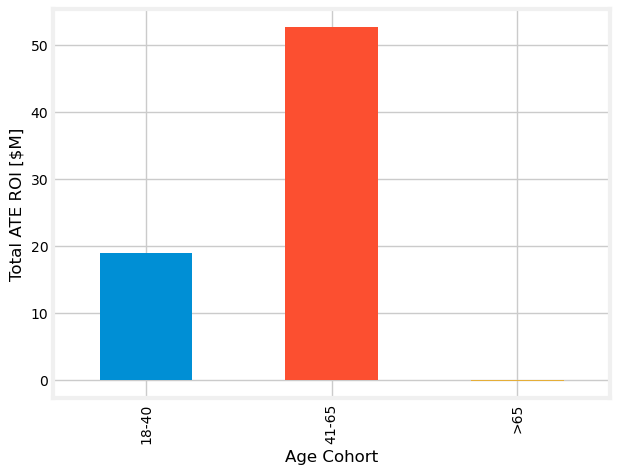

In [224]:
(ate_roi*(50_000_000)/ONE_MILLION).plot(kind="bar", color=palette_538[:3])
plt.ylabel("Total ATE ROI [$M]");

Let us now explore in more detail the conversions.

Chi2ContingencyResult(statistic=np.float64(2.0786036278404465), pvalue=np.float64(0.35370154526578995), dof=2, expected_freq=array([[28.08097166, 73.91902834],
       [32.48582996, 85.51417004],
       [ 7.43319838, 19.56680162]]))

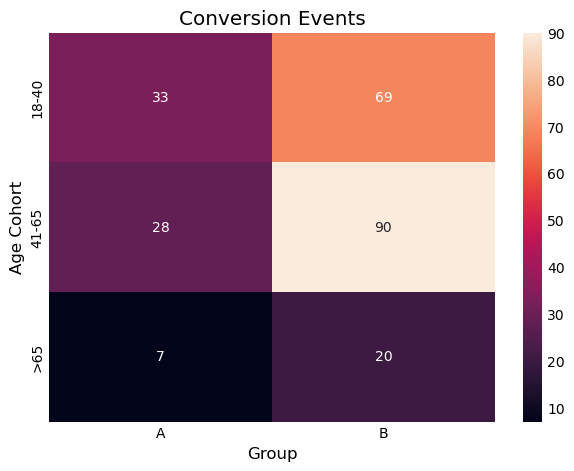

In [225]:
cont_table_converted = df.groupby(['Age Cohort','Group'])['Converted?'].sum().unstack()
sns.heatmap(cont_table_converted, annot=True)
plt.title("Conversion Events")
chi2_contingency(cont_table_converted)

Chi2ContingencyResult(statistic=np.float64(46.14838760731665), pvalue=np.float64(9.528070385722408e-11), dof=2, expected_freq=array([[ 892.8427499,   12.1572501],
       [2690.3670486,   36.6329514],
       [1410.7902015,   19.2097985]]))

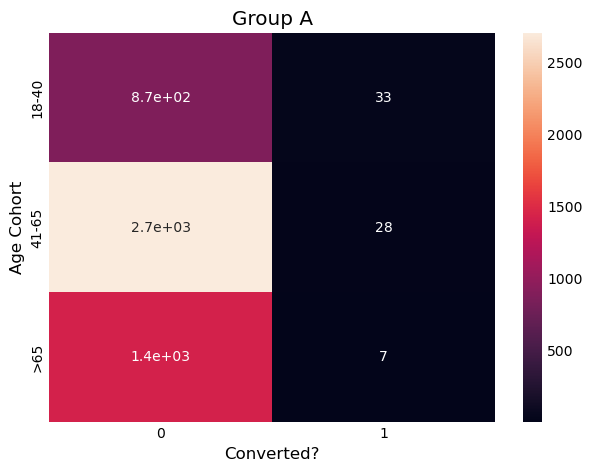

In [226]:
cont_tableA = df[df['Group']=='A'].groupby(['Age Cohort','Converted?']).size().unstack()
sns.heatmap(cont_tableA, annot=True)
plt.title("Group A")
chi2_contingency(cont_tableA)

In [227]:
cont_tableB = df[df['Group']=='B'].groupby(['Age Cohort','Converted?']).size().unstack()
sns.heatmap(cont_tableB, annot=True)
plt.title("Group B")
chi2_contingency(cont_tableB)

Chi2ContingencyResult(statistic=np.float64(62.546760203005974), pvalue=np.float64(2.6190488052266128e-14), dof=2, expected_freq=array([[ 884.57348874,   32.42651126],
       [2610.31173449,   95.68826551],
       [1388.11477677,   50.88522323]]))

In [228]:
cont_table_age = df.groupby(['Age Cohort','Group','Converted?']).size().unstack()
display(cont_table_age)

Converted?           0   1
Age Cohort Group          
18-40      A       872  33
           B       848  69
41-65      A      2699  28
           B      2616  90
>65        A      1423   7
           B      1419  20

Chi2ContingencyResult(statistic=np.float64(12.238858925168044), pvalue=np.float64(0.00046804443622551435), dof=1, expected_freq=array([[854.33589462,  50.66410538],
       [865.66410538,  51.33589462]]))

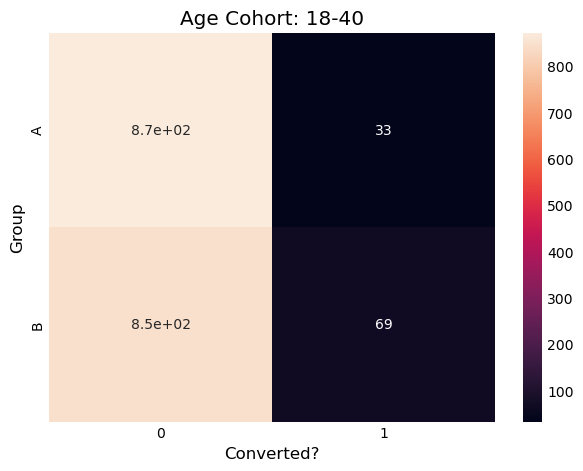

In [229]:
cohort = "18-40"

tab = cont_table_age.loc[cohort,:]
sns.heatmap(tab, annot=True)
plt.title("Age Cohort: "+cohort)

chi2_contingency(tab)

Chi2ContingencyResult(statistic=np.float64(32.71831527945575), pvalue=np.float64(1.065286962241937e-08), dof=1, expected_freq=array([[2667.7719492,   59.2280508],
       [2647.2280508,   58.7719492]]))

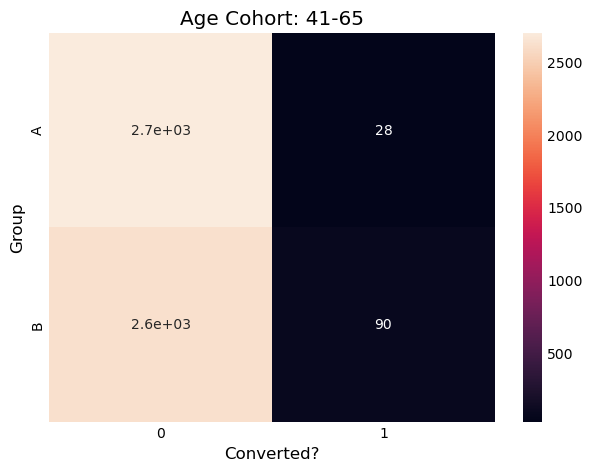

In [230]:
cohort = "41-65"

tab = cont_table_age.loc[cohort,:]
sns.heatmap(tab, annot=True)
plt.title("Age Cohort: "+cohort)

chi2_contingency(tab)

Chi2ContingencyResult(statistic=np.float64(5.308319520879259), pvalue=np.float64(0.0212238189324362), dof=1, expected_freq=array([[1416.54234925,   13.45765075],
       [1425.45765075,   13.54234925]]))

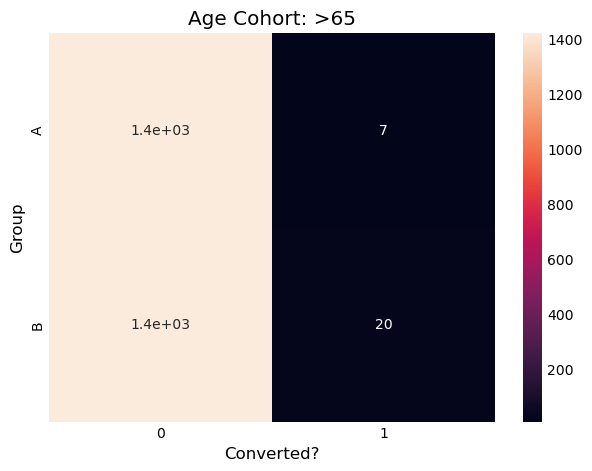

In [231]:
cohort = ">65"

tab = cont_table_age.loc[cohort,:]
sns.heatmap(tab, annot=True)
plt.title("Age Cohort: "+cohort)

chi2_contingency(tab)

<Axes: xlabel='Converted?', ylabel='Age Cohort'>

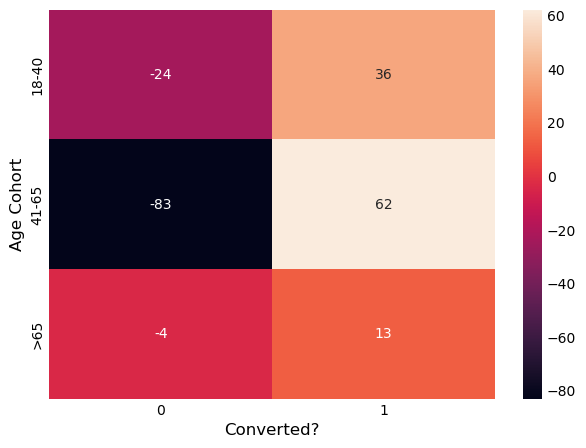

In [232]:
cont_tableATE = cont_tableB - cont_tableA

sns.heatmap(cont_tableATE, annot=True)
# chi2_contingency(cont_tableATE)

#### Cleanup

In [233]:
del cont_table_converted, cont_tableA, cont_tableB, cont_table_age, cohort, tab, cont_tableATE

### HTE

In [238]:
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.contingency_tables import Table2x2
from typing import Tuple

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import kruskal

In [239]:
cont_table_gp = df.groupby(['Group','Age Cohort','Converted?']).size().unstack()
display(cont_table_gp)

Converted?           0   1
Group Age Cohort          
A     18-40        872  33
      41-65       2699  28
      >65         1423   7
B     18-40        848  69
      41-65       2616  90
      >65         1419  20

In [240]:
cont_table_A = cont_table_gp.loc["A",:]
cont_table_B = cont_table_gp.loc["B",:]

#### Per-Cohort Contingency Tests

Let us study heterogeneity in the "Conversions" binary variable.

In [241]:
def wilson_interval(c: int, n: int, alpha: float = 0.05) -> Tuple[float, float]:
    """
    Compute the Wilson score confidence interval for a binomial proportion.

    Parameters
    ----------
    c : int
        Number of successes.
    n : int
        Number of trials.
    alpha : float, optional
        Significance level for the confidence interval, by default 0.05.

    Returns
    -------
    Tuple[float, float]
        Lower and upper bounds of the confidence interval.
    """

    if n == 0:
        return 0.0, 1.0
    p = c / n
    z = 1.96  # for 95% CI
    den = 1 + (z*z) / n
    centre = p + (z*z) / (2*n)
    adj = z * np.sqrt(p*(1-p)/n + (z*z) / (4*n*n))
    lower = max(0.0, (centre - adj) / den)
    upper = min(1.0, (centre + adj) / den)
    return lower, upper

def newcombe_diff_CI(cB, nB, cA, nA, alpha=0.05):
    """
    Compute Newcombe’s Wilson-based confidence interval for a risk difference.

    Parameters
    ----------
    cB : int
        Number of successes in group B.
    nB : int
        Number of trials in group B.
    cA : int
        Number of successes in group A.
    nA : int
        Number of trials in group A.
    alpha : float, optional
        Significance level for the confidence interval, by default 0.05.

    Returns
    -------
    Tuple[float, Tuple[float, float]]
        Risk difference estimate and its confidence interval.
    """

    lbB, ubB = wilson_interval(cB, nB, alpha)
    lbA, ubA = wilson_interval(cA, nA, alpha)
    rd = (cB / nB if nB > 0 else 0.0) - (cA / nA if nA > 0 else 0.0)
    ci_low = lbB - ubA
    ci_high = ubB - lbA
    ci_low = max(-1.0, ci_low)
    ci_high = min(1.0, ci_high)
    return rd, (ci_low, ci_high)

In [242]:
def cohort_contingency_tests(cont_tabA: pd.DataFrame, cont_tabB: pd.DataFrame):
    """
    Perform contingency table tests across cohorts.

    Given two DataFrames indexed by cohort with columns [1, 0] (for conversion/non-conversion), compute sample sizes, conversion counts, proportions, risk differences with Newcombe CIs, odds ratios with confidence intervals, chi-square tests, Fisher’s exact tests, and expected counts.

    Parameters
    ----------
    cont_tabA : pd.DataFrame
        Contingency table for group A with columns [1, 0].
    cont_tabB : pd.DataFrame
        Contingency table for group B with columns [1, 0].

    Returns
    -------
    pd.DataFrame
        DataFrame indexed by cohort with columns:
        ['nA', 'cA', 'pA', 'nB', 'cB', 'pB',
         'RD', 'RD_CI_low', 'RD_CI_high',
         'OR', 'OR_CI_low', 'OR_CI_high',
         'chi2_p', 'chi2_stat', 'chi2_dof',
         'fisher_p', 'expected_counts'].
    """

    rows = []
    cohorts = cont_tabA.index

    # column names
    conv = 1 # conversions
    not_conv = 0 # non-conversions
    
    for k in cohorts:
        cA = int(cont_tabA.loc[k, conv])
        ncA = int(cont_tabA.loc[k, not_conv])
        nA = cA + ncA
        cB = int(cont_tabB.loc[k, conv])
        ncB = int(cont_tabB.loc[k, not_conv])
        nB = cB + ncB
        # rates
        pA = cA / nA if nA > 0 else np.nan
        pB = cB / nB if nB > 0 else np.nan
        rd, (ci_low, ci_high) = newcombe_diff_CI(cB, nB, cA, nA)
        # contingency table
        table = np.array([[cB, ncB], [cA, ncA]])
        # Pearson chi2 (no Yates correction)
        try:
            chi2, p_chi, dof, expected = chi2_contingency(table, correction=False)
        except Exception:
            chi2, p_chi, dof, expected = np.nan, np.nan, np.nan, np.array([[np.nan]*2]*2)
        # Fisher exact
        try:
            or_stat, p_fish = fisher_exact(table, alternative='two-sided')
        except Exception:
            or_stat, p_fish = np.nan, np.nan
        # odds ratio and CI via statsmodels Table2x2 (if available)
        try:
            t = Table2x2(table)
            or_est = t.oddsratio
            or_ci = t.oddsratio_confint()
        except Exception:
            or_est, or_ci = or_stat, (np.nan, np.nan)
        rows.append({
            'cohort': k,
            'nA': nA, 'cA': cA, 'pA': pA,
            'nB': nB, 'cB': cB, 'pB': pB,
            'RD': rd, 'RD_CI_low': ci_low, 'RD_CI_high': ci_high,
            'OR': or_est, 'OR_CI_low': or_ci[0], 'OR_CI_high': or_ci[1],
            'chi2_p': p_chi, 'chi2_stat': chi2, 'chi2_dof': dof,
            'fisher_p': p_fish,
            'expected_counts': expected
        })
    return pd.DataFrame(rows).set_index('cohort')

In [243]:
cohort_contingency_tests(cont_table_A, cont_table_B)

nA  cA        pA    nB  cB        pB        RD  RD_CI_low  \
cohort                                                                
18-40    905  33  0.036464   917  69  0.075245  0.038781   0.009121   
41-65   2727  28  0.010268  2706  90  0.033259  0.022992   0.012337   
>65     1430   7  0.004895  1439  20  0.013899  0.009003  -0.001055   

        RD_CI_high        OR  OR_CI_low  OR_CI_high        chi2_p  chi2_stat  \
cohort                                                                         
18-40     0.068067  2.150086   1.405014    3.290265  3.178274e-04  12.962294   
41-65     0.033591  3.316268   2.162629    5.085308  6.133848e-09  33.791748   
>65       0.018997  2.865197   1.207768    6.797128  1.251282e-02   6.236718   

        chi2_dof      fisher_p  \
cohort                           
18-40          1  3.301610e-04   
41-65          1  3.605087e-09   
>65            1  1.862237e-02   

                                          expected_counts  
cohort                                                     
18-40   [[51.33589462129528, 865.6641053787047], [50.6...  
41-65   [[58.771949199337385, 2647.2280508006625], [59...  
>65     [[13.542349250609968, 1425.45765074939], [13.4...

#### ANOVA

We now focus on the continous variables $\Delta$ and ROI, and study heterogeneity with ANOVA.

In [244]:
def logify_continuous(df,
                      conv_col="Converted?",
                      continuous_cols={"Addtl Contribution [%]":"Delta",
                                       "ROI [$, nudge only]":"roi"}):
    """
    Take the natural log of specified continuous columns for converted observations.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing conversion and continuous columns.
    conv_col : str, default "Converted?"
        Name of the binary conversion column. Only rows where this column is 1 are processed.
    continuous_cols : dict, default {"Addtl Contribution [%]":"Delta", "ROI [$, nudge only]":"roi"}
        Dictionary mapping original column names to new column suffixes.

    Returns
    -------
    pandas.DataFrame
        Subset of the input dataframe containing only converted rows, with additional columns for the natural logarithm of the specified continuous variables.
    """

    df_pos = df[df[conv_col] == 1].copy()

    for k, v in continuous_cols.items():
        df_pos["ln"+v] = np.log(df_pos[k])
    
    return df_pos


def run_anova(df, formula, typ=2,
              logify=False,
              conv_col="Converted?",
              continuous_cols={"Addtl Contribution [%]":"Delta",
                               "ROI [$, nudge only]":"roi"},
              dict_cols={"Addtl Contribution [%]":"Delta",
                         "ROI [$, nudge only]":"roi",
                         "Group":"arm",
                         "Age Cohort":"age_cohort"}):
    """
    Run OLS regression and ANOVA table using statsmodels.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing variables referenced in the formula.
    formula : str
        Patsy-style formula, e.g., 'lnDelta ~ C(age_group) * C(arm)'.
    typ : int, default 2
        Type of ANOVA table (1, 2, or 3).
    logify : bool, default False
        If True, apply natural log transformation to specified continuous columns.
    conv_col : str, default "Converted?"
        Column used for filtering converted observations if logify is True.
    continuous_cols : dict
        Mapping of original column names to simplified names for log transformation.
    dict_cols : dict
        Mapping of original column names to simplified names for the ANOVA analysis.

    Returns
    -------
    tuple of (pandas.DataFrame, RegressionResults)
        - ANOVA table with columns: sum_sq, df, F, PR(>F), eta_sq, omega_sq
        - Fitted OLS model object
    """

    df = df.copy()
    if logify:
        df = logify_continuous(df,
                               conv_col=conv_col,
                               continuous_cols=continuous_cols)
    df.rename(columns=dict_cols, inplace=True)
    
    model = smf.ols(formula, data=df).fit()
    # produce Type-II or Type-III ANOVA as requested
    aov = anova_lm(model, typ=typ)
    # add eta-squared measures (effect size)
    ss_total = aov["sum_sq"].sum()
    aov["eta_sq"] = aov["sum_sq"] / ss_total
    aov["omega_sq"] = (aov["sum_sq"] - (aov["df"] * model.mse_resid)) / (ss_total + model.mse_resid)
    return aov, model


def run_welch_anova(df, group_col, value_col):
    """
    Run Welch's ANOVA (approximation for unequal variances) using a nonparametric approach.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing grouping and measurement columns.
    group_col : str
        Column name identifying groups.
    value_col : str
        Column name of the continuous measurement variable.

    Returns
    -------
    dict
        Dictionary containing:
        - 'kw_stat': Kruskal-Wallis H-statistic
        - 'pval': associated p-value
    """

    groups = [df.loc[df[group_col] == g, value_col].dropna().values for g in df[group_col].unique()]
    # Kruskal-Wallis as conservative nonparametric alternative
    kw_stat, p = kruskal(*groups)
    return {"kw_stat": kw_stat, "pval": p}

##### $\Delta$

In [245]:
# One-way: lnDelta ~ age_group
aov_age, mod_age = run_anova(df, "Delta ~ C(age_cohort)", typ=2)
print("ANOVA by age (Delta among converters):")
display(aov_age)
print("\n")

# One-way: lnDelta ~ (arm or treatment)
aov_arm, mod_arm = run_anova(df, "Delta ~ C(arm)", typ=2)
print("ANOVA by arm (Delta among converters):")
display(aov_arm)
print("\n")

# Two-way with interaction: Delta ~ (arm or treatment) * age_group
aov_full, mod_full = run_anova(df, "Delta ~ C(arm) * C(age_cohort)", typ=2)
print("Two-way ANOVA (arm, age, interaction) on Delta among converters:")
display(aov_full)

ANOVA by age (Delta among converters):


sum_sq       df          F        PR(>F)    eta_sq  \
C(age_cohort)    15.352410      2.0  40.120428  4.411914e-18  0.007866   
Residual       1936.441742  10121.0        NaN           NaN  0.992134   

               omega_sq  
C(age_cohort)  0.007669  
Residual       0.000000



ANOVA by arm (Delta among converters):


sum_sq       df          F        PR(>F)    eta_sq  omega_sq
C(arm)      18.647792      1.0  97.640281  6.370194e-23  0.009554  0.009455
Residual  1933.146360  10122.0        NaN           NaN  0.990446  0.000000



Two-way ANOVA (arm, age, interaction) on Delta among converters:


sum_sq       df          F        PR(>F)    eta_sq  \
C(arm)                  18.585957      1.0  98.341556  4.486062e-23  0.009523   
C(age_cohort)           15.290575      2.0  40.452555  3.173553e-18  0.007834   
C(arm):C(age_cohort)     5.615222      2.0  14.855561  3.612152e-07  0.002877   
Residual              1912.240564  10118.0        NaN           NaN  0.979766   

                      omega_sq  
C(arm)                0.009425  
C(age_cohort)         0.007640  
C(arm):C(age_cohort)  0.002683  
Residual              0.000000

In [246]:
# One-way: lnDelta ~ age_group
aov_age, mod_age = run_anova(df, "lnDelta ~ C(age_cohort)", typ=2, logify=True)
print("ANOVA by age (lnDelta among converters):")
display(aov_age)
print("\n")

# One-way: lnDelta ~ (arm or treatment)
aov_arm, mod_arm = run_anova(df, "lnDelta ~ C(arm)", typ=2, logify=True)
print("ANOVA by arm (lnDelta among converters):")
display(aov_arm)
print("\n")

# Two-way with interaction: lnDelta ~ (arm or treatment) * age_group
aov_full, mod_full = run_anova(df, "lnDelta ~ C(arm) * C(age_cohort)", typ=2, logify=True)
print("Two-way ANOVA (arm, age, interaction) on lnDelta among converters:")
display(aov_full)

ANOVA by age (lnDelta among converters):


sum_sq     df         F    PR(>F)    eta_sq  omega_sq
C(age_cohort)   0.323005    2.0  0.766455  0.465773  0.006243 -0.001895
Residual       51.414194  244.0       NaN       NaN  0.993757  0.000000



ANOVA by arm (lnDelta among converters):


sum_sq     df           F        PR(>F)    eta_sq  omega_sq
C(arm)    23.094320    1.0  197.539798  2.652119e-33  0.446377  0.443116
Residual  28.642879  245.0         NaN           NaN  0.553623  0.000000



Two-way ANOVA (arm, age, interaction) on lnDelta among converters:


sum_sq     df           F        PR(>F)    eta_sq  \
C(arm)                22.945367    1.0  197.083563  4.047768e-33  0.444779   
C(age_cohort)          0.174052    2.0    0.747487  4.746499e-01  0.003374   
C(arm):C(age_cohort)   0.410509    2.0    1.762982  1.737376e-01  0.007957   
Residual              28.058319  241.0         NaN           NaN  0.543890   

                      omega_sq  
C(arm)                0.441526  
C(age_cohort)        -0.001137  
C(arm):C(age_cohort)  0.003436  
Residual              0.000000

##### ROI

In [247]:
# One-way: roi ~ age_group
aov_age, mod_age = run_anova(df, "roi ~ C(age_cohort)", typ=2)
print("ANOVA by age (lnroi among converters):")
display(aov_age)
print("\n")

# One-way: roi ~ (arm or treatment)
aov_arm, mod_arm = run_anova(df, "roi ~ C(arm)", typ=2)
print("ANOVA by arm (lnroi among converters):")
display(aov_arm)
print("\n")

# Two-way with interaction: roi ~ (arm or treatment) * age_group
aov_full, mod_full = run_anova(df, "roi ~ C(arm) * C(age_cohort)", typ=2)
print("Two-way ANOVA (arm, age, interaction) on roi among converters:")
display(aov_full)

ANOVA by age (lnroi among converters):


sum_sq       df         F    PR(>F)    eta_sq  omega_sq
C(age_cohort)  1.025506e+03      2.0  0.936083  0.392195  0.000185 -0.000013
Residual       5.543924e+06  10121.0       NaN       NaN  0.999815  0.000000



ANOVA by arm (lnroi among converters):


sum_sq       df         F    PR(>F)    eta_sq  omega_sq
C(arm)    5.186991e+03      1.0  9.477431  0.002086  0.000935  0.000837
Residual  5.539763e+06  10122.0       NaN       NaN  0.999065  0.000000



Two-way ANOVA (arm, age, interaction) on roi among converters:


sum_sq       df         F    PR(>F)    eta_sq  \
C(arm)                5.189618e+03      1.0  9.483799  0.002078  0.000936   
C(age_cohort)         1.028133e+03      2.0  0.939434  0.390883  0.000185   
C(arm):C(age_cohort)  2.076757e+03      2.0  1.897591  0.149983  0.000375   
Residual              5.536658e+06  10118.0       NaN       NaN  0.998504   

                      omega_sq  
C(arm)                0.000837  
C(age_cohort)        -0.000012  
C(arm):C(age_cohort)  0.000177  
Residual              0.000000

In [248]:
# One-way: lnroi ~ age_group
aov_age, mod_age = run_anova(df, "lnroi ~ C(age_cohort)", typ=2, logify=True)
print("ANOVA by age (lnroi among converters):")
display(aov_age)
print("\n")

# One-way: lnroi ~ (arm or treatment)
aov_arm, mod_arm = run_anova(df, "lnroi ~ C(arm)", typ=2, logify=True)
print("ANOVA by arm (lnroi among converters):")
display(aov_arm)
print("\n")

# Two-way with interaction: lnroi ~ (arm or treatment) * age_group
aov_full, mod_full = run_anova(df, "lnroi ~ C(arm) * C(age_cohort)", typ=2, logify=True)
print("Two-way ANOVA (arm, age, interaction) on lnroi among converters:")
display(aov_full)

ANOVA by age (lnroi among converters):


sum_sq     df         F    PR(>F)    eta_sq  omega_sq
C(age_cohort)   21.406701    2.0  3.448427  0.033354  0.027489   0.01944
Residual       757.335977  244.0       NaN       NaN  0.972511   0.00000



ANOVA by arm (lnroi among converters):


sum_sq     df         F    PR(>F)    eta_sq  omega_sq
C(arm)     24.324022    1.0  7.899308  0.005345  0.031235  0.027173
Residual  754.418657  245.0       NaN       NaN  0.968765  0.000000



Two-way ANOVA (arm, age, interaction) on lnroi among converters:


sum_sq     df         F    PR(>F)    eta_sq  \
C(arm)                 22.662194    1.0  7.561766  0.006414  0.029163   
C(age_cohort)          19.744873    2.0  3.294167  0.038776  0.025409   
C(arm):C(age_cohort)   12.410107    2.0  2.070460  0.128366  0.015970   
Residual              722.263676  241.0       NaN       NaN  0.929458   

                      omega_sq  
C(arm)                0.025209  
C(age_cohort)         0.017628  
C(arm):C(age_cohort)  0.008225  
Residual              0.000000

In [249]:
del aov_age, mod_age, aov_arm, mod_arm, aov_full, mod_full

#### Meta-learners

Last bit of analysis: we train a meta-learner in order to compute uplift, top@k, etc.

##### Importing Modules

In [250]:
# Utilities, cross-fitting, metrics for S-learner pipelines
import math
import random

from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

from typing import List, Tuple, Dict, Any

##### Preliminary Preprocessing of Dataset

Let us make our lives easier by paring down our dataset to the features we need:

In [251]:
simple_data = df.copy()
le = LabelEncoder()
le.fit(["A", "B"])

simple_data.rename(columns={"Group":"treatment",
                            "Age [yrs]":"age",
                            "Age Cohort":"age_cohort",
                            "Income [$100k]":"income",
                            "Income Cohort":"income_cohort",
                            "Net Worth [$100k]":"log10_net_worth_100k",
                            "Net Worth Cohort":"networth_cohort",
                            "Balance [$100k]":"log10_balance_100k",
                            "Current Contribution [%]":"current_pct",
                            "Employer Contribution Cap [%]":"employer_cap_pct",
                            "Last Login [Days]":"last_login",
                            "Hrs. Online/Day":"time_frac_online",
                            "Addtl Contribution [%]":"delta_pct",
                            "Addtl AUM from Client [$100k]":"delta_aum_client",
                            "Total Addtl AUM [$100k]":"delta_aum_total",
                            "Revenue [$]":"revenue",
                            "ROI [$, nudge only]":"roi",
                            "Converted?":"converted"},
                  inplace=True)

simple_data["log10_income_100k"] = simple_data["income"].map(np.log10)
simple_data["income"] *= 1.E5 # income in dlls

simple_data["delta_aum_client"] *= 1.E5
simple_data["delta_aum_total"] *= 1.E5

simple_data["log10_net_worth_100k"] = simple_data["log10_net_worth_100k"].map(np.log10)

simple_data["log10_balance_100k"] = simple_data["log10_balance_100k"].map(np.log10)

simple_data["terminally_online"] = simple_data["age"].map(inbox_time_fn)

simple_data = simple_data[["user_id",
                           "age",
                           # "age_cohort",
                           "log10_income_100k",
                           "log10_net_worth_100k",
                           "log10_balance_100k",
                           "current_pct",
                           "employer_cap_pct",
                           "last_login",
                           "terminally_online", # engineered feature
                           # keeping these for calculations, NOT for ML model
                           "income",
                           "delta_aum_client",
                           "delta_aum_total",
                           "revenue",
                           "roi",
                           # the meat:
                           "converted",
                           "treatment"]]

# encoding treatment
simple_data["treatment"] = le.transform(simple_data["treatment"])

In [252]:
simple_data.head()

user_id        age  log10_income_100k  log10_net_worth_100k  \
0   325764  24.158510           0.111468              0.751927   
1   879649  80.303128           1.235038              2.379163   
2   744430  62.492839           0.455583              1.705932   
3   493775  77.846068           1.517290              3.024724   
4   233150  75.345831           0.721649              2.083412   

   log10_balance_100k  current_pct  employer_cap_pct  last_login  \
0            0.656887         9.75              7.50        35.0   
1            1.777687         7.25              3.50       252.7   
2            1.676379         3.25              1.25         0.2   
3            0.926566        12.00              9.75        60.8   
4            1.743442         8.75             12.00        71.1   

   terminally_online        income  delta_aum_client  delta_aum_total  \
0              0.287  1.292613e+05               0.0              0.0   
1              0.116  1.718059e+06               0.0              0.0   
2              0.170  2.854845e+05               0.0              0.0   
3              0.123  3.290715e+06               0.0              0.0   
4              0.131  5.268043e+05               0.0              0.0   

   revenue    roi  converted  treatment  
0      0.0 -0.001          0          0  
1      0.0 -0.001          0          0  
2      0.0 -0.001          0          0  
3      0.0 -0.001          0          0  
4      0.0 -0.001          0          0

##### Defining Functions

Transformers and Preprocessors:

In [253]:
# ---------------------------
# Helpers & transformers
# ---------------------------

class TreatmentInteractionTransformer:
    """
    Create interaction features between a binary 'treatment' column and a set of preprocessed features.
    Given numeric matrix X and a treatment vector t, returns X augmented with X*t (elementwise multiplication),
    optionally with a prefix for column names.
    This transformer assumes the base features are numeric (after encoding).
    """
    def __init__(self, feature_names: List[str] = None, prefix: str = "int_"):
        self.feature_names = feature_names
        self.prefix = prefix

    def fit(self, X, y=None):
        return self

    def transform(self, X, treatment: np.ndarray = None):
        """
        X: numpy array shape (n_samples, n_features)
        treatment: array-like shape (n_samples,) of 0/1
        Returns augmented array with X and X * treatment[:,None]
        """
        X = np.asarray(X)
        if treatment is None:
            raise ValueError("treatment array required")
        t = np.asarray(treatment).reshape(-1, 1)
        Xt = X * t  # broadcast
        return np.hstack([X, Xt])

    def get_feature_names(self, base_names):
        # return base + prefixed names for interactions
        return base_names + [self.prefix + n for n in base_names]

In [254]:
def build_preprocessor(categorical: List[str], numeric: List[str]):
    """
    Build a scikit-learn ColumnTransformer for preprocessing.

    Numeric columns are imputed (median) and standardized (StandardScaler).
    Categorical columns are imputed (constant 'missing') and one-hot encoded (dropping first level).

    Parameters
    ----------
    categorical : list of str
        Names of categorical columns.
    numeric : list of str
        Names of numeric columns.

    Returns
    -------
    sklearn.compose.ColumnTransformer
        Preprocessing pipeline combining numeric and categorical transformations.
    """
    
    num_pipe = Pipeline([('impute', SimpleImputer(strategy='median')), ('scale', StandardScaler())])

    if categorical is not None:
        cat_pipe = Pipeline([('impute',
                              SimpleImputer(strategy='constant',
                                            fill_value='missing')),
                             ('ohe',
                              OneHotEncoder(handle_unknown='ignore',
                                            sparse_output=False,
                                            drop='first'))])
        
        preproc = ColumnTransformer([('num', num_pipe, numeric),
                                     ('cat', cat_pipe, categorical)])

    else:
        preproc = ColumnTransformer([('num', num_pipe, numeric)])
    
    return preproc

Estimators:

In [255]:
def build_logistic_estimator(C=1.0, max_iter=200, class_weight=None, random_state=0):
    """
    Build a logistic regression estimator for binary outcomes.

    The estimator expects numeric preprocessed features with a treatment column appended. Uses sklearn's LogisticRegression with L2 penalty and lbfgs solver by default.

    Parameters
    ----------
    C : float, default=1.0
        Inverse of regularization strength.
    max_iter : int, default=200
        Maximum number of iterations for solver.
    class_weight : dict or 'balanced', optional
        Class weights to handle imbalanced data.
    random_state : int, default=0
        Random seed for reproducibility.

    Returns
    -------
    sklearn.linear_model.LogisticRegression
        Configured logistic regression estimator ready for fitting.
    """

    # use saga or lbfgs; for small data liblinear ok
    est = LogisticRegression(penalty='l2', solver='lbfgs', C=C, class_weight=class_weight, max_iter=max_iter, random_state=random_state)
    return est

# Example of wiring:
# numeric_cols = ['balance','current_pct','income', ...]
# categorical_cols = ['age_group','income_bucket']
# features = numeric_cols + categorical_cols  # DO NOT include 'treatment' here; we'll append treatment during cross_fit.
# preproc = build_preprocessor(categorical=categorical_cols, numeric=numeric_cols)
# est = build_logistic_estimator()
# df_with_preds = cross_fit_uplift(df, features, 'treatment', 'converted', est, preproc, k=5)
# qdf = qini_dataframe(df_with_preds)
# qini_coef = qini_coefficient(qdf)
# topk = topk_metrics(df_with_preds)


In [301]:
def build_xgb_estimator(max_depth=6, n_estimators=200, learning_rate=0.05, random_state=0, scale_pos_weight=None):
    """
    Build an XGBoost classifier for S-learner uplift modeling.

    The caller should provide preprocessed feature matrices (numeric + categorical handled). Returns an sklearn-compatible XGBClassifier ready for fitting.

    Parameters
    ----------
    max_depth : int, default=6
        Maximum depth of each tree.
    n_estimators : int, default=200
        Number of boosting rounds (trees).
    learning_rate : float, default=0.05
        Step size shrinkage for each boosting step.
    random_state : int, default=0
        Seed for reproducibility.
    scale_pos_weight : float, optional
        Control the balance of positive and negative classes (for imbalanced data).

    Returns
    -------
    xgboost.XGBClassifier
        Configured classifier suitable for S-learner uplift estimation.
    """

    est = XGBClassifier(max_depth=max_depth,
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        eval_metric='logloss',
                        random_state=random_state)
    
    if scale_pos_weight is not None:
        est.set_params(scale_pos_weight=scale_pos_weight)
    return est

# Then:
# preproc = build_preprocessor(...)  # same as before
# est_builder = lambda: build_xgb_estimator(n_estimators=300)
# df_preds_xgb = cross_fit_uplift(df, features, 'treatment', 'converted', est_builder(), preproc, k=5)
# qdf_xgb = qini_dataframe(df_preds_xgb)
# topk_xgb = topk_metrics(df_preds_xgb, ...)

Cross fitting:

In [303]:
# ---------------------------
# Cross-fitting function
# ---------------------------
def cross_fit_uplift(df: pd.DataFrame,
                     features: List[str],
                     treatment_col: str,
                     outcome_col: str,
                     estimator,
                     preprocessor: ColumnTransformer,
                     k: int = 5,
                     random_state: int = 0) -> pd.DataFrame:
    """
    Cross-fit a given estimator to produce out-of-sample treatment effect estimates for each row.

    Parameters
    ----------
    df : pandas.DataFrame
        Input data containing feature columns, treatment indicator, and outcome column.
    features : list[str]
        Names of feature columns to use as predictors (excluding treatment).
    treatment_col : str
        Column name of binary treatment indicator (0/1).
    outcome_col : str
        Column name for binary outcome (0/1).
    estimator : sklearn-like estimator
        Must implement fit(X, y) and predict_proba(X) (probabilities in column 1).
    preprocessor : sklearn ColumnTransformer
        Preprocessing object for X features.
    k : int, default 5
        Number of folds for cross-fitting.
    random_state : int, default 0
        Random seed for reproducibility.

    Returns
    -------
    pandas.DataFrame
        Copy of the input dataframe with added columns:
        - 'p0_oos': predicted probability if untreated (out-of-sample)
        - 'p1_oos': predicted probability if treated (out-of-sample)
        - 'tau_hat_oos': estimated treatment effect (p1_oos - p0_oos)
    """

    df = df.copy().reset_index(drop=True)
    n = len(df)
    p0_oos = np.zeros(n)
    p1_oos = np.zeros(n)

    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_idx = 0
    for train_idx, valid_idx in kf.split(df):
        fold_idx += 1
        train_df = df.iloc[train_idx]
        valid_df = df.iloc[valid_idx]

        # Preprocess train features and fit estimator
        X_train_raw = train_df[features]
        X_valid_raw = valid_df[features]

        # preprocess returns numpy arrays; we will use treatment column separately for interactions if needed
        X_train = preprocessor.fit_transform(X_train_raw)
        X_valid = preprocessor.transform(X_valid_raw)

        # Build two training matrices for treatment = 0 and treatment = 1 by setting treatment column
        # We will supply treatment as a column in X if estimator expects it; easier: include treatment in features originally.
        # Common pattern: include treatment as a column in features; but we may want explicit interactions.
        # Here we assume features do NOT include treatment; so we will append treatment later.

        # Prepare design matrices: append treatment column for model training as it's part of 'features' used by estimator.
        t_train = train_df[treatment_col].values.reshape(-1, 1)
        t_valid = valid_df[treatment_col].values.reshape(-1, 1)

        # Xgb/scikit models expect 2D X. We'll create X_train_with_treatment = [X_train, t_train]
        X_train_with_t = np.hstack([X_train, t_train])
        X_valid_with_t0 = np.hstack([X_valid, np.zeros((X_valid.shape[0], 1))])  # T=0
        X_valid_with_t1 = np.hstack([X_valid, np.ones((X_valid.shape[0], 1))])   # T=1

        # Fit estimator on training data (treatment in training design)
        y_train = train_df[outcome_col].values
        est = clone(estimator)
        est.fit(X_train_with_t, y_train)

        # predict probabilities for valid set when T=0 and T=1
        # prefer predict_proba; fallback to decision_function+sigmoid if needed
        if hasattr(est, "predict_proba"):
            p0 = est.predict_proba(X_valid_with_t0)[:, 1]
            p1 = est.predict_proba(X_valid_with_t1)[:, 1]
        else:
            # fallback: use decision_function + sigmoid
            def sigmoid(z): return 1/(1+np.exp(-z))
            p0 = sigmoid(est.decision_function(X_valid_with_t0))
            p1 = sigmoid(est.decision_function(X_valid_with_t1))

        p0_oos[valid_idx] = p0
        p1_oos[valid_idx] = p1

    df['p0_oos'] = p0_oos
    df['p1_oos'] = p1_oos
    df['tau_hat_oos'] = df['p1_oos'] - df['p0_oos']
    
    return df

Results:

In [304]:
# ---------------------------
# Qini, top@k, precision@k, incremental AUM and ROI
# ---------------------------

def qdf_random_baseline(df, n_iters=100):
    """
    Compute a random baseline for Qini or cumulative incremental conversions by averaging over multiple random permutations.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least the columns:
        - 'treatment': binary indicator (0/1) of treatment assignment.
        - 'converted': binary outcome (0/1) of conversion.
    n_iters : int, default=100
        Number of random shuffles to average over.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        - 'frac': fraction of population sorted by random order (1/N, 2/N, ..., 1.0)
        - 'random_incremental_cum': average cumulative incremental conversions under random treatment assignment.
    """

    n = len(df)
    frac_steps = np.linspace(0.01, 1.0, 100)
    random_cum_list = []

    for _ in range(n_iters):
        shuffled = df.sample(frac=1.0, replace=False).reset_index(drop=True)
        treated_cum = shuffled['treatment'].cumsum()
        treated_convs_cum = (shuffled['converted'] * shuffled['treatment']).cumsum()
        control_cum = (1 - shuffled['treatment']).cumsum()
        control_convs_cum = (shuffled['converted'] * (1 - shuffled['treatment'])).cumsum()
        incremental_cum = treated_convs_cum / np.maximum(treated_cum, 1) - control_convs_cum / np.maximum(control_cum, 1)
        random_cum_list.append(incremental_cum.values)

    avg_random_cum = np.mean(random_cum_list, axis=0)
    qdf_rand = pd.DataFrame({'frac': np.arange(1, n+1)/n, 'random_incremental_cum': avg_random_cum})
    return qdf_rand


def qini_dataframe(df: pd.DataFrame,
                   score_col: str = 'tau_hat_oos',
                   treatment_col: str = 'treatment',
                   outcome_col: str = 'converted') -> pd.DataFrame:
    """
    Compute the Qini table for uplift modeling.

    Parameters
    ----------
    df : pandas.DataFrame
        Data containing treatment indicator, outcome, and predicted treatment effect score.
    score_col : str, default 'tau_hat_oos'
        Column name with predicted uplift scores.
    treatment_col : str, default 'treatment'
        Column name indicating treatment assignment (0/1).
    outcome_col : str, default 'converted'
        Column name indicating binary outcome (0/1).

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns:
        - rank: position in sorted score
        - frac: fraction of population covered
        - treated_cum: cumulative treated count
        - treated_convs_cum: cumulative treated conversions
        - expected_cum: expected cumulative conversions under random assignment
        - incremental_cum: incremental cumulative conversions
    """

    df_sorted = df.sort_values(score_col, ascending=False).reset_index(drop=True)
    N = len(df_sorted)
    control_rate = df_sorted[df_sorted[treatment_col]==0][outcome_col].mean()
    treated_cum = np.zeros(N, dtype=int)
    treated_convs_cum = np.zeros(N, dtype=int)
    cum_t = 0
    cum_tconv = 0
    for i, row in df_sorted.iterrows():
        if row[treatment_col] == 1:
            cum_t += 1
            cum_tconv += int(row[outcome_col])
        treated_cum[i] = cum_t
        treated_convs_cum[i] = cum_tconv
    expected_cum = treated_cum * control_rate
    incremental = treated_convs_cum - expected_cum
    out = pd.DataFrame({
        'rank': np.arange(1, N+1),
        'frac': np.arange(1, N+1) / N,
        'treated_cum': treated_cum,
        'treated_convs_cum': treated_convs_cum,
        'expected_cum': expected_cum,
        'incremental_cum': incremental
    })
    return out



def qini_coefficient(qdf: pd.DataFrame) -> float:
    """
    Compute Qini coefficient.

    Parameters
    ----------
    qdf : pandas.DataFrame
        Qini table as produced by `qini_dataframe`.

    Returns
    -------
    float
        Qini coefficient (sum of incremental cumulative conversions).
    """

    return qdf['incremental_cum'].sum()



def topk_metrics(df: pd.DataFrame,
                 score_col: str = 'tau_hat_oos',
                 k_list: List[float]=[0.01, 0.05, 0.1],
                 treatment_col: str = 'treatment',
                 outcome_col: str = 'converted',
                 aum_client_col: str = 'delta_aum_client',
                 management_fees: float = typical_management_fees,
                 roi_col: str = 'roi') -> pd.DataFrame:
    """
    Compute top-k metrics for uplift evaluation.

    Parameters
    ----------
    df : pandas.DataFrame
        Data containing treatment, outcome, predicted uplift, and business metrics.
    score_col : str, default 'tau_hat_oos'
        Column with predicted treatment effect scores.
    k_list : list of float, default [0.01, 0.05, 0.1]
        List of fractions of the population to consider for top-k evaluation.
    treatment_col : str, default 'treatment'
        Column indicating treatment assignment (0/1).
    outcome_col : str, default 'converted'
        Column indicating binary outcome (0/1).
    aum_client_col : str, default 'delta_aum_client'
        Column with client AUM change.
    management_fees : float
        Management fee rate used to compute revenue.
    roi_col : str, default 'roi'
        Column with ROI metric.

    Returns
    -------
    pandas.DataFrame
        DataFrame with one row per k, containing predicted and observed incremental conversions, incremental AUM, incremental revenue, and top-k treated counts.
    """


    # adding income column
    df_sorted = df.sort_values(score_col,
                               ascending=False).reset_index(drop=True)
    N = len(df_sorted)
    control_rate = df_sorted[df_sorted[treatment_col]==0][outcome_col].mean()
    rows = []
    for k in k_list:
        take = max(1, int(np.floor(k * N)))
        top = df_sorted.iloc[:take].copy()
        # predicted incremental conversions
        pred_inc_conv = top['tau_hat_oos'].sum()

        # business value: AUM from client, revenue from client, total roi (revenue from client + employer - cost per nudge)
        pred_inc_aum_client = (top['tau_hat_oos'] * top[aum_client_col]).sum()
        pred_inc_rev_client = (top['tau_hat_oos'] * management_fees * top[aum_client_col]).sum()
        pred_inc_roi = (top['tau_hat_oos'] * top[roi_col]).sum()
        
        # observed incremental convs among treated in top
        treated_top = top[top[treatment_col]==1]
        obs_treated_convs = treated_top[outcome_col].sum()
        expected_random = len(treated_top) * control_rate
        obs_inc_conv = obs_treated_convs - expected_random
        rows.append({
            'k': k,
            'n_selected': take,
            'pred_inc_conv': pred_inc_conv,
            'obs_inc_conv': obs_inc_conv,
            'pred_inc_aum_client': pred_inc_aum_client,
            'pred_inc_revenue_client': pred_inc_rev_client,
            'pred_inc_roi': pred_inc_roi,
            'treated_in_top': len(treated_top),
            'expected_random_in_top': expected_random
        })
    return pd.DataFrame(rows)

Bootstrapping Pipeline:

In [305]:
def bootstrap_pipeline(df: pd.DataFrame,
                       features: List[str],
                       treatment_col: str,
                       outcome_col: str,
                       aum_client_col: str,
                       management_fees : float,
                       roi_col: str,
                       preprocessor,
                       estimator_builder,  # callable returning a fresh estimator
                       k_folds: int = 5,
                       k_bootstrap: int = 200,
                       k_list: List[float] = [0.01,0.05,0.1],
                       random_state: int = 0) -> Dict[str, Any]:
    """
    Bootstrap the uplift modeling pipeline to estimate uncertainty in Qini and top@k metrics.

    For each of k_bootstrap iterations:
    - Sample with replacement from the original dataset.
    - Perform cross-fit S-learner (or other estimator) to compute out-of-sample treatment effect estimates (tau_hat_oos).
    - Compute Qini coefficient and top@k business metrics (incremental conversions, AUM, revenue, ROI).

    Parameters
    ----------
    df : pandas.DataFrame
        Original dataset containing features, treatment, outcome, and business metric columns.
    features : list[str]
        Names of feature columns to use for modeling (exclude treatment).
    treatment_col : str
        Name of binary treatment indicator column (0/1).
    outcome_col : str
        Name of binary outcome column (0/1).
    aum_client_col : str
        Column for client AUM increment used in top@k calculations.
    management_fees : float
        Fee rate for calculating revenue from AUM.
    roi_col : str
        Column representing ROI contribution per unit.
    preprocessor : sklearn ColumnTransformer
        Preprocessing pipeline to transform features for the estimator.
    estimator_builder : callable
        Function returning a fresh sklearn-compatible estimator for each bootstrap iteration.
    k_folds : int, default=5
        Number of folds for cross-fitting.
    k_bootstrap : int, default=200
        Number of bootstrap iterations.
    k_list : list[float], default=[0.01,0.05,0.1]
        List of fractions for top@k evaluation.
    random_state : int, default=0
        Seed for reproducibility.

    Returns
    -------
    dict
        Dictionary containing:
        - 'qini_mean': mean Qini coefficient across bootstrap samples.
        - 'qini_ci': 95% bootstrap confidence interval for Qini.
        - 'topk_stats': dict mapping each k to a sub-dict with mean and 95% CI for predicted incremental conversions, AUM, revenue, and ROI.
    """

    np.random.seed(random_state)
    rng = np.random.RandomState(random_state)
    n = len(df)
    qini_list = []
    topk_list = []
    for b in range(k_bootstrap):
        # sample indices with replacement
        idx = rng.randint(0, n, size=n)
        df_b = df.iloc[idx].reset_index(drop=True)
        est = estimator_builder()
        df_preds = cross_fit_uplift(df_b, features, treatment_col, outcome_col, est, preprocessor, k=k_folds, random_state=random_state+b)
        qdf = qini_dataframe(df_preds)
        qini_list.append(qini_coefficient(qdf))        
        
        tk = topk_metrics(df_preds,
                          score_col='tau_hat_oos',
                          k_list=k_list,
                          treatment_col=treatment_col,
                          outcome_col=outcome_col,
                          aum_client_col=aum_client_col,
                          management_fees=management_fees,
                          roi_col=roi_col)
        
        topk_list.append(tk)
    # aggregate: compute mean and percentile CIs
    qini_arr = np.array(qini_list)
    qini_mean = qini_arr.mean()
    qini_ci = (np.percentile(qini_arr, 2.5), np.percentile(qini_arr, 97.5))
    # topk: produce dict mapping k -> mean and ci
    topk_concat = pd.concat(topk_list, keys=range(len(topk_list)))
    # get per-k statistics
    k_stats = {}
    for k in [round(x,4) for x in k_list]:
        subset = topk_concat[topk_concat['k']==k]
        pred_inc_conv = subset['pred_inc_conv'].values
        pred_inc_aum = subset['pred_inc_aum_client'].values
        pred_inc_revenue = subset['pred_inc_revenue_client'].values
        pred_inc_roi = subset['pred_inc_roi'].values
        
        k_stats[k] = {
            'pred_inc_conv_mean': pred_inc_conv.mean(),
            'pred_inc_conv_ci': (np.percentile(pred_inc_conv,2.5), np.percentile(pred_inc_conv,97.5)),
            'pred_inc_aum_mean': pred_inc_aum.mean(),
            'pred_inc_aum_ci': (np.percentile(pred_inc_aum,2.5), np.percentile(pred_inc_aum,97.5)),
            'pred_inc_revenue_mean': pred_inc_revenue.mean(),
            'pred_inc_revenue_ci': (np.percentile(pred_inc_revenue,2.5), np.percentile(pred_inc_revenue,97.5)),
            'pred_inc_roi_mean': pred_inc_revenue.mean(),
            'pred_inc_roi_ci': (np.percentile(pred_inc_revenue,2.5), np.percentile(pred_inc_revenue,97.5))
        }
    
    return {'qini_mean': qini_mean, 'qini_ci': qini_ci, 'topk_stats': k_stats}

Using this for our data:

In [335]:
# 1) define columns
numeric_cols = ['age',
                'log10_income_100k',
                'log10_net_worth_100k',
                'log10_balance_100k',
                'current_pct',
                'employer_cap_pct',
                'last_login',
                'terminally_online'
                ]
categorical_cols = None

features = numeric_cols
if categorical_cols:
    features += categorical_cols

In [342]:
# 2) build preprocessor & estimator

# weight for rare positives
rare_weight = (simple_data["converted"] == 0).sum()/(simple_data["converted"] == 1).sum()
# rare_weight = None

preproc = build_preprocessor(categorical=categorical_cols,
                             numeric=numeric_cols)

# estimator = build_logistic_estimator(C=1.0, max_iter=500)
estimator = build_xgb_estimator(max_depth=4,
                                n_estimators=1_000,
                                learning_rate=0.5,
                                random_state=0,
                                scale_pos_weight=rare_weight)

In [344]:
# 3) cross-fit
df_preds_est = cross_fit_uplift(simple_data,
                                features,
                                'treatment',
                                'converted',
                                estimator,
                                preproc,
                                k=5)

In [345]:
# 4) qini & topk
qdf_rand = qdf_random_baseline(df_preds_est)
qdf_est = qini_dataframe(df_preds_est)
topk_est = topk_metrics(df_preds_est,
                        k_list=[0.01, 0.05, 0.1])

rank      frac  treated_cum  treated_convs_cum  expected_cum  \
0          1  0.000099            0                  0      0.000000   
1          2  0.000198            0                  0      0.000000   
2          3  0.000296            1                  0      0.013433   
3          4  0.000395            2                  1      0.026867   
4          5  0.000494            2                  1      0.026867   
...      ...       ...          ...                ...           ...   
10119  10120  0.999605         5062                179     68.000000   
10120  10121  0.999704         5062                179     68.000000   
10121  10122  0.999802         5062                179     68.000000   
10122  10123  0.999901         5062                179     68.000000   
10123  10124  1.000000         5062                179     68.000000   

       incremental_cum  
0             0.000000  
1             0.000000  
2            -0.013433  
3             0.973133  
4             0.973133  
...                ...  
10119       111.000000  
10120       111.000000  
10121       111.000000  
10122       111.000000  
10123       111.000000  

[10124 rows x 6 columns]

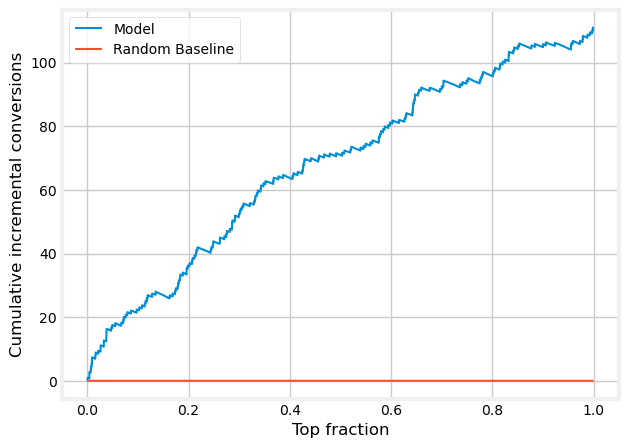

In [346]:
display(qdf_est)

plt.plot(qdf_est['frac'], qdf_est['incremental_cum'], color=palette_538[0], label="Model")
plt.plot(qdf_rand['frac'], qdf_rand['random_incremental_cum'], color=palette_538[1], label="Random Baseline")

plt.xlabel('Top fraction')
plt.ylabel('Cumulative incremental conversions')
plt.legend()
plt.show()

k  n_selected  pred_inc_conv  obs_inc_conv  pred_inc_aum_client  \
0  0.01         101      57.114871      7.355196        258469.111314   
1  0.05         506     106.911507     17.534176        271949.371201   
2  0.10        1012     116.050735     22.269854        280032.044069   

   pred_inc_revenue_client  pred_inc_roi  treated_in_top  \
0               180.928378    650.249547              48   
1               190.364560    687.420455             258   
2               196.022431    707.354148             501   

   expected_random_in_top  
0                0.644804  
1                3.465824  
2                6.730146

<Axes: xlabel='k'>

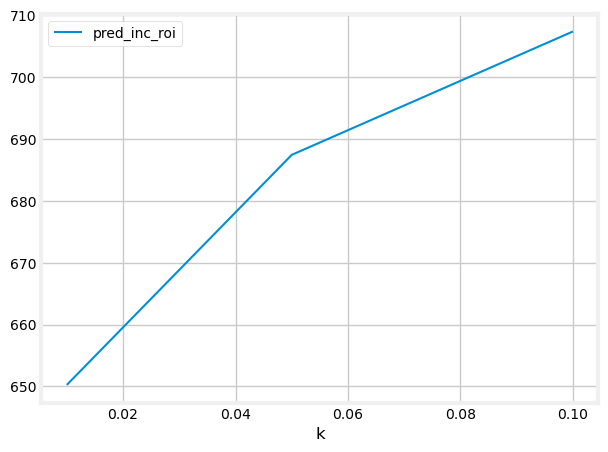

In [347]:
display(topk_est)
topk_est.plot(x='k', y='pred_inc_roi')

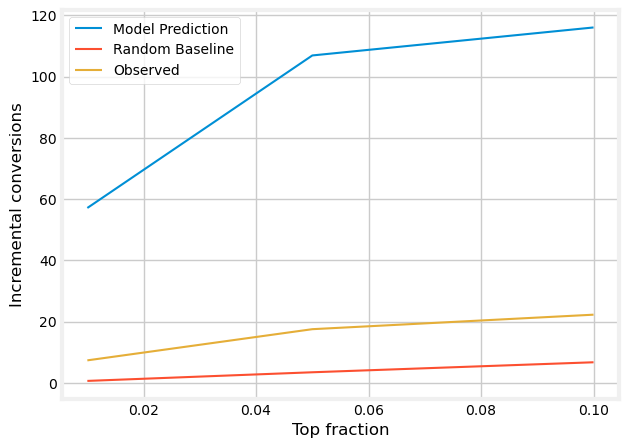

In [348]:
plt.plot(topk_est['k'], topk_est['pred_inc_conv'], label="Model Prediction", color=palette_538[0])
plt.plot(topk_est['k'], topk_est['expected_random_in_top'], label="Random Baseline", color=palette_538[1])
plt.plot(topk_est['k'], topk_est['obs_inc_conv'], label="Observed", color=palette_538[2])

plt.xlabel('Top fraction')
plt.ylabel('Incremental conversions')
plt.legend()
plt.show()

In [ ]:
# # 5) bootstrap to get CIs
# bs_res = bootstrap_pipeline(simple_data,
#                             features,
#                             'treatment',
#                             'converted',
#                             'delta_aum_client',
#                             typical_management_fees,
#                             'roi',
#                             preproc,
#                             estimator_builder=lambda: build_xgb_estimator(max_depth=6, n_estimators=200, learning_rate=0.05, random_state=0, scale_pos_weight=rare_weight),
#                             k_folds=5,
#                             k_bootstrap=200)